# Modeling with k-means, Part 1

The overall aim of this project is to understand the extent to which the k-means algorithm can help us build better classification models than what we can already construct using various supervised learning approaches.  Here I am employing k-means as a supervised learning algorithm, giving it information about the labels indirectly in two distinct ways: (1) through input from one or more supervised learning algorithms in the form of an additional variable, or probability column; and (2) through the addition of weights in the dissimilarity measure, the weights arrived at through cross-validation scores that rely on the labels, or response variable.

Even when k-means is used for unsupervised learning, there are a number of ways we guide, or constrain, the algorithm.  For example, (a) we tell it the number of clusters to find; (b) we select the variables we want the algorithm to work with; and (c) we choose the transformations to apply to those variables.  Variable selection and variable transformations greatly affect the results we see when applying k-means.  The less appropriate the inputs to the algorithm are, the less useful the results will be.  

A fourth way we can guide the algorithm is by applying weights to the variables.  While this is a variant of (c), it deserves its own category because the weights I refer to appear in our object dissimilarity measure and are used to regulate a variable's relative influence "in determining the overall dissimilarity between objects \[i.e., observations\]" (p.505 of *The Elements of Statistical Learning, Second Edition*, by Hastie, Tibshirani, and Friedman; see Equation (14.24)).  In the modeling that follows, the weight given to a variable depends on the role the variable has, in the presence of the other variables, in partitioning the data into the subgroups that are of interest to us.  Those variables assigned a greater weight are, we might say, more important for correctly identifying these subgroups, while the variables assigned a smaller weight are less important.  In any case, it is very likely we will not know what weights to assign unless we have data to work with in which the subgroups of interest are already identified, or labeled.  When k-means is used in an unsupervised learning setting, this information is not available to us.

Sometimes, however, we do have the data we need in order to assign meaningful and relevant weights.  These are the scenarios that are of interest to me in this project.  Preliminary results have shown that a k-means classification model can rival, or even outperform, other classification models.  This is what we see in Parts 1 and 2 of this project, where I work with data on "downer cows".  In Part 3 I again take up the California housing dataset.  Optimal weights are much harder to establish for the variables in that dataset since the number of predictors more than doubles and the amount of training data is 33X greater.  Preliminary results with the CA dataset show that k-means can provide us with a model whose performance is on par with the best random forest model I was able to find.

In Part 5 I continue to work with the CA dataset, but this time trying to identify 3 subgroups rather than just 2.  In Part 4 I work with the Italian wine dataset used by Kabacoff (*R in Action*, p.370); there are 3 varieties to identify.


                                       * * * * *



The downer cow data for Part 1 are introduced on p.266 of Sanford Weisberg's *Applied Linear Regression, 3rd Edition*:

"For unknown reasons, dairy cows sometimes become recumbent---they lay down.  Called *downers*, these cows may have a serious illness that may lead to death of the cow.  These data are from a study of blood samples of over 400 downer cows studied at the Ruakura New Zealand Animal Health Laboratory during 1983-1984.  A variety of blood tests were performed, and for many of the animals, the outcome (survived, died, or animal was killed) was determined.  The goal is to see if survival can be predicted from the blood measurements.  The variables in the data file *downer.txt* are described \[below\].  These data were collected from veterinary records, and not all variables were recorded for all cows."    



                                        * * * * *
                                        

# Section 1: Initial look at the cow data

In this section I look at some of the relationships between the variables in the dataset and choose a subset of these variables for model construction.

In [ ]:
require(car)
require(repr)
require(ggplot2)
require(stringr)
require(faraway)
require(parallel)
require(randomForest)
require(gbm)
require(plyr)
require(e1071)


In [2]:
options(digits= 5, show.signif.stars= FALSE)


In [3]:
df <- read.table("/home/greg/Documents/stat/alr3data/downer.txt", header= TRUE)
dim(df)
colnames(df)


[1] 435   9

[1] "Calving"  "Daysrec"  "CK"       "AST"      "Urea"     "PCV"      "Inflamat"
[8] "Myopathy" "Outcome"

In [ ]:
# Description of the variables in the dataset:

# Outcome : = 1 if the cow survived; 0 if it died or was killed


### Categorical variables:

# Calving : = 0 if measurements were taken before calving; = 1 if taken after.

# Inflamat : Is inflammation present? 0 = no; 1 = yes.

# Myopathy : Is muscle disorder present?  0 = no; 1 = yes.


### Continuous variables:

# Daysrec : days recumbent when measurements were taken.

# CK : serum creatine phosphokinase (in U/l at 30C)

# AST : serum asparate amino transferase (in U/l at 30C)

# Urea : serum ureas (in mmol/l)

# PCV : packed cell volume (hematocrit), percent


In [4]:
# For the categorical variables, we should note the  
# degree to which the data is imbalanced.  The
# following output shows that 38% of the 435 cows
# survived.

table(df$Outcome)
round(mean(df$Outcome, na.rm=TRUE), 4)



  0   1 
269 166 

[1] 0.3816

In [4]:
table(df$Inflamat, useNA= "ifany")



   0    1 <NA> 
  38   98  299 

In [5]:
table(df$Calving, useNA= "ifany")



   0    1 <NA> 
 107  324    4 

In [6]:
table(df$Myopathy, useNA= "ifany")



   0    1 <NA> 
 127   95  213 

In [7]:
summary(df$Daysrec)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.000   1.000   1.947   3.000  20.000       3 

In [3]:
# Percent of cows recumbent < 1 day.

val <- dim(df[which(df$Daysrec < 1),])[1]
round(val/nrow(df), 3)


[1] 0.308

In [8]:
summary(df$CK)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
     13     560    1760    5352    5467   71000      22 

In [9]:
summary(df$AST)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   33.0   123.0   240.0   398.4   492.0  2533.0       6 

In [10]:
summary(df$Urea)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  1.000   5.625   7.600   9.803  10.975  50.000     169 

In [11]:
summary(df$PCV)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  13.00   32.00   35.00   35.56   40.00   61.00     260 

In [15]:
# To what degree does Calving "explain" Outcome?

fit_calv <- glm(Outcome ~ Calving, data=df, family= binomial())
summary(fit_calv)



Call:
glm(formula = Outcome ~ Calving, family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
 -1.01   -1.01   -0.89    1.35    1.50  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.721      0.206   -3.50  0.00046
Calving        0.321      0.235    1.36  0.17228

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 573.6  on 430  degrees of freedom
Residual deviance: 571.7  on 429  degrees of freedom
  (4 observations deleted due to missingness)
AIC: 575.7

Number of Fisher Scoring iterations: 4


In [16]:
# To what degree does Inflamat explain Outcome?

fit_infla <- glm(Outcome ~ Inflamat, data=df, family= binomial())
summary(fit_infla)



Call:
glm(formula = Outcome ~ Inflamat, family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.089  -0.855  -0.855   1.268   1.539  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.211      0.326   -0.65     0.52
Inflamat      -0.607      0.393   -1.54     0.12

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 175.35  on 135  degrees of freedom
Residual deviance: 172.99  on 134  degrees of freedom
  (299 observations deleted due to missingness)
AIC: 177

Number of Fisher Scoring iterations: 4


In [17]:
# Look at Calving and Inflamat together.

fit_calv_infla <- glm(Outcome ~ Calving*Inflamat, data=df, family= binomial())
summary(fit_calv_infla)



Call:
glm(formula = Outcome ~ Calving * Inflamat, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.096  -0.914  -0.914   1.261   2.265  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)
(Intercept)       -0.2877     0.7638   -0.38    0.706
Calving            0.0935     0.8447    0.11    0.912
Inflamat          -2.1972     1.2910   -1.70    0.089
Calving:Inflamat   1.7333     1.3599    1.27    0.202

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 175.35  on 135  degrees of freedom
Residual deviance: 168.40  on 132  degrees of freedom
  (299 observations deleted due to missingness)
AIC: 176.4

Number of Fisher Scoring iterations: 5


In [26]:
# To what degree does Myopathy explain Outcome?

fit_myop <- glm(Outcome ~ Myopathy, data=df, family= binomial())
summary(fit_myop)



Call:
glm(formula = Outcome ~ Myopathy, family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.987  -0.987  -0.361  -0.361   2.350  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.465      0.182   -2.55    0.011
Myopathy      -2.232      0.459   -4.86  1.2e-06

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 248.57  on 221  degrees of freedom
Residual deviance: 214.14  on 220  degrees of freedom
  (213 observations deleted due to missingness)
AIC: 218.1

Number of Fisher Scoring iterations: 5


In [3]:
# Function for computing the probability that the response
# variable is 1 given the value of the predictor, its 
# logistic regression coefficient (link =  logit), and
# the coefficient of the intercept.

get_prob <- function(x, coeffs) {
    
    b0 <- as.numeric(coeffs[1])
    b1 <- as.numeric(coeffs[2])
    prob <- (exp(b0 + b1*x)/(1 + exp(b0 + b1*x)))
    return(round(prob, 3))
}


In [30]:
# Probability of the "average" sick cow surviving if 
# muscle disorder is not present. 

get_prob(0, fit_myop$coeff)


[1] 0.386

In [31]:
# Probability of the "average" sick cow surviving if 
# muscle disorder IS present. 

get_prob(1, fit_myop$coeff)


[1] 0.063

In [ ]:
### COMMENTS:

# Myopathy, as we would expect, is an important predictor.
# However, this variable is missing for nearly half of the 
# observations in the dataset.  

# The negative coefficient in the above regression model is
# another way to see that when myopathy is present, the 
# likelihood of the cow surviving decreases.


In [20]:
# Is Calving important, controlling for Myopathy?  (The 
# interaction term has a non-significant p-value and,
# thus, is not used in the following model.)

fit_calv_myop <- glm(Outcome ~ Calving + Myopathy, 
                     data=df, family= binomial)
summary(fit_calv_myop)



Call:
glm(formula = Outcome ~ Calving + Myopathy, family = binomial(), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0536  -0.9703  -0.3543   0.0609   2.3663  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.298      0.365   -0.82     0.41
Calving       -0.210      0.401   -0.53     0.60
Myopathy      -2.228      0.462   -4.82  1.4e-06

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 247.43  on 219  degrees of freedom
Residual deviance: 213.60  on 217  degrees of freedom
  (215 observations deleted due to missingness)
AIC: 219.6

Number of Fisher Scoring iterations: 5


In [32]:
# Is Daysrec a predictor of Outcome?

fit_daysre <- glm(Outcome ~ Daysrec, data=df, family= binomial())
summary(fit_daysre)



Call:
glm(formula = Outcome ~ Daysrec, family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.103  -1.034  -0.842   1.254   2.288  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -0.1782     0.1308   -1.36  0.17311
Daysrec      -0.1689     0.0512   -3.30  0.00097

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 574.57  on 431  degrees of freedom
Residual deviance: 561.62  on 430  degrees of freedom
  (3 observations deleted due to missingness)
AIC: 565.6

Number of Fisher Scoring iterations: 4


In [33]:
# The 3rd quartile for Daysrec is 3.0.  Here is the probability
# of the average downer cow surviving if it has been recumbent 
# for 3 days.

get_prob(3.0, fit_daysre$coeff)


[1] 0.335

In [34]:
# The probability that the average cow survives increases as
# the number of days recumbent decreases.

get_prob(0, fit_daysre$coeff)


[1] 0.456

In [ ]:
### COMMENT:

# Since Daysrec is predictive of the outcome, we perhaps
# ought to control for this variable when regressing 
# Outcome on the blood measurements.

# Further downstream I regress CK and AST on Daysrec.
# The results tell us that we should control for
# Daysrec.


In [31]:
# Is Calving predictive when we control for Daysrec?

fit_daysre_calv <- glm(Outcome ~ Daysrec + Calving, data=df,
                       family= binomial())
summary(fit_daysre_calv)



Call:
glm(formula = Outcome ~ Daysrec + Calving, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.146  -1.026  -0.834   1.230   2.468  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -0.3682     0.2268   -1.62  0.10447
Daysrec      -0.1877     0.0537   -3.49  0.00048
Calving       0.2931     0.2398    1.22  0.22158

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 569.75  on 427  degrees of freedom
Residual deviance: 553.09  on 425  degrees of freedom
  (7 observations deleted due to missingness)
AIC: 559.1

Number of Fisher Scoring iterations: 4


In [32]:
# Is Inflamat predictive when we control for Daysrec?

fit_daysre_infla <- glm(Outcome ~ Daysrec + Inflamat, data=df,
                       family= binomial())
summary(fit_daysre_infla)



Call:
glm(formula = Outcome ~ Daysrec + Inflamat, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.197  -0.984  -0.736   1.347   1.813  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   0.0459     0.3499    0.13    0.896
Daysrec      -0.2594     0.1228   -2.11    0.035
Inflamat     -0.4360     0.4035   -1.08    0.280

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 175.35  on 135  degrees of freedom
Residual deviance: 167.83  on 133  degrees of freedom
  (299 observations deleted due to missingness)
AIC: 173.8

Number of Fisher Scoring iterations: 4


In [33]:
# Is Myopathy still predictive when we control for Daysrec?

fit_daysre_myop <- glm(Outcome ~ Daysrec + Myopathy, data=df,
                       family= binomial())
summary(fit_daysre_myop)



Call:
glm(formula = Outcome ~ Daysrec + Myopathy, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.013  -0.977  -0.370  -0.310   2.367  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  -0.3700     0.3484   -1.06     0.29
Daysrec      -0.0305     0.0955   -0.32     0.75
Myopathy     -2.2469     0.4626   -4.86  1.2e-06

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 248.57  on 221  degrees of freedom
Residual deviance: 214.03  on 219  degrees of freedom
  (213 observations deleted due to missingness)
AIC: 220

Number of Fisher Scoring iterations: 5


In [ ]:
### COMMENT:

# Daysrec and Myopathy are doing some of the same work.
# The p-value on Daysrec in the above model says we do
# not need this variable when we have Myopathy in the
# model.
# An increase in the value of either variable means that  
# a cow's chances of surviving go down.


In [23]:
# To what extent does Daysrec predict Myopathy?

tmpdat <- na.omit(df[, c("Myopathy","Daysrec")])

mod_daysre_myop <- glm(Myopathy ~ I(Daysrec^0.5), data=tmpdat,
                       family= binomial)
summary(mod_daysre_myop)



Call:
glm(formula = Myopathy ~ I(Daysrec^0.5), family = binomial, data = tmpdat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.230  -1.105  -0.876   1.251   1.990  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)
(Intercept)       0.837      0.392    2.13   0.0328
I(Daysrec^0.5)   -0.713      0.234   -3.05   0.0023

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 303.13  on 221  degrees of freedom
Residual deviance: 293.01  on 220  degrees of freedom
AIC: 297

Number of Fisher Scoring iterations: 4


In [44]:
# The following table is another way of seeing the 
# negative correlation between Daysrec and Myopathy.

aggregate(Daysrec ~ Myopathy, data=tmpdat, FUN= mean)


Myopathy,Daysrec
<int>,<dbl>
0,3.1260
1,2.7053


In [49]:
# Sample correlation between Myopathy and Daysrec.

round(cor(tmpdat$Myopathy, sqrt(tmpdat$Daysrec)), 3)


[1] -0.211

In [6]:
# Function for computing "proportion of deviance explained", an 
# R-sqrd statistic for link= logit.  See p.41 of Julian Faraway's
# "Extending the Linear Model with R" (2006: Chapman & Hall).  
# This statistic is due to N. Nagelkerke (1991; see Faraway's
# bibliography).

get_RsqrdDev <- function(modl) {
    
    n_obs <- length(modl$fitted.values)
    ans <- (1-exp((modl$deviance - modl$null.deviance)/n_obs))/(1-exp(-modl$null.deviance/n_obs))
    return(round(ans, 4))
}


In [45]:
# In ordinary least squares regression (OLS), R-sqrd is the 
# square of the sample correlation between the predictor
# and the response.  What follows is a pseudo-correlation
# based on the R-sqrd metric for logistic regression 
# computed by get_RsqrdDev.

ans <- get_RsqrdDev(mod_daysre_myop)
print(paste("Approximate correlation betw. Myopathy and Daysrec: ",
           as.character(round(-sqrt(ans), 3)), sep=""))


[1] "Approximate correlation betw. Myopathy and Daysrec: -0.245"


In [19]:
# The negative correlation between Daysrec and Myopathy is a bit
# surprising.  However, since it is unlikely that the missing 
# Myopathy data is missing at random, there is reason to be skeptical
# regarding this negative correlation.  Or, the explanation for the
# negative correlation might be as follows: if muscle disorder is
# present, fewer days of recumbency are needed before one thinks
# the cow is sick enough for blood samples to be drawn.

# We get a sense of the rate of change in the table that follows.

newdat <- c(0, 1, 4, 9, 16)
dim(newdat) <- c(5, 1)
newdat <- as.data.frame(newdat)
colnames(newdat) <- c("Daysrec")

# Find the probability that Myopathy = 1 as Daysrec varies.
newdat$Prob <- round(predict(mod_daysre_myop, newdata=newdat, type="response"), 2)
print(head(newdat))


  Daysrec Prob
1       0 0.70
2       1 0.53
3       4 0.36
4       9 0.21
5      16 0.12


### The blood measurement variables

In [7]:
# Variable CK:

fit_ck <- glm(Outcome ~ I(log(CK)), data= df, family= binomial())
summary(fit_ck)



Call:
glm(formula = Outcome ~ I(log(CK)), family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.134  -0.881  -0.561   1.059   1.994  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   4.0006     0.5809    6.89  5.7e-12
I(log(CK))   -0.6117     0.0793   -7.71  1.2e-14

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 550.49  on 412  degrees of freedom
Residual deviance: 475.18  on 411  degrees of freedom
  (22 observations deleted due to missingness)
AIC: 479.2

Number of Fisher Scoring iterations: 3


In [38]:
# Variable CK, controlling for Daysrec:

fit_ck_days <- glm(Outcome ~ I(log(CK)) + Daysrec, 
                   data= df, family= binomial())
summary(fit_ck_days)



Call:
glm(formula = Outcome ~ I(log(CK)) + Daysrec, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.195  -0.885  -0.559   1.039   2.072  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   4.0929     0.5887    6.95  3.6e-12
I(log(CK))   -0.5939     0.0805   -7.38  1.6e-13
Daysrec      -0.1330     0.0643   -2.07    0.039

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 546.64  on 409  degrees of freedom
Residual deviance: 465.95  on 407  degrees of freedom
  (25 observations deleted due to missingness)
AIC: 471.9

Number of Fisher Scoring iterations: 3


In [25]:
# Regress CK on Daysrec to see whether the time when the 
# blood measurement was taken matters.

resp_var_pwr <- -0.2

ck_days <- lm(I(CK^resp_var_pwr) ~ Daysrec, data= df)
summary(ck_days)



Call:
lm(formula = I(CK^resp_var_pwr) ~ Daysrec, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1441 -0.0554 -0.0129  0.0452  0.3475 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.25117    0.00529   47.51   <2e-16
Daysrec     -0.00847    0.00214   -3.96    9e-05

Residual standard error: 0.0784 on 408 degrees of freedom
  (25 observations deleted due to missingness)
Multiple R-squared:  0.0369,	Adjusted R-squared:  0.0346 
F-statistic: 15.7 on 1 and 408 DF,  p-value: 8.97e-05


In [ ]:
### COMMENT: 

# Daysrec explains only 3.5% of the variation in CK. 


In [35]:
# Variable AST:

fit_ast <- glm(Outcome ~ I(log(AST)), data= df, family= binomial())
summary(fit_ast)



Call:
glm(formula = Outcome ~ I(log(AST)), family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.889  -0.906  -0.535   1.020   2.357  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    5.407      0.738    7.33  2.4e-13
I(log(AST))   -1.089      0.137   -7.93  2.3e-15

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 569.75  on 428  degrees of freedom
Residual deviance: 489.08  on 427  degrees of freedom
  (6 observations deleted due to missingness)
AIC: 493.1

Number of Fisher Scoring iterations: 4


In [39]:
# Variable AST, controlling for Daysrec:

fit_ast_days <- glm(Outcome ~ I(log(AST)) + Daysrec, 
                    data= df, family= binomial())
summary(fit_ast_days)



Call:
glm(formula = Outcome ~ I(log(AST)) + Daysrec, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.905  -0.896  -0.539   1.005   2.329  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   5.3260     0.7461    7.14  9.4e-13
I(log(AST))  -1.0551     0.1416   -7.45  9.3e-14
Daysrec      -0.0511     0.0488   -1.05     0.29

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 565.90  on 425  degrees of freedom
Residual deviance: 483.99  on 423  degrees of freedom
  (9 observations deleted due to missingness)
AIC: 490

Number of Fisher Scoring iterations: 4


In [ ]:
### COMMENTS:

# We see from the above model that Daysrec and AST
# are doing some of the same work in terms of
# explaining the variance in the response variable.
# The output suggests that we remove Daysrec
# from the model.  As already mentioned, I will keep
# Daysrec in the final model to control for the
# effects of this variable on the measurements of
# both CK and AST.

# Also, having a third dimension is likely to help
# the k-means algorithm and give a boost to the tree
# models examined further downstream.


In [35]:
# Regress AST on Daysrec to see whether the time when the 
# blood measurement was taken matters.

resp_var_pwr <- -0.2

ast_days <- lm(I(AST^resp_var_pwr) ~ Daysrec, data= df)
summary(ast_days)



Call:
lm(formula = I(AST^resp_var_pwr) ~ Daysrec, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13600 -0.04345 -0.00063  0.04520  0.16391 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  0.35054    0.00374   93.83  < 2e-16
Daysrec     -0.00719    0.00119   -6.04  3.4e-09

Residual standard error: 0.06 on 424 degrees of freedom
  (9 observations deleted due to missingness)
Multiple R-squared:  0.0792,	Adjusted R-squared:  0.077 
F-statistic: 36.4 on 1 and 424 DF,  p-value: 3.43e-09


In [ ]:
### COMMENT:

# Daysrec explains around 8% of the variation in AST. 


In [36]:
# Variable Urea:

fit_urea <- glm(Outcome ~ Urea, data= df, family= binomial())
summary(fit_urea)



Call:
glm(formula = Outcome ~ Urea, family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.388  -1.050  -0.703   1.230   2.180  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    0.604      0.284    2.13    0.033
Urea          -0.121      0.031   -3.91  9.4e-05

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 354.17  on 265  degrees of freedom
Residual deviance: 331.11  on 264  degrees of freedom
  (169 observations deleted due to missingness)
AIC: 335.1

Number of Fisher Scoring iterations: 5


In [40]:
# Variable Urea, controlling for Daysrec:

fit_urea_days <- glm(Outcome ~ Urea + Daysrec, data= df, 
                     family= binomial())
summary(fit_urea_days)



Call:
glm(formula = Outcome ~ Urea + Daysrec, family = binomial(), 
    data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.584  -0.968  -0.551   1.077   2.772  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   1.3929     0.3668    3.80  0.00015
Urea         -0.1577     0.0365   -4.32  1.6e-05
Daysrec      -0.3651     0.0936   -3.90  9.6e-05

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 352.25  on 264  degrees of freedom
Residual deviance: 309.69  on 262  degrees of freedom
  (170 observations deleted due to missingness)
AIC: 315.7

Number of Fisher Scoring iterations: 5


In [37]:
# Variable PCV:

fit_pcv <- glm(Outcome ~ PCV, data= df, family= binomial())
summary(fit_pcv)



Call:
glm(formula = Outcome ~ PCV, family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.988  -0.912  -0.891   1.462   1.528  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.34184    0.84857    -0.4     0.69
PCV         -0.00942    0.02353    -0.4     0.69

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 223.69  on 174  degrees of freedom
Residual deviance: 223.53  on 173  degrees of freedom
  (260 observations deleted due to missingness)
AIC: 227.5

Number of Fisher Scoring iterations: 4


In [41]:
# Variable PCV, controlling for Daysrec:

fit_pcv_days <- glm(Outcome ~ PCV + Daysrec, data= df, 
                    family= binomial())
summary(fit_pcv_days)



Call:
glm(formula = Outcome ~ PCV + Daysrec, family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.180  -0.960  -0.734   1.277   1.970  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   0.2860     0.8778    0.33   0.7445
PCV          -0.0148     0.0238   -0.62   0.5345
Daysrec      -0.3195     0.1144   -2.79   0.0052

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 223.69  on 174  degrees of freedom
Residual deviance: 213.76  on 172  degrees of freedom
  (260 observations deleted due to missingness)
AIC: 219.8

Number of Fisher Scoring iterations: 4


In [36]:
# Because Urea and PCV have quite a few missing values, I
# drop these terms relatively quickly in the modeling that
# follows.  

dfb <- df[, c("Outcome","Daysrec","CK","AST","Urea","PCV")]
nrow(dfb)


[1] 435

## Find best logistic regression model for predicting Outcome

In [29]:
fit_dfb <- glm(Outcome ~ Daysrec + I(log(CK)) + I(log(AST)) + 
               I(scale(Urea)) + I(scale(PCV)),
              data= dfb, family= binomial())
summary(fit_dfb)



Call:
glm(formula = Outcome ~ Daysrec + I(log(CK)) + I(log(AST)) + 
    I(scale(Urea)) + I(scale(PCV)), family = binomial(), data = dfb)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.909  -0.753  -0.338   0.776   2.182  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)
(Intercept)       4.964      1.424    3.49  0.00049
Daysrec          -0.356      0.139   -2.56  0.01055
I(log(CK))       -0.256      0.220   -1.16  0.24462
I(log(AST))      -0.693      0.404   -1.72  0.08611
I(scale(Urea))   -1.921      0.496   -3.87  0.00011
I(scale(PCV))     0.462      0.221    2.09  0.03643

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 212.71  on 164  degrees of freedom
Residual deviance: 153.81  on 159  degrees of freedom
  (270 observations deleted due to missingness)
AIC: 165.8

Number of Fisher Scoring iterations: 6


In [42]:
# Remove PCV from the model because it has so many NAs.  For
# the f02 model we have 256 observations.

f02 <- glm(Outcome ~ Daysrec + I(log(CK)) + I(log(AST)) + 
            I(scale(Urea)),
            data= dfb, family= binomial())
summary(f02)



Call:
glm(formula = Outcome ~ Daysrec + I(log(CK)) + I(log(AST)) + 
    I(scale(Urea)), family = binomial(), data = dfb)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.160  -0.839  -0.349   0.887   3.239  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)
(Intercept)       5.404      1.093    4.95  7.6e-07
Daysrec          -0.209      0.105   -1.99  0.04653
I(log(CK))       -0.302      0.159   -1.89  0.05824
I(log(AST))      -0.687      0.296   -2.32  0.02031
I(scale(Urea))   -1.027      0.295   -3.48  0.00049

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 341.64  on 255  degrees of freedom
Residual deviance: 262.71  on 251  degrees of freedom
  (179 observations deleted due to missingness)
AIC: 272.7

Number of Fisher Scoring iterations: 5


In [43]:
# Model without Urea; it, too, has many NAs.  The f03
# model has 408 observations.  

f03 <- glm(Outcome ~ Daysrec + I(log(CK)) + I(log(AST)),  
            data= dfb, family= binomial())
summary(f03)



Call:
glm(formula = Outcome ~ Daysrec + I(log(CK)) + I(log(AST)), family = binomial(), 
    data = dfb)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.186  -0.893  -0.523   0.997   2.195  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   5.1704     0.7659    6.75  1.5e-11
Daysrec      -0.0855     0.0689   -1.24   0.2143
I(log(CK))   -0.3882     0.1233   -3.15   0.0016
I(log(AST))  -0.4904     0.2209   -2.22   0.0264

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 543.76  on 407  degrees of freedom
Residual deviance: 457.50  on 404  degrees of freedom
  (27 observations deleted due to missingness)
AIC: 465.5

Number of Fisher Scoring iterations: 4


In [ ]:
### COMMENTS:

# Each of Daysrec, CK, and AST are highly predictive of the
# outcome.  AST and Daysrec do some of the same work in terms
# of predicting Outcome.  Even so, it is important to control
# for this variable since CK and AST are blood measurements
# observed at different times for each cow.  In this case, 
# time is measured by Daysrec.  Also, as we saw above, Daysrec 
# explains around 3.5% of the variation in CK and around 8% of
# the variation in AST. 


In [50]:
dfb <- df[, c("Outcome","Daysrec","CK","AST")]
nrow(dfb)


[1] 435

In [51]:
# Remove observations with missing values.

dfb <- na.omit(dfb)
dim(dfb)


[1] 408   4

In [48]:
# It often helps to model with time squared.  However,
# adding a quadratic, or the quadratic and cubic of 
# Daysrec, to our model does not help.



Call:
glm(formula = Outcome ~ Daysrec + I(Daysrec^2) + I(Daysrec^3) + 
    I(log(CK)) + I(log(AST)), family = binomial(), data = dfb)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.175  -0.888  -0.520   0.997   2.232  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)   5.16501    0.76990    6.71    2e-11
Daysrec       0.13925    0.36068    0.39   0.6994
I(Daysrec^2) -0.09002    0.15492   -0.58   0.5612
I(Daysrec^3)  0.00849    0.01645    0.52   0.6058
I(log(CK))   -0.40182    0.12602   -3.19   0.0014
I(log(AST))  -0.48462    0.22086   -2.19   0.0282

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 543.76  on 407  degrees of freedom
Residual deviance: 457.09  on 402  degrees of freedom
AIC: 469.1

Number of Fisher Scoring iterations: 4


### f03 model diagnostics

#### Check f03 for overdispersion

In [63]:
# If we have overdispersion, the standard errors for the
# model coefficients will be too small.

# We want the following value to NOT be considerably larger
# than 1.  If it is, then we have to use family= quasibinomial
# in our modeling. (See p.311 of Kabacoff's "R in Action".)

phi <- deviance(f03)/df.residual(f03)
print(round(phi, 3))


[1] 1.132


In [62]:
# For a more accurate test, we need to also fit using family = 
# quasibinomial.

f03_od <- glm(Outcome ~ Daysrec + I(log(CK)) + I(log(AST)),  
            data= dfb, family= quasibinomial)


In [64]:
# See p.311 of Kabacoff's "R in Action".  The null hypothesis
# is that the dispersion (phi) = 1.  The alternative hypothesis
# is that phi != 1.  If the following p-value is small (e.g.,
# < 0.05), we have good evidence for rejecting the null 
# hypothesis.

ans <- pchisq(summary(f03_od)$dispersion * f03$df.residual,
              f03$df.residual, lower= FALSE)
round(ans, 4)


[1] 0.5695

In [ ]:
### COMMENT: 

# There is no evidence of overdispersion with the f03 model.


In [57]:
length(f03$fitted.values)


[1] 408

In [61]:
# get_RsqrdDev is defined above.  It computes the "proportion 
# of deviance explained", an R-sqrd statistic for link= logit.

f03_Rsqrd <- get_RsqrdDev(f03)
print(f03_Rsqrd)
# [1] 0.2588


[1] 0.2588


In [43]:
# Try different power transformations on the predictors to
# see if we can boost the Rsqrd.

f03_b <- glm(Outcome ~ 
             
             I(Daysrec^1.5) + 
             I(CK^0.6) + 
             I(AST^-0.33),
             
            data= dfb, family= binomial())
summary(f03_b)
print(get_RsqrdDev(f03_b))
# [1] 0.2821



Call:
glm(formula = Outcome ~ I(Daysrec^1.5) + I(CK^0.6) + I(AST^-0.33), 
    family = binomial(), data = dfb)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.836  -0.934  -0.419   0.985   2.345  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)
(Intercept)    -0.56651    0.81313   -0.70    0.486
I(Daysrec^1.5) -0.04411    0.02874   -1.53    0.125
I(CK^0.6)      -0.00851    0.00214   -3.97  7.1e-05
I(AST^-0.33)    6.65170    3.49487    1.90    0.057

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 543.76  on 407  degrees of freedom
Residual deviance: 448.76  on 404  degrees of freedom
AIC: 456.8

Number of Fisher Scoring iterations: 5


[1] 0.2821


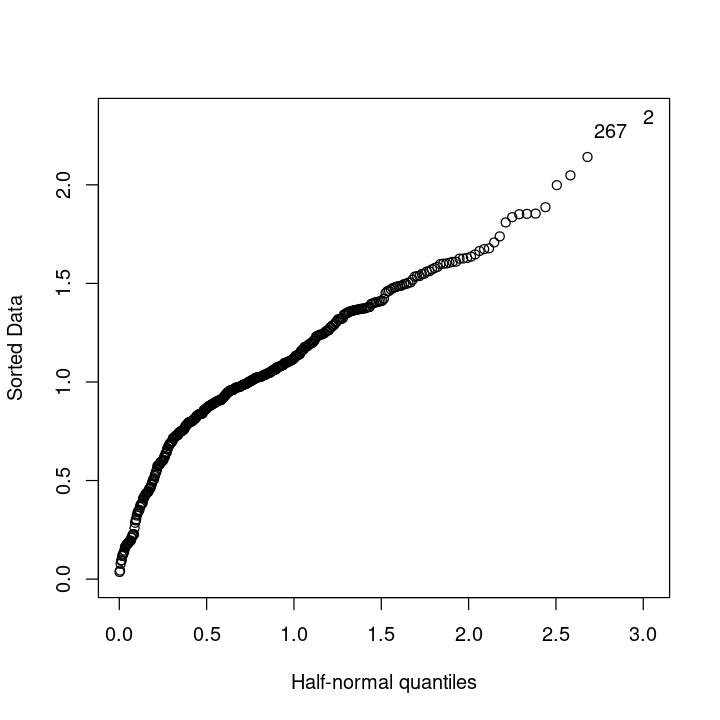

In [44]:
# Plot the residuals.  Julian Faraway's half-normal plot can
# be used to check for outliers.  See p.46 of Faraway's 
# "Extending the Linear Model with R".  The residuals plotted
# here are the deviance residuals.

options(repr.plot.width= 6, repr.plot.height= 6)

# Function halfnorm is from package faraway.
halfnorm(residuals(f03_b))


In [45]:
# Remove the 2 identified points.  Faraway's halfnorm 
# function identifies the points by their order in the
# dataframe and not by the rowname of the observation!

tmpdat <- dfb
nrow(tmpdat)
tmpdat <- tmpdat[c(-2, -267),]
nrow(tmpdat)


[1] 408

[1] 406

In [53]:
f03_b2 <- glm(Outcome ~ 
             
             I(Daysrec^1.3) + 
             I(CK^1) + 
             I(AST^-0.3),
             
            data= tmpdat, family= binomial())
summary(f03_b2)
print(get_RsqrdDev(f03_b2))



Call:
glm(formula = Outcome ~ I(Daysrec^1.3) + I(CK^1) + I(AST^-0.3), 
    family = binomial(), data = tmpdat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.798  -0.954  -0.315   0.979   2.360  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)
(Intercept)    -1.22e+00   7.88e-01   -1.55  0.12026
I(Daysrec^1.3) -6.53e-02   4.15e-02   -1.57  0.11544
I(CK^1)        -2.11e-04   5.71e-05   -3.71  0.00021
I(AST^-0.3)     7.49e+00   3.15e+00    2.38  0.01734

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 539.92  on 405  degrees of freedom
Residual deviance: 436.59  on 402  degrees of freedom
AIC: 444.6

Number of Fisher Scoring iterations: 6


[1] 0.3055


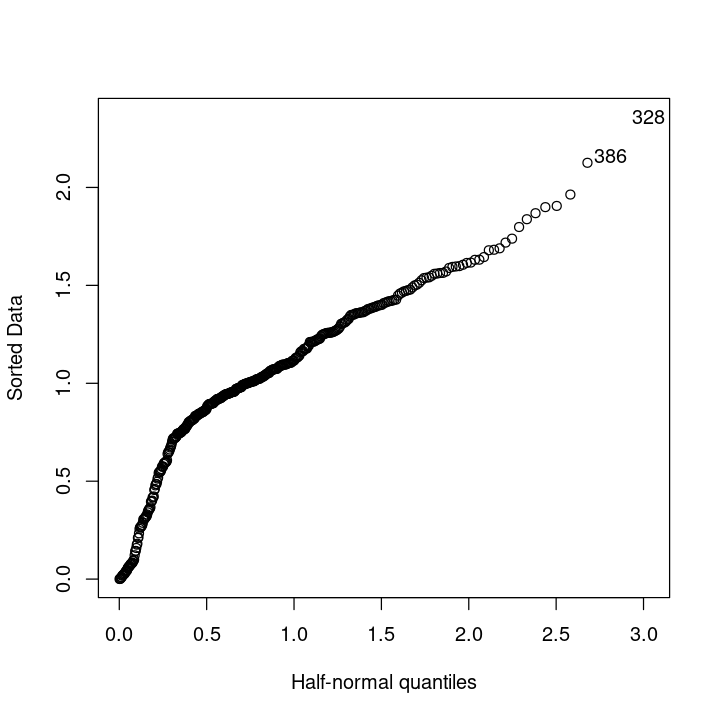

In [54]:
options(repr.plot.width= 6, repr.plot.height= 6)

halfnorm(residuals(f03_b2))


In [55]:
# Again, remove the 2 identified points.  There are
# now 404 observations remaining.

tmpdat <- tmpdat[c(-328, -386),]
nrow(tmpdat)


[1] 404

In [67]:
f03_b3 <- glm(Outcome ~ 
             
             I(Daysrec^1.3) + 
             I(CK^1) + 
             I(AST^-0.3),
             
            data= tmpdat, family= binomial())
summary(f03_b3)
print(get_RsqrdDev(f03_b3))



Call:
glm(formula = Outcome ~ I(Daysrec^1.3) + I(CK^1) + I(AST^-0.3), 
    family = binomial(), data = tmpdat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.817  -0.945  -0.264   0.968   2.243  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)
(Intercept)    -1.184216   0.811590   -1.46  0.14453
I(Daysrec^1.3) -0.063026   0.041829   -1.51  0.13187
I(CK^1)        -0.000247   0.000064   -3.86  0.00011
I(AST^-0.3)     7.495533   3.221989    2.33  0.02000

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 536.05  on 403  degrees of freedom
Residual deviance: 425.80  on 400  degrees of freedom
AIC: 433.8

Number of Fisher Scoring iterations: 7


[1] 0.3251


In [68]:
# Tweak the power transformations.

f03_b4 <- glm(Outcome ~ 
             
             I(Daysrec^1.5) + 
             I(CK^1.25) + 
             I(AST^-0.1),
             
            data= tmpdat, family= binomial())
summary(f03_b4)
print(get_RsqrdDev(f03_b4))



Call:
glm(formula = Outcome ~ I(Daysrec^1.5) + I(CK^1.25) + I(AST^-0.1), 
    family = binomial(), data = tmpdat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.746  -0.959  -0.233   0.970   2.274  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)
(Intercept)    -5.13e+00   2.09e+00   -2.46  0.01392
I(Daysrec^1.5) -4.16e-02   2.93e-02   -1.42  0.15546
I(CK^1.25)     -2.41e-05   6.91e-06   -3.49  0.00049
I(AST^-0.1)     9.10e+00   3.35e+00    2.71  0.00671

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 536.05  on 403  degrees of freedom
Residual deviance: 425.55  on 400  degrees of freedom
AIC: 433.6

Number of Fisher Scoring iterations: 7


[1] 0.3257


In [ ]:
### COMMENT:

# We started out with an Rsqrd of about 26%.  With the
# power transformations and the removal of 4 outliers,
# we now have a model with an Rsqrd close to 32.6%.


,StudRes,Hat,CookD
,<dbl>,<dbl>,<dbl>
195,-1.0799,0.059290,0.012557
273,1.7705,0.038456,0.036109
344,-1.1393,0.066158,0.016244
348,2.3148,0.015148,0.047872
400,2.0827,0.013865,0.026058


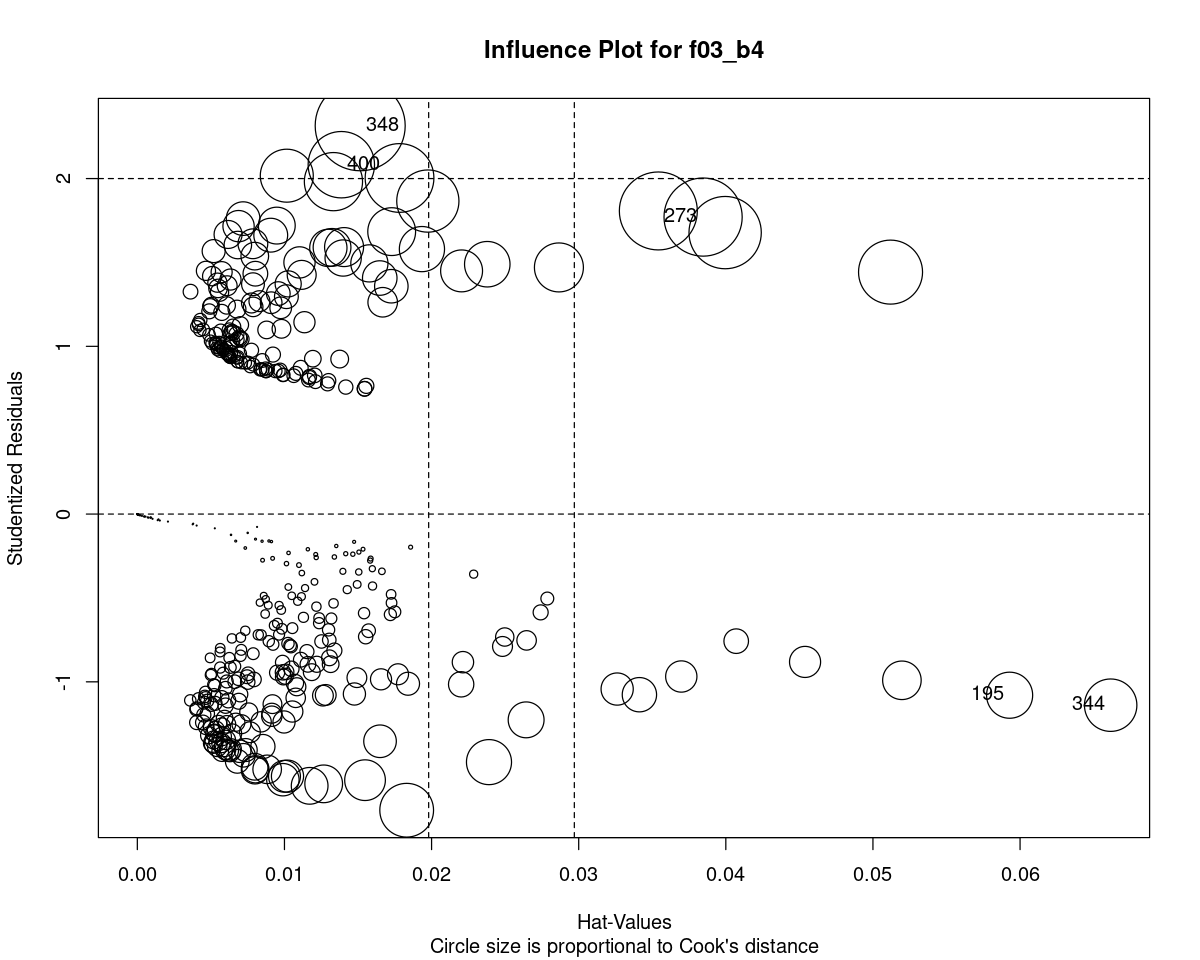

In [69]:
options(repr.plot.width= 10, repr.plot.height= 8)

# influencePlot is from the car package.
influencePlot(f03_b4, main="Influence Plot for f03_b4", 
              sub= "Circle size is proportional to Cook's distance")


In [70]:
# Remove obs. 348 from tmpdat.  Here the point is identified
# by its rowname.

tmpdat02 <- tmpdat[which(!(rownames(tmpdat) %in% c(348))),]


In [72]:
f03_b5 <- glm(Outcome ~ 
             
             I(Daysrec^1.5) + 
             I(CK^1.2) + 
             I(AST^-0.1),
             
            data= tmpdat02, family= binomial)
summary(f03_b5)
print(get_RsqrdDev(f03_b5))



Call:
glm(formula = Outcome ~ I(Daysrec^1.5) + I(CK^1.2) + I(AST^-0.1), 
    family = binomial, data = tmpdat02)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.743  -0.955  -0.207   0.963   2.127  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)
(Intercept)    -4.75e+00   2.13e+00   -2.23  0.02544
I(Daysrec^1.5) -4.29e-02   2.94e-02   -1.46  0.14515
I(CK^1.2)      -4.28e-05   1.17e-05   -3.66  0.00025
I(AST^-0.1)     8.55e+00   3.41e+00    2.51  0.01220

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 534.11  on 402  degrees of freedom
Residual deviance: 420.23  on 399  degrees of freedom
AIC: 428.2

Number of Fisher Scoring iterations: 7


[1] 0.3352


In [74]:
# Adjust the power transformations.

f03_b6 <- glm(Outcome ~ 
             
             Daysrec + 
             I(CK^1.2) + 
             I(AST^-0.1),
             
            data= tmpdat02, family= binomial)
summary(f03_b6)
print(get_RsqrdDev(f03_b6))



Call:
glm(formula = Outcome ~ Daysrec + I(CK^1.2) + I(AST^-0.1), family = binomial, 
    data = tmpdat02)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.752  -0.960  -0.208   0.959   2.139  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -4.60e+00   2.16e+00   -2.13  0.03306
Daysrec     -1.06e-01   7.10e-02   -1.50  0.13403
I(CK^1.2)   -4.25e-05   1.16e-05   -3.66  0.00025
I(AST^-0.1)  8.37e+00   3.45e+00    2.43  0.01519

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 534.11  on 402  degrees of freedom
Residual deviance: 420.14  on 399  degrees of freedom
AIC: 428.1

Number of Fisher Scoring iterations: 7


[1] 0.3355


In [75]:
nrow(tmpdat02)


[1] 403

In [76]:
# Update our working dataframe.

dfb <- tmpdat02


In [77]:
# Save the file.

write.csv(dfb, file="/home/greg/Documents/stat/github_repos/cows/downer.csv",
         row.names= TRUE)


In [78]:
# Re-construct the model with the dfb dataframe.

f03_b6 <- glm(Outcome ~ 
             
             Daysrec + 
             I(CK^1.2) + 
             I(AST^-0.1),
             
            data= dfb, family= binomial())
summary(f03_b6)
print(get_RsqrdDev(f03_b6))
# [1] 0.3355



Call:
glm(formula = Outcome ~ Daysrec + I(CK^1.2) + I(AST^-0.1), family = binomial(), 
    data = dfb)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.752  -0.960  -0.208   0.959   2.139  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -4.60e+00   2.16e+00   -2.13  0.03306
Daysrec     -1.06e-01   7.10e-02   -1.50  0.13403
I(CK^1.2)   -4.25e-05   1.16e-05   -3.66  0.00025
I(AST^-0.1)  8.37e+00   3.45e+00    2.43  0.01519

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 534.11  on 402  degrees of freedom
Residual deviance: 420.14  on 399  degrees of freedom
AIC: 428.1

Number of Fisher Scoring iterations: 7


[1] 0.3355


In [79]:
# If we do not lower the power transformation on CK, the
# anova on the model generates a warning message 
# (probability of 0 or 1 in glm.fit).  I find later
# that even this is not enough to prevent the anova
# function from issuing a warning.  I am not sure what
# the source of the problem is, especially given that
# no such warning is generated by glm itself.  (It may
# be that the anova function uses different default
# settings for glm.fit.)

f03_b7 <- glm(Outcome ~ 
             
             Daysrec + 
             CK + 
             I(log(AST)),
             
            data= dfb, family= binomial())
summary(f03_b7)
print(get_RsqrdDev(f03_b7))
# [1] 0.3345



Call:
glm(formula = Outcome ~ Daysrec + CK + I(log(AST)), family = binomial(), 
    data = dfb)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.735  -0.955  -0.240   0.961   2.118  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  2.862181   0.990384    2.89  0.00385
Daysrec     -0.108535   0.071057   -1.53  0.12665
CK          -0.000264   0.000069   -3.83  0.00013
I(log(AST)) -0.458373   0.209175   -2.19  0.02843

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 534.11  on 402  degrees of freedom
Residual deviance: 420.53  on 399  degrees of freedom
AIC: 428.5

Number of Fisher Scoring iterations: 7


[1] 0.3345


,StudRes,Hat,CookD
,<dbl>,<dbl>,<dbl>
114,2.0255,0.017385,0.028599
232,2.0792,0.010017,0.018825
240,-1.0569,0.051118,0.010145
344,-1.1725,0.050894,0.013265
400,2.1425,0.012260,0.026451


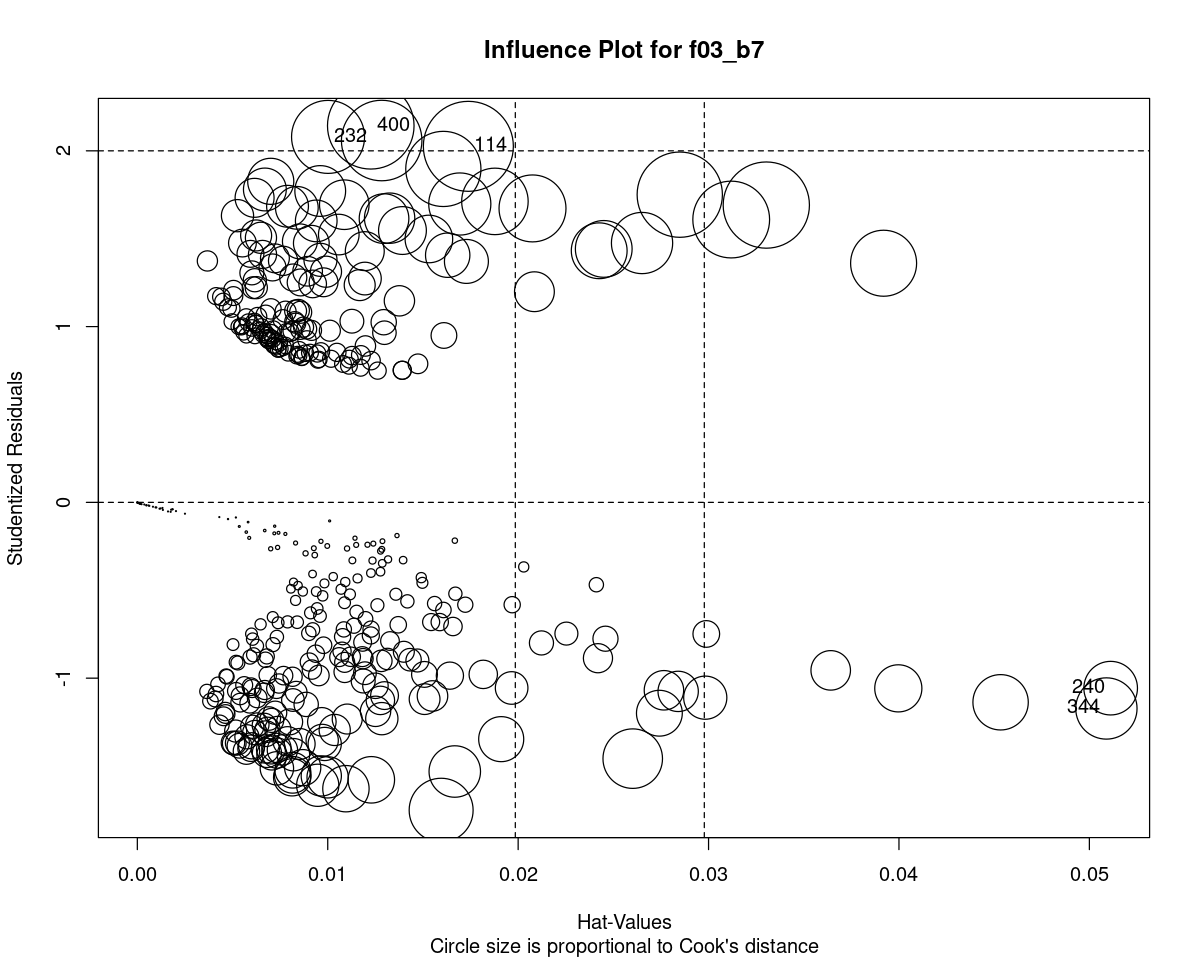

In [80]:
options(repr.plot.width= 10, repr.plot.height= 8)

# influencePlot is from the car package.
influencePlot(f03_b7, main="Influence Plot for f03_b7", 
              sub= "Circle size is proportional to Cook's distance")


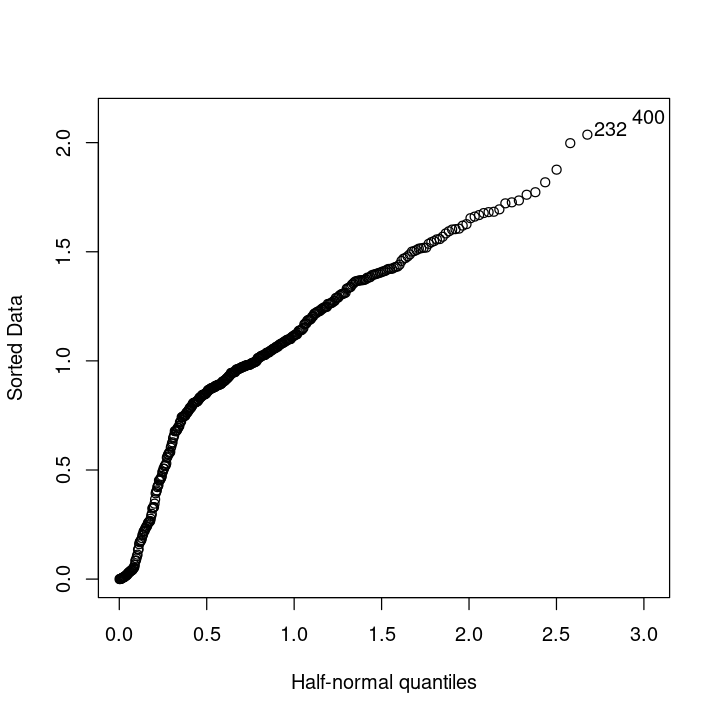

In [82]:
options(repr.plot.width= 6, repr.plot.height= 6)

halfnorm(residuals(f03_b7), labs=rownames(dfb))


In [83]:
# If we remove the last 3 influential points that are also
# outliers, our dataset will have been trimmed from 408 
# records down to 400, a reduction of nearly 2%.
# Let's see what kind of difference this makes for our
# linear model.

tmpdat <- dfb[which(!(rownames(dfb) %in% c(400, 232, 114))),]
nrow(tmpdat)


[1] 400

In [84]:
# Our Rsqrd measure increases by 2.2%.

f03_b8 <- glm(Outcome ~ 
             
             Daysrec + 
             CK + 
             I(log(AST)),
             
            data= tmpdat, family= binomial)
summary(f03_b8)
print(get_RsqrdDev(f03_b8))
# [1] 0.3565



Call:
glm(formula = Outcome ~ Daysrec + CK + I(log(AST)), family = binomial, 
    data = tmpdat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.752  -0.943  -0.186   0.943   2.160  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  2.89e+00   1.01e+00    2.85   0.0044
Daysrec     -1.03e-01   7.19e-02   -1.44   0.1507
CK          -3.15e-04   7.84e-05   -4.02  5.9e-05
I(log(AST)) -4.55e-01   2.15e-01   -2.11   0.0346

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 528.22  on 399  degrees of freedom
Residual deviance: 407.04  on 396  degrees of freedom
AIC: 415

Number of Fisher Scoring iterations: 7


[1] 0.3565


In [85]:
# Update our working dataframe.

dfb <- tmpdat


In [86]:
# Save the file.  dfb has 400 records in it.

write.csv(dfb, file="/home/greg/Documents/stat/github_repos/cows/downer.csv",
         row.names= TRUE)


#### Check model f03_b8 for overdispersion

In [87]:
# If the following value is close to 1, the dispersion is
# close to what our model assumes it to be.  Thus, no 
# need to correct for overdispersion.

phi <- deviance(f03_b8)/df.residual(f03_b8)
print(round(phi, 3))


[1] 1.028


In [89]:
# See p.311 of Kabacoff's "R in Action".  The null hypothesis
# is that the dispersion (phi) = 1.  The alternative hypothesis
# is that phi != 1.  If the following p-value is small (e.g.,
# < 0.05), we have good evidence for rejecting the null 
# hypothesis.

f03b8_od <- glm(Outcome ~ Daysrec + CK + I(log(AST)),  
            data= dfb, family= quasibinomial)

ans <- pchisq(summary(f03b8_od)$dispersion * f03_b8$df.residual,
              f03_b8$df.residual, lower= FALSE)
round(ans, 4)
# 0.9884  (p-value)


[1] 0.9884

### Using anova output, compute the importance of the f03 predictors

Here the importances of the predictors in the f03_b8 model are determined by their anova contributions.  Since there are 3 terms in the model and the order of the terms matters, I need to use 6 different models and average over each term's anova contribution for each model.

This section is included because I am curious to see whether the weights we arrive at for our base k-means model (with only AST, CK, and Daysrec as predictors) are at all like these anova weights.


                                     * * * * *

In [90]:
# f03_b8 is our base model.  It is built on all 400 remaining records.

f03_anova <- anova(f03_b8)
print(f03_anova)


Analysis of Deviance Table

Model: binomial, link: logit

Response: Outcome

Terms added sequentially (first to last)


            Df Deviance Resid. Df Resid. Dev
NULL                          399        528
Daysrec      1     14.0       398        514
CK           1    102.7       397        412
I(log(AST))  1      4.5       396        407


In [91]:
names(f03_anova)


[1] "Df"         "Deviance"   "Resid. Df"  "Resid. Dev"

In [136]:
rownames(f03_anova)


[1] "NULL"        "Daysrec"     "CK"          "I(log(AST))"

In [92]:
ss01 <- f03_anova$'Deviance'

names(ss01) <- c("null","Daysrec","CK","AST")
ss01tot <- sum(as.numeric(ss01[2:4]))
print(round(ss01tot, 4))


[1] 121.17


In [93]:
dayrec_percent <- round(ss01["Daysrec"]/ss01tot, 4)
ck_percent <- round(ss01["CK"]/ss01tot, 4)
ast_percent <- round(ss01["AST"]/ss01tot, 4)

ss01_contribs <- c(dayrec_percent, ck_percent, ast_percent)
print(ss01_contribs)


Daysrec      CK     AST 
 0.1152  0.8474  0.0374 


In [161]:
# Function for gauging the importance of the predictors
# in a model based on each predictor's anova contribution.
# As currently written, this function will not work if our 
# model contains interaction terms.  This function is 
# specific to the f03 series of models.

get_f03contribs <- function(dat) {
    
    # NOTE: the columns in dat must have the power
    # transformations used in the model.  The first
    # column of dat must be the model response variable.
    
    preds <- colnames(dat)[-1]
    resp <- colnames(dat)[1]
    
    # get all permutations of the predictors;
    n <- length(preds)
    perm_matrix <- gtools::permutations(n, n, preds)
    
    # create result vector for predictor contributions
    result <- rep(0, n)
    names(result) <- preds
    
    for(i in 1:nrow(perm_matrix)) {
        
        pred_str <- paste(perm_matrix[i,], collapse= "+")
        form <- as.formula(paste(as.character(resp), " ~ ", pred_str, sep=""))
        
        modl <- glm(form, family= binomial, data= dat)
        
        # The anova function calls glm.fit in a way that it sometimes
        # produces warnings: "glm.fit: fitted probabilities numerically 0 or 1 occurred"
        modl_anova <- suppressWarnings(anova(modl))
        
        ss <- modl_anova$'Deviance'
        names(ss) <- rownames(modl_anova)
        ss_total <- round(sum(as.numeric(ss[-1])), 2)
        percents <- round(ss[-1]/ss_total, 6)
        names(percents) <- names(ss)[-1]
        
        # accumulate results
        for(name in names(result)) {
            
            result[name] <- as.numeric(result[name]) + as.numeric(percents[name])
        }
        
    } # end of for-loop
    
    return(round(result/nrow(perm_matrix), 4))
}


In [139]:
# Create the dataframe for use with get_f03contribs.

tmpdat <- dfb
tmpdat$AST <- log(tmpdat$AST)
dim(tmpdat)
colnames(tmpdat)


[1] 400   4

[1] "Outcome" "Daysrec" "CK"      "AST"

In [162]:
# The following weights are obtained using all 400 records.
# These weights will be tested in Section 2 to see if they
# can improve upon the basic k-means model, i.e., one without
# weights.

ans <- get_f03contribs(tmpdat)
print(ans)
#  Daysrec      CK     AST 
#   0.0528  0.5646  0.3827

print(sum(ans))
# [1] 1.0001


Daysrec      CK     AST 
 0.0528  0.5646  0.3827 
[1] 1.0001


### Comments on anova weights

The anova weights are significantly different from the best weights for the k-means model of this Part 1 and from the best weights for the k-means model of the Part2 notebook that follows.  (Part 2 also works with the cow data.)

The Part 1 k-means weights are: AST= 0.54; CK= 0.28; Daysrec=0.18

The Part 2 k-means weights are: AST= 0.59; CK= 0.27; Daysrec= 0.14


We see further downstream how these weights are obtained.


### Create training and test sets (320 rcds/ 80 rcds)

In [ ]:
# For Part 1 of this project, I want the ratio 
# of surviving to non-surviving cows to be the 
# same in each of the two sets.  In Part 2 of
# this project, this constraint is removed.

# Since the test set provides us with only a single
# data point for model comparison, in Part 2 of this
# project I no longer use a test set and simply 
# rely on cross-validation scores taken over a very
# large number of folds (5000 in this case).


In [22]:
dfb <- rbind(traindat, testdat)
dim(dfb)
colnames(dfb)


[1] 400   4

[1] "Outcome" "Daysrec" "CK"      "AST"

In [29]:
# We keep only Outcome, Daysrec, CK, and AST.  80% of the 
# records are assigned to the training set.

set.seed(5491)

# shuffle dfb
smp <- sample(rownames(dfb), dim(dfb)[1], replace= FALSE)
dfb <- dfb[smp, c("Outcome","AST","CK","Daysrec")]
        
# Get ratio of surviving to non-surviving cows.
dfb_surv <- dfb[which(dfb$Outcome==1),]
dfb_nonSurv <- dfb[which(dfb$Outcome==0),]
surv_ratio <- nrow(dfb_surv)/nrow(dfb)

segmentsv <- c(320, 80)

row_list <- vector("list", length=2)
used_surv <- used_nonSurv <- c()
    
for(k in 1:2) {
    surv_count <- round(surv_ratio * segmentsv[k])
    nonSurv_count <- segmentsv[k] - surv_count
    avail_survRows <- rownames(dfb_surv)[which(!(rownames(dfb_surv) %in% used_surv))]
    avail_nonSurvRows <- rownames(dfb_nonSurv)[which(!(rownames(dfb_nonSurv) %in% used_nonSurv))]
        
    if(k < 2) {
        smp01 <- sample(avail_survRows, surv_count, replace=FALSE)
        smp02 <- sample(avail_nonSurvRows, nonSurv_count, replace=FALSE)
    } else {
        smp01 <- avail_survRows
        smp02 <- avail_nonSurvRows
        stopifnot(length(c(smp01, smp02))== segmentsv[k])
    }
    used_surv <- c(used_surv, smp01)
    used_nonSurv <- c(used_nonSurv, smp02)
    row_list[[k]] <- c(smp01, smp02)
} # end of for-loop, index k

testdat <- dfb[row_list[[2]],]
traindat <- dfb[which(!(rownames(dfb) %in% rownames(testdat))),]
dim(traindat)
dim(testdat)


[1] 320   4

[1] 80  4

In [30]:
# This is as close as we can get the ratios.

ans <- table(as.factor(traindat$Outcome))
round(as.numeric(ans["1"])/(as.numeric(ans["1"]) + as.numeric(ans["0"])), 4)
# 0.3719

ans <- table(as.factor(testdat$Outcome))
round(as.numeric(ans["1"])/(as.numeric(ans["1"]) + as.numeric(ans["0"])), 4)
# 0.375


[1] 0.3719

[1] 0.375

In [34]:
# Save the training and test sets.

write.csv(traindat, file="/home/greg/Documents/stat/github_repos/cows/downer_train_320rcds.csv",
         row.names= TRUE)

write.csv(testdat, file="/home/greg/Documents/stat/github_repos/cows/downer_test_80rcds.csv",
         row.names= TRUE)


# Section 2: Four different classification models

## Logistic regression: final model (g03)

When observations with missing values are removed from the original 435 record dataset, we are left with 408 records.  Above I then constructed a linear model on these 408 records and found 8 of them to be outliers (relative to my model), some of which were also influential.  These 8 records were removed from the dataset.  In this section I now construct a model on a subset of the 400 remaining records.

This is not the normal approach to working with data.  The removal of the model-based outliers may favor the logistic regression model over the other models looked at when comparing performance scores on the testset data  However, since there is often an overlap between variable-relative outliers and model-based outliers, all models should do better on this subset of 400 remaining records, particularly the k-means model.

Also, much of the model comparison that follows will be done using cross-validation scores on folds of the training set.  This is how we would do model selection in practice.  Applying the models to the testset data is not all that helpful for comparing model performance because the amount of data we have to work with is so small.  The cross-validation scores obtained below provide a much better measure of model generalizability.

In [ ]:
#&* Bookmark

In [4]:
traindat <- read.csv("/home/greg/Documents/stat/github_repos/cows/downer_train_320rcds.csv",
                    row.names= 1, header= TRUE)
dim(traindat)


[1] 320   4

In [5]:
testdat <- read.csv("/home/greg/Documents/stat/github_repos/cows/downer_test_80rcds.csv",
                    row.names= 1, header= TRUE)
dim(testdat)


[1] 80  4

In [5]:
print(head(traindat))


    Outcome  AST    CK Daysrec
331       1  183   325       7
201       1  117  3300       1
161       0 1133 39000       3
283       0   73   130       0
404       0   60   482       0
121       0  130   230       2


In [7]:
# I am satisfied with the current power transformations.

g03 <- glm(Outcome ~ Daysrec + CK + I(log(AST)),
           data= traindat, family= binomial)
summary(g03)
print(get_RsqrdDev(g03))
# [1] 0.3585



Call:
glm(formula = Outcome ~ Daysrec + CK + I(log(AST)), family = binomial, 
    data = traindat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.748  -0.912  -0.179   0.945   2.127  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  2.82e+00   1.11e+00    2.53   0.0115
Daysrec     -9.74e-02   8.01e-02   -1.22   0.2237
CK          -3.10e-04   8.57e-05   -3.62   0.0003
I(log(AST)) -4.37e-01   2.34e-01   -1.87   0.0615

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 422.37  on 319  degrees of freedom
Residual deviance: 324.84  on 316  degrees of freedom
AIC: 332.8

Number of Fisher Scoring iterations: 7


[1] 0.3585


In [ ]:
#&* Bookmark

In [8]:
# Function to compute f-score for a 2x2 confusion matrix.

get_fscore <- function(mat) {
    
    FN <- as.numeric(mat[2,1])
    TP <- as.numeric(mat[2,2])
    FP <- as.numeric(mat[1,2])
    recall <- TP/(TP + FN)
    precision <- TP/(TP + FP)
    f_score <- 2* (recall*precision)/(recall + precision)
    return(round(f_score, 4))
}


In [9]:
# Function to output a confusion matrix and the f-score 
# for that matrix (if it is 2x2).

get_confusion <- function(preds, df_actual) {
    
    # df_actual is a one-column dataframe;
    # preds is a named vector of predictions;
    # preds is of type factor; it is assumed there
    # are at least 2 factor levels
    
    levs <- levels(preds)
    n_levs <- length(levs)
    if(n_levs== 1) { levs <- c('0', '1') }
    n_levs <- max(n_levs, 2)
    actual <- as.vector(df_actual[, 1])
    names(actual) <- rownames(df_actual)
    
    datout <- rep(0, n_levs * (n_levs + 1))
    dim(datout) <- c(n_levs, n_levs + 1)
    datout <- as.data.frame(datout)
    colnames(datout) <- c(levs, "class.error")
    rownames(datout) <- levs
    
    result <- vector("list", length= 2)
    names(result) <- c("matrix","f_score")
    
    # for each factor level, identify the rcd names
    # which should be classed as such
    for(rowlev in levs) {
        actlev_names <- names(actual[actual == rowlev])
        # columns are for the predicted values:
        for(collev in levs) {
            predlev_names <- names(preds[preds == collev])
            if(length(predlev_names > 0)) {
                datout[rowlev, collev] <- sum(predlev_names %in% actlev_names)
            }
        }
        nonrow_cols <- levs[!(levs %in% rowlev)]
        datout[rowlev, "class.error"] <- round(sum(as.vector(datout[rowlev, nonrow_cols]))/
                                               sum(as.vector(datout[rowlev, levs])), 4)
    }
    
    result$matrix <- datout
    if(n_levs == 2) {
        result[[2]] <- get_fscore(as.matrix(datout))
    } else {
        result$f_score <- NA
    }
    
    return(result)
}


In [40]:
preds <- predict(g03, newdata= traindat, type="response")
print(round(head(preds), 3))


  331   201   161   283   404   121 
0.439 0.405 0.000 0.711 0.706 0.604 


In [41]:
preds_transf <- preds
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
table(as.factor(preds_transf))



  0   1 
201 119 

In [42]:
print(head(preds_transf))
print(tail(preds_transf))


331 201 161 283 404 121 
  0   0   0   1   1   1 
 60  39 120 363  63 208 
  1   1   1   1   0   0 


In [43]:
preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, traindat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for model g03, trainset (320 rcds): ", as.character(ans[[2]]), sep=""))
# 0.6387

# Accuracy = 73.125%

# NOTE the even split between false positives and false negatives.

# Type 2 is 0.6757


    0  1 class.error
0 158 43      0.2139
1  43 76      0.3613


[1] ""

[1] "f-score for model g03, training set: 0.6387"


In [44]:
# Get g03's scores on the testset of 80 records.

preds <- predict(g03, newdata= testdat, type="response")
preds_transf <- preds
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0

preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, testdat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for model g03, testset (80 rcds): ", as.character(ans[[2]]), sep=""))
# 0.6129

# Accuracy = 0.70

# Type2 = 0.6477

# Again note the near-even split betw. FPs and FNs.


   0  1 class.error
0 37 13      0.2600
1 11 19      0.3667


[1] ""

[1] "f-score for model g03, testset (80 rcds): 0.6129"


## Random forest classifier (first look)

In [45]:
# Output of the random forest model is dependent on
# the initial seed value.

set.seed(123)
rfclf <- randomForest(I(as.factor(Outcome)) ~ ., data= traindat,
                      ntree= 100, mtry= 1, nodesize= 1)
print(rfclf)
''
print(get_fscore(as.matrix(rfclf$confusion)))
# [1] 0.6043



Call:
 randomForest(formula = I(as.factor(Outcome)) ~ ., data = traindat,      ntree = 100, mtry = 1, nodesize = 1) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 1

        OOB estimate of  error rate: 29.06%
Confusion matrix:
    0  1 class.error
0 156 45     0.22388
1  48 71     0.40336


[1] ""

[1] 0.6043


In [46]:
preds <- predict(rfclf, newdata= testdat, type="response")
print(head(preds))


357 148 305 105 358 214 
  1   0   1   0   1   1 
Levels: 0 1


In [47]:
# f-score on the test set data:

ans <- get_confusion(preds, testdat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for model rfclf, test set (80 rcds): ", 
            as.character(ans[[2]]), sep=""))
# 0.5672

# Accuracy: 63.75%

# Type2 score: 0.5953


   0  1 class.error
0 32 18      0.3600
1 11 19      0.3667


[1] ""

[1] "f-score for model rfclf, test set (80 rcds): 0.5672"


## Gradient boosting classifier (first look)

In [ ]:
# For this project, I am using package gbm instead of
# xgboost.  When I work with the wine dataset in Part 4,
# I use xgboost.

require(gbm)


,var,rel.inf
,<chr>,<dbl>
AST,AST,45.7640
CK,CK,45.1344
Daysrec,Daysrec,9.1016


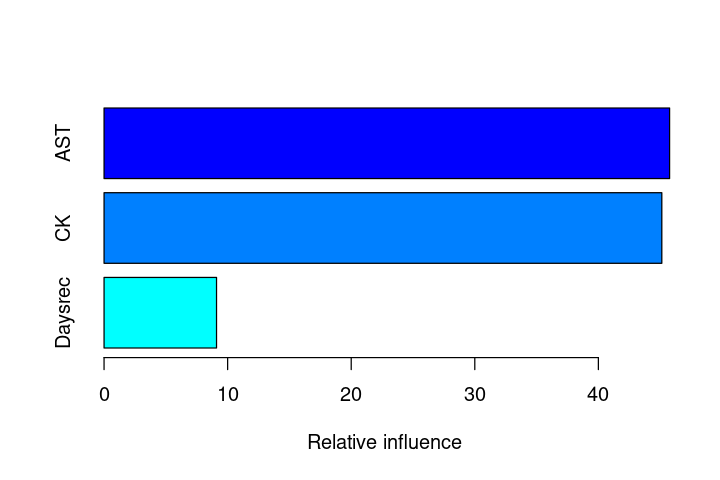

In [36]:
# The output of this model is also dependent on the initial
# seed value.

options(repr.plot.width= 6, repr.plot.height= 4)

set.seed(123)
gbclf <- gbm(Outcome ~ ., data= traindat, n.trees= 100,
             distribution= "bernoulli", shrinkage= 0.1)
summary(gbclf)


In [49]:
print(head(gbclf$fit))


[1] -0.519449  0.014567 -3.100410  0.950114  0.671527  0.446661


In [50]:
print(head(exp(gbclf$fit)/(1 + exp(gbclf$fit))))


[1] 0.37298 0.50364 0.04309 0.72114 0.66185 0.60985


In [51]:
preds <- suppressMessages(predict(gbclf, newdata= traindat, type="response"))
print(head(preds))


[1] 0.37298 0.50364 0.04309 0.72114 0.66185 0.60985


In [52]:
preds_transf <- preds
names(preds_transf) <- rownames(traindat)
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
table(as.factor(preds_transf))



  0   1 
210 110 

In [53]:
preds_transf <- as.factor(preds_transf)
print(head(preds_transf))


331 201 161 283 404 121 
  0   1   0   1   1   1 
Levels: 0 1


In [54]:
ans <- get_confusion(preds_transf, traindat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for gbclf, training set (320 rcds): ", as.character(ans[[2]]), sep=""))
# 0.6725

# Note the uneven split between false positives and false negatives.


    0  1 class.error
0 168 33      0.1642
1  42 77      0.3529


[1] ""

[1] "f-score for gbclf, training set (320 rcds): 0.6725"


In [55]:
# Increase the number of trees in the model and increase the shrinkage.
# (This model is likely too complex.)

set.seed(123)
gbclf <- gbm(Outcome ~ ., data= traindat, n.trees= 1000,
             distribution= "bernoulli", shrinkage= 0.3)
preds <- suppressMessages(predict(gbclf, newdata= traindat, type="response"))

preds_transf <- preds
names(preds_transf) <- rownames(traindat)
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
preds_transf <- as.factor(preds_transf)

ans <- get_confusion(preds_transf, traindat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for model gbclf, training set: ", as.character(ans[[2]]), sep=""))
# 0.8548


    0   1 class.error
0 182  19      0.0945
1  16 103      0.1345


[1] ""

[1] "f-score for model gbclf, training set: 0.8548"


## Optimize the rf and gbrt models using cross-validation scores

In [ ]:
#&* Bookmark

In [135]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from get_cvScore.

get_Type2_score <- function(traindat, testdat, classifier, ntrees,
                            shrinkage) {
    
    if(classifier == 'randomforest') {
        
        rfmod <- randomForest(I(as.factor(Outcome)) ~ ., 
                              data= traindat, ntree= ntrees,
                              mtry= 1, nodesize= 1)
        
        preds <- predict(rfmod, newdata= testdat, type="response")
        ans <- get_confusion(preds, testdat[, "Outcome", drop=FALSE])
    }
    
    if(classifier == 'gradientboost') {
        
        gbmod <- suppressMessages(gbm(Outcome ~ ., data= traindat, n.trees= ntrees,
                                      distribution= "bernoulli", shrinkage= shrinkage))
        
        preds <- suppressMessages(predict(gbmod, newdata= testdat, type="response"))
        preds_transf <- preds
        names(preds_transf) <- rownames(testdat)
        preds_transf[which(preds_transf >= 0.5)] <- 1
        preds_transf[which(preds_transf < 0.5)] <- 0
        preds_transf <- as.factor(preds_transf)
        ans <- get_confusion(preds_transf, testdat[, "Outcome", drop=FALSE])
    }
    
    # Type2 score is a weighted average of accuracy and
    # the f-score.
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)
    return(result)
}


In [136]:
# Function to obtain a cross-validation score, averaging the
# Type2 scores of the folds.  Valid values for the classifier 
# argument are: 'randomforest' and 'gradientboost'.

get_cvScore <- function(seed, dat, classifier, ntrees,
                        folds= 5, shrinkage= 0.1) {
      
    #############################
    # Partition the data into folds, making sure
    # the ratio of survivors to non-survivors is
    # about the same for each traindat/valdat pair.
        
    # divide dat by the number of folds 
    segment_size <- round(dim(dat)[1]/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
        
    # shuffle dat
    set.seed(seed * 17)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
        
    # Get ratio of surviving to non-surviving cows.
    dat_surv <- dat[which(dat$Outcome==1),]
    dat_nonSurv <- dat[which(dat$Outcome==0),]
    surv_ratio <- round(nrow(dat_surv)/nrow(dat), 4)
    
    row_list <- vector("list", length=folds)
    used_surv <- used_nonSurv <- c()
    
    for(k in 1:folds) {
        surv_count <- round(surv_ratio * segmentsv[k])
        nonSurv_count <- segmentsv[k] - surv_count
        avail_survRows <- rownames(dat_surv)[which(!(rownames(dat_surv) %in% used_surv))]
        avail_nonSurvRows <- rownames(dat_nonSurv)[which(!(rownames(dat_nonSurv) %in% used_nonSurv))]
        
        if(k < folds) {
            smp01 <- sample(avail_survRows, surv_count, replace=FALSE)
            smp02 <- sample(avail_nonSurvRows, nonSurv_count, replace=FALSE)
        } else {
            smp01 <- avail_survRows
            smp02 <- avail_nonSurvRows
            stopifnot(length(c(smp01, smp02))== segmentsv[k])
        }
        used_surv <- c(used_surv, smp01)
        used_nonSurv <- c(used_nonSurv, smp02)
        row_list[[k]] <- c(smp01, smp02)
    } # end of for-loop, index k
    
    #############################
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    # With only 5 folds, we need only 5 cores.
    scores <- mcmapply(get_Type2_score, train_list, test_list,
                       MoreArgs= list(classifier= classifier, 
                                      ntrees= ntrees, shrinkage= shrinkage),
                       SIMPLIFY=TRUE, mc.cores=5)
    # The average is of Type2 scores.
    return(round(mean(scores), 5))
}


In [137]:
# Since the seed value is having such a big effect on the results,
# I take the average over a number of seeds.

avg_seed_scores <- function(seed_vector, traindat, classifier,
                            n_trees, shrinkage= 0.01, folds= 5) {
    
    seed_len <- length(seed_vector)
    outv <- rep(NA, seed_len)
    for(i in 1:seed_len) {
        seed <- seed_vector[i]
        if(classifier== 'randomforest') {
            outv[i] <- get_cvScore(seed, traindat, classifier, 
                                   n_trees, folds= folds)
        }
        if(classifier== 'gradientboost') {
            outv[i] <- get_cvScore(seed, traindat, classifier, n_trees, 
                                   folds=folds, shrinkage=shrinkage)
        }
    }
    return(round(mean(outv), 5))
}


In [138]:
# This grid search takes a vector of seeds as an argument.
# It is only for the random forest and gradient boosting 
# models.

gridSearch02 <- function(seed_vector, traindat, classifier, ntree_vector, 
                         shrinkage_vector= c(0.1), folds=5) {
    
    tree_len <- length(ntree_vector)
    shrink_len <- length(shrinkage_vector)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * tree_len * shrink_len)
    dim(datout) <- c((tree_len * shrink_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Type2")
    datout$params <- ""
    
    index <- 0
    for(i in 1:tree_len) {
        n_trees <- ntree_vector[i]
        
        if(classifier== 'gradientboost') {
            for(j in 1:shrink_len) {
                index <- index + 1
                shrinkage <- shrinkage_vector[j]
                param_string <- paste(as.character(n_trees), 
                                      as.character(shrinkage), sep= "--")
                datout$params[index] <- param_string
                datout$Type2[index] <- avg_seed_scores(seed_vector, traindat, classifier, n_trees, 
                                                        folds=folds, shrinkage=shrinkage)
            }
        }
        if(classifier== 'randomforest') {
            index <- index + 1
            datout$params[index] <- as.character(n_trees)
            datout$Type2[index] <- avg_seed_scores(seed_vector, traindat, classifier, 
                                                    n_trees, folds= folds)
        }
    }
    return(datout)
}


In [60]:
# Run grid search to get better parameters for the 
# random forest model.  Test with 90 seeds.

set.seed(7543)
seed_smp <- sample(1:9999, 90, replace=FALSE)
tree_vector <- c(50, 80, 100, 120, 130, 150, 200)

ans <- gridSearch02(seed_smp, traindat, 'randomforest', tree_vector) 

# NOTE: this best_param output is not that stable, even with
# 90 seeds.
(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '120'

(best_rf_Type2 <- round(ans[which(ans$Type2 == max(ans$Type2)),]$Type2, 4))
# 0.6436


[1] "120"

[1] 0.6436

In [61]:
# Test with 120 seeds.

set.seed(7543)
seed_smp <- sample(1:9999, 120, replace=FALSE)
tree_vector <- c(80, 100, 120, 130, 150, 200)

ans <- gridSearch02(seed_smp, traindat, 'randomforest', tree_vector) 

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '120'

(best_rf_Type2 <- round(ans[which(ans$Type2 == max(ans$Type2)),]$Type2, 4))
# 0.6428


[1] "120"

[1] 0.6428

In [62]:
# Using 120 seed output here.
ans


params,Type2
<chr>,<dbl>
80,0.63954
100,0.64064
120,0.64276
130,0.64203
150,0.64253
200,0.64193


### Best random forest classifier: rfclf_best

In [63]:
# We are interested in the feature importances based on the
# training data.

set.seed(123)
rfclf_best <- randomForest(I(as.factor(Outcome)) ~ ., data= traindat, 
                           ntree= 120, mtry= 1, nodesize= 1,
                           importance= TRUE)
print(rfclf_best)
''
print(get_fscore(as.matrix(rfclf_best$confusion)))
# [1] 0.5983  (f-score on traindat)

# Accuracy is 0.70625 (training set)

# Type2 is 0.6415



Call:
 randomForest(formula = I(as.factor(Outcome)) ~ ., data = traindat,      ntree = 120, mtry = 1, nodesize = 1, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 120
No. of variables tried at each split: 1

        OOB estimate of  error rate: 29.38%
Confusion matrix:
    0  1 class.error
0 156 45     0.22388
1  49 70     0.41176


[1] ""

[1] 0.5983


In [64]:
# Get f-score on the testset (80 rcds) using this model.

preds <- predict(rfclf_best, newdata= testdat, type="response")
ans <- get_confusion(preds, testdat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for rfclf_best, test set (80 rcds): ", 
            as.character(ans[[2]]), sep=""))
# 0.5758

# Accuracy = 0.65

# Type2 = 0.6055

### NOTE: the above scores are seed-dependent.


   0  1 class.error
0 33 17      0.3400
1 11 19      0.3667


[1] ""

[1] "f-score for rfclf_best, test set (80 rcds): 0.5758"


In [ ]:
### COMMENTS:

# We can see from the following plot why there might be
# some difficulty distinguishing between the 2 levels of
# Outcome in the test data set.  (Compare this plot with
# the other 3 plots that follow.)  The two levels might
# be easier to separate after we introduce the Daysrec 
# dimension.


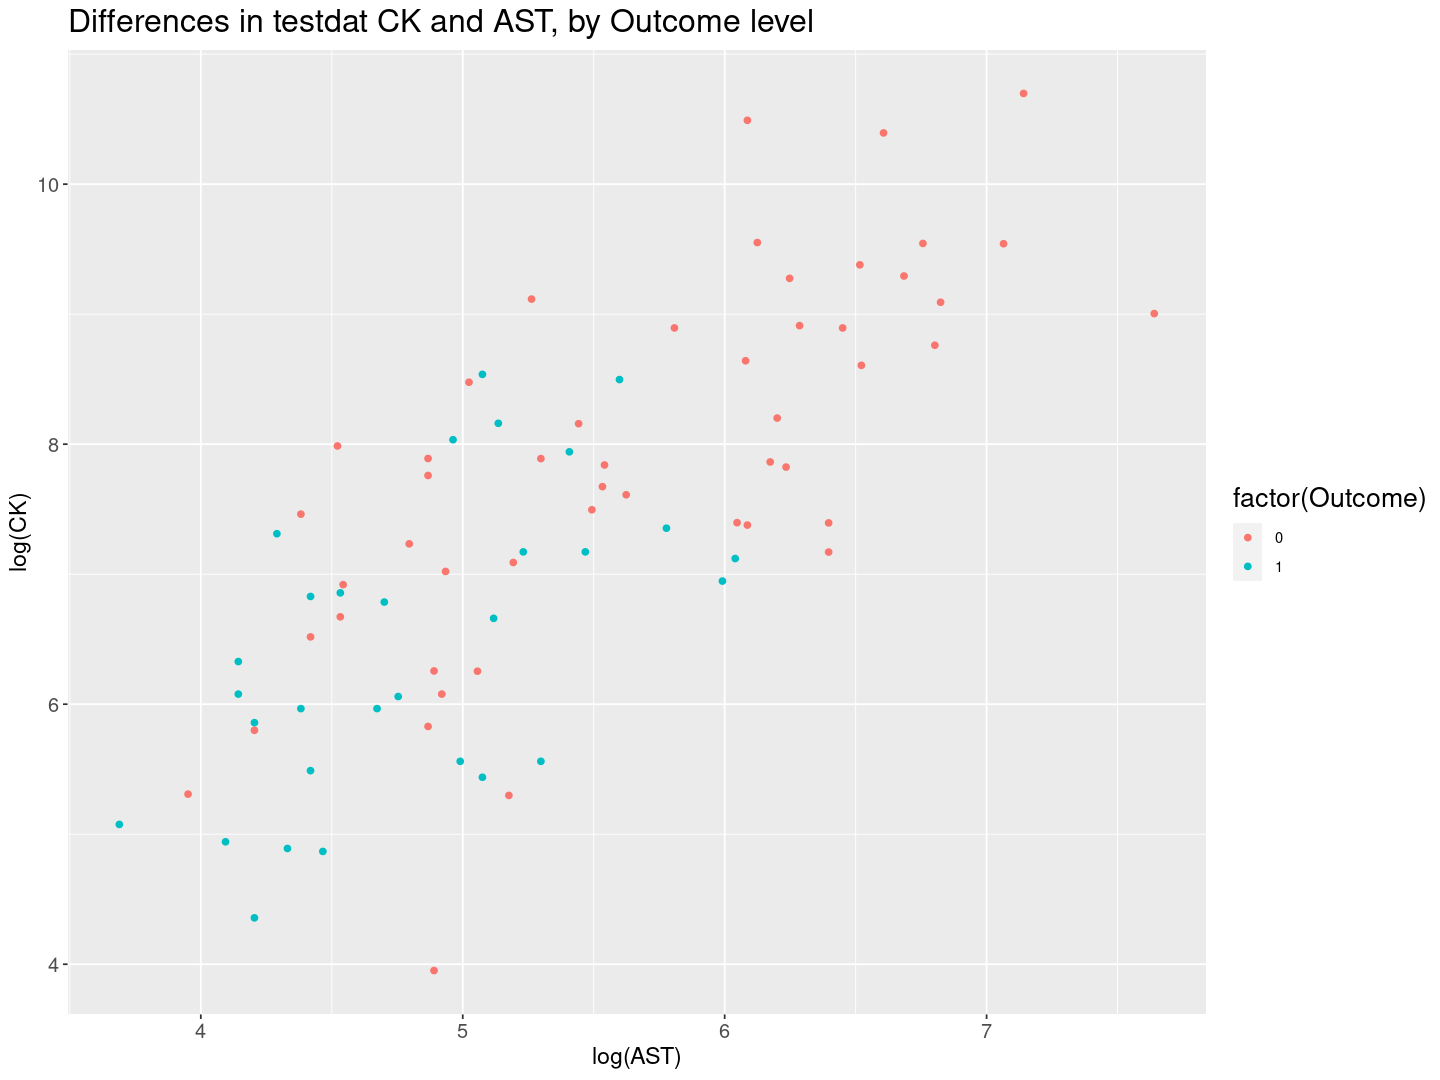

In [11]:
# Plot the test data to get a sense of the degree of 
# separation between the two levels of testdat$Outcome.

# Transform data for plotting.
dat_plot <- testdat
dat_plot$AST <- log(dat_plot$AST)
dat_plot$CK <- log(dat_plot$CK)

options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(AST, CK, color= factor(Outcome))) +

  geom_point(alpha= 1.0) +
  xlab("log(AST)") + ylab("log(CK)") +
  ggtitle("Differences in testdat CK and AST, by Outcome level") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENT:

# The above plot is only one perspective on the degree
# of separation between the levels of Outcome.  We still 
# have another dimension to work with: Daysrec.


### Best logistic regression model: test set score

In [66]:
# Compare the random forest f-score on the test set with that 
# from our logistic regression model.

preds <- preds_transf <- predict(g03, newdata= testdat, type="response")
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0

preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, testdat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for model g03, test set (80 rcds): ", as.character(ans[[2]]), sep=""))
# 0.6129

# Accuracy is 0.70

# Type2 is 0.6477

### The current test set favors the logistic regression model.


   0  1 class.error
0 37 13      0.2600
1 11 19      0.3667


[1] ""

[1] "f-score for model g03, test set (80 rcds): 0.6129"


In [ ]:
### COMMENT:

# If we rely only on this one test set, the  
# logistic regression model is significantly
# outperforming the random forest model.  It may
# be that the logistic regression model has an
# advantage because the 8 outliers that were
# removed were outliers from the perspective
# of logistic regression modeling.

# This difference in performance remains between 
# the 2 models even after we average scores for
# the best random forest model over 300 seeds.
# See below.  Average scores over 1000 seeds are
# also shown at the end of this notebook.


In [67]:
print(round(rfclf_best$importance, 3))


             0     1 MeanDecreaseAccuracy MeanDecreaseGini
AST      0.043 0.112                0.068           50.986
CK       0.028 0.083                0.047           49.026
Daysrec -0.009 0.058                0.015           15.443


In [ ]:
# We can compute "feature importances" based on the Gini
# measure.  I want the weights to sum to 1.  So we have:

# Daysrec = 14%; CK = 42%; AST = 44%


### Best gradient boosting classifier: gbclf_best

In [139]:
# Run grid search to get better parameters for the 
# gradient boosting model.  This test is with 200 seeds.

set.seed(7543)
seed_smp <- sample(1:9999, 200, replace=FALSE)
tree_vector <- c(60, 80, 100, 120, 130)
shrinkage_vector <- c(0.01, 0.02, 0.03, 0.04, 0.05) 

start <- Sys.time()
ans <- gridSearch02(seed_smp, traindat, 'gradientboost', ntree_vector=tree_vector, 
                    shrinkage_vector=shrinkage_vector, folds=5) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.81 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2, na.rm=TRUE)),]$params)
# '130--0.02'

(best_gb_Type2 <- ans[which(ans$Type2 == max(ans$Type2, na.rm=TRUE)),]$Type2)
# 0.6605


Time difference of 2.81 mins

[1] "130--0.02"

[1] 0.66051

,var,rel.inf
,<chr>,<dbl>
CK,CK,54.5614
AST,AST,42.6191
Daysrec,Daysrec,2.8195


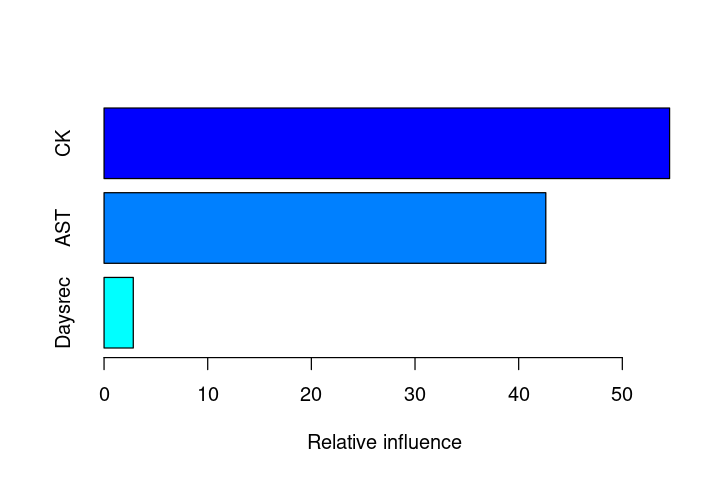

In [140]:
# Again, we are interested in the feature importances for
# the training data.

options(repr.plot.width= 6, repr.plot.height= 4)

set.seed(123)
gbclf_best <- gbm(Outcome ~ ., data= traindat, n.trees= 130,
                  distribution= "bernoulli", shrinkage= 0.02)
summary(gbclf_best)


In [141]:
# Get f-score on the training set for gbclf_best.

preds <- suppressMessages(predict(gbclf_best, newdata= traindat, type="response"))
preds_transf <- preds
names(preds_transf) <- rownames(traindat)
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, traindat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for gbclf_best, trainset (320 rcds): ", as.character(ans[[2]]), sep=""))
# 0.6372

# Accuracy is 0.74375

# Type2 is 0.6798


    0  1 class.error
0 166 35      0.1741
1  47 72      0.3950


[1] ""

[1] "f-score for gbclf_best, trainset (320 rcds): 0.6372"


In [142]:
# Get f-score on the test set for gbclf_best.

preds <- suppressMessages(predict(gbclf_best, newdata= testdat, type="response"))
preds_transf <- preds
names(preds_transf) <- rownames(testdat)
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, testdat[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for gbclf_best, test set (80 rcds): ", as.character(ans[[2]]), sep=""))
# 0.5938

# Accuracy is 0.675

# Type2 is 0.6263


   0  1 class.error
0 35 15      0.3000
1 11 19      0.3667


[1] ""

[1] "f-score for gbclf_best, test set (80 rcds): 0.5938"


## More stable scores for rfclf_best and gbclf_best

In [ ]:
### COMMENT:

# In order to get more stable scores for the random forest 
# and gradient boost models, I need to average scores for
# the best models over many different seeds.  This is done
# in the following cells.  (Here each individual score is
# a score on the test set.  The point is to get a more
# accurate comparison to the g03 logistic model; for the 
# moment, this comparison is made using only the testset
# data.)


In [143]:
dim(traindat)
summary(traindat[, -1])


[1] 320   4

      AST             CK           Daysrec    
 Min.   :  33   Min.   :   13   Min.   :0.00  
 1st Qu.: 124   1st Qu.:  585   1st Qu.:0.00  
 Median : 244   Median : 1800   Median :1.00  
 Mean   : 408   Mean   : 5595   Mean   :1.69  
 3rd Qu.: 490   3rd Qu.: 5254   3rd Qu.:3.00  
 Max.   :2533   Max.   :71000   Max.   :7.00  

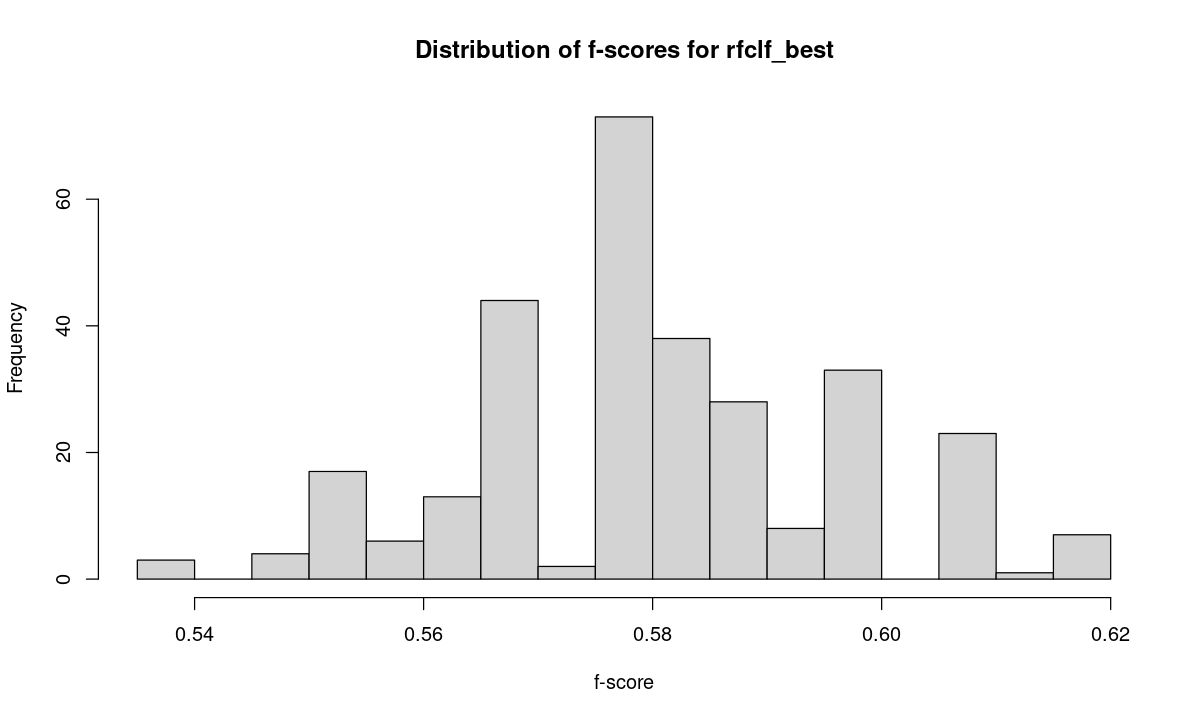

In [150]:
# Get more stable scores on the testset data for the best
# random forest model.

set.seed(1433)
seed_smp <- sample(1:9999, 300, replace=FALSE)


datout <- rep(NA, 6 * length(seed_smp))
dim(datout) <- c(length(seed_smp), 6)
datout <- as.data.frame(datout)
colnames(datout) <- c("seed","fscore","Acc","Type2", "FN","FP")
datout$seed <- seed_smp

for(i in 1:length(seed_smp)) {
    
    set.seed(seed_smp[i])
    rfmod <- randomForest(I(as.factor(Outcome)) ~ ., 
                              data= traindat, ntree=120,
                              mtry= 1, nodesize= 1)
        
    preds <- predict(rfmod, newdata= testdat, type="response")
    ans <- get_confusion(preds, testdat[, "Outcome", drop=FALSE])
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    datout[i, c("Acc")] <- round(percent_correct, 4)
    datout[i, c("fscore")] <- round(ans[[2]], 4)
    datout[i, c("Type2")] <- round(0.4*percent_correct + 0.6*as.numeric(ans[[2]]), 4)
    datout[i, c("FN")] <- as.numeric(mat[2,1])
    datout[i, c("FP")] <- as.numeric(mat[1,2])
}

options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$fscore, breaks=12, xlab="f-score",
     main="Distribution of f-scores for rfclf_best on testset")


In [151]:
# Get summaries from datout.  These are summaries for
# the best random forest classifier applied to the 
# testset, scores averaged over 300 seeds.

c(round(mean(datout$fscore), 4), round(mean(datout$Acc), 4),
  mean(datout$FN), mean(datout$FP))
# f-score:   0.5802   
# accuracy:  0.6527   
# false negatives: 10.80   
# false positives: 16.98


[1]  0.5802  0.6527 10.8033 16.9767

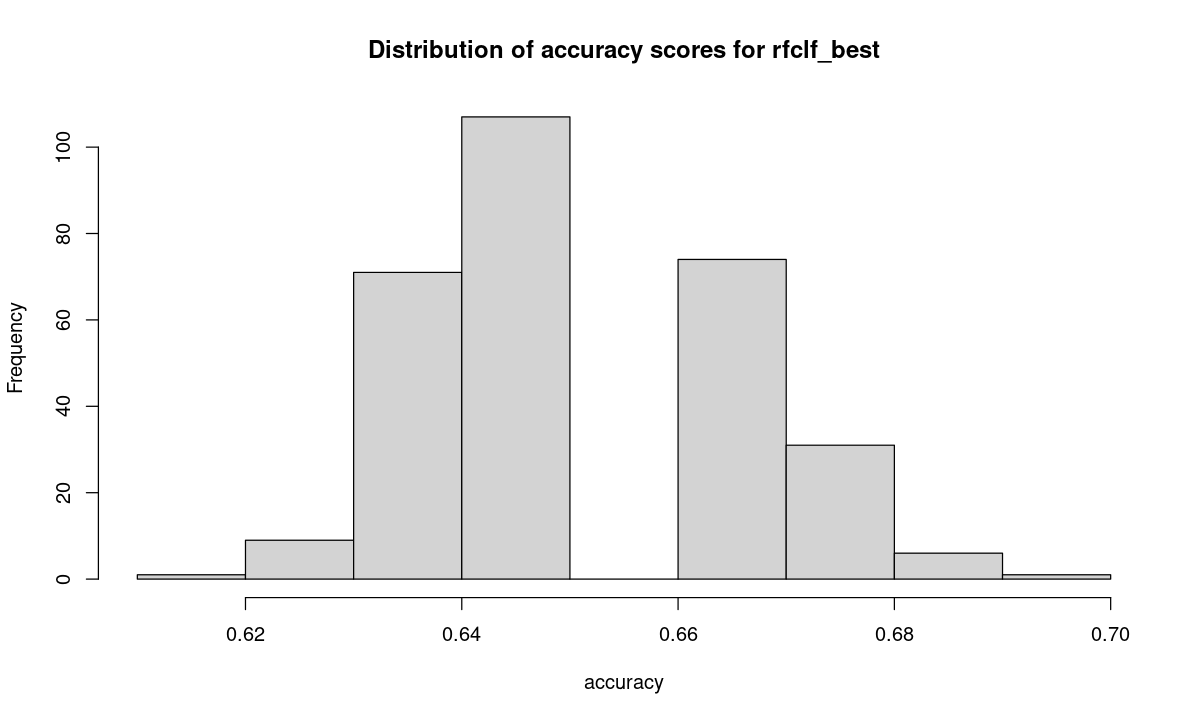

In [152]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Acc, breaks=8, xlab="accuracy",
     main="Distribution of accuracy scores for rfclf_best on testset")


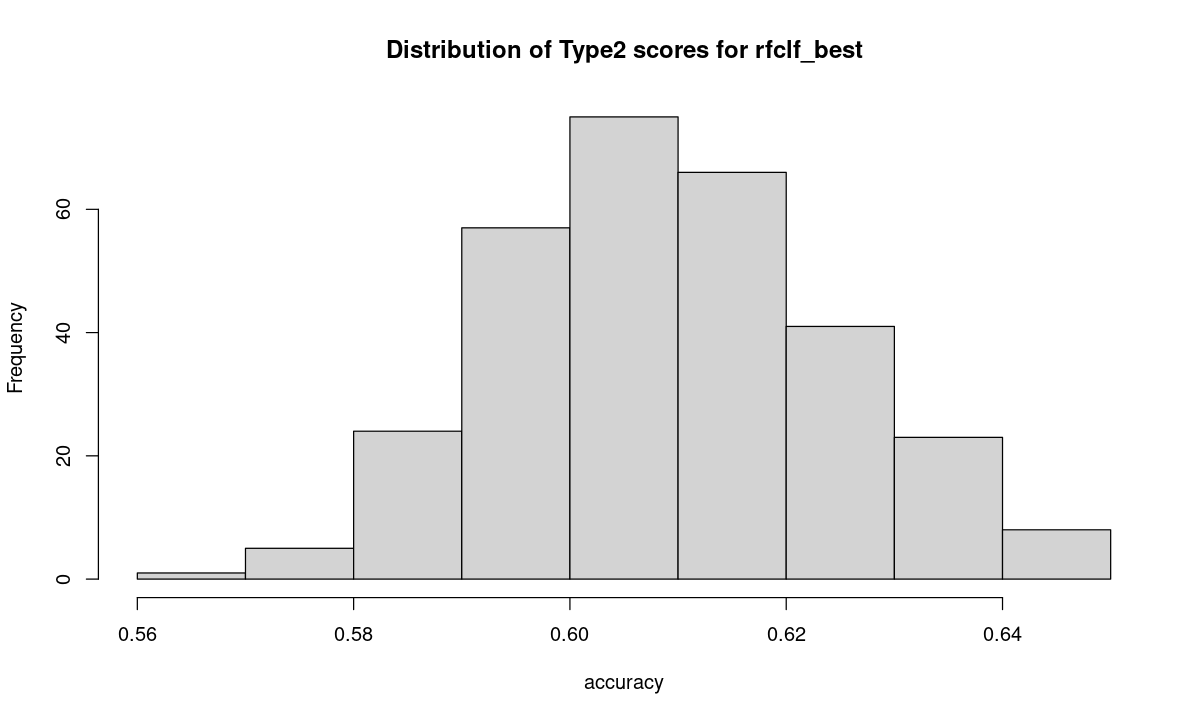

In [153]:
options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$Type2, breaks=10, xlab="Type2",
     main="Distribution of Type2 scores for rfclf_best on testset")


In [154]:
# Find out the seed that generates the best Type2
# score.

tmpdat <- datout[which(datout$Type2 > 0.642),]
tmpdat[, -1]


,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
33,0.6154,0.6875,0.6442,10,15
37,0.6154,0.6875,0.6442,10,15
59,0.6154,0.6875,0.6442,10,15
75,0.6154,0.6875,0.6442,10,15
153,0.6129,0.7000,0.6477,11,13
170,0.6154,0.6875,0.6442,10,15
298,0.6154,0.6875,0.6442,10,15


In [ ]:
# If we use seed = 153 we get the highest accuracy
# score and the best balance between false positives
# and false negatives.  (This is good considering 
# that the base k-means model has an imbalance: 3X
# as many false positives as false negatives.)


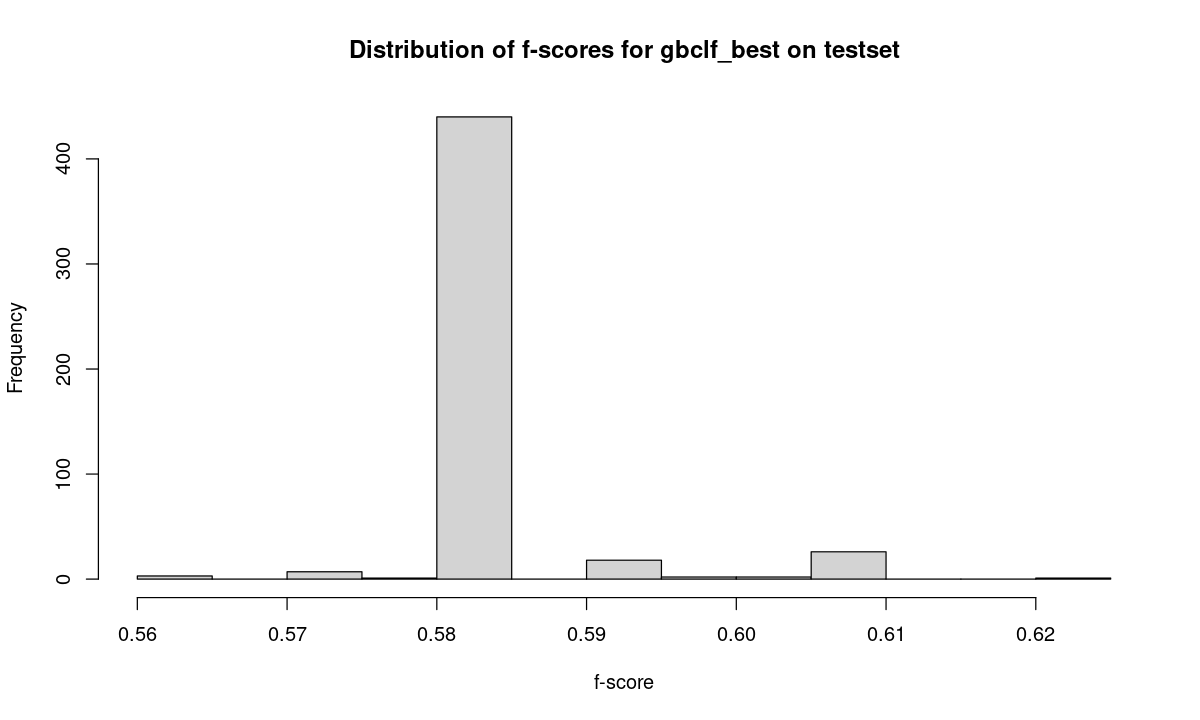

In [144]:
# Get more stable scores on the testset data for the
# best gradient boosting model.

set.seed(1433)
seed_smp <- sample(1:9999, 500, replace=FALSE)


datout <- rep(NA, 5 * length(seed_smp))
dim(datout) <- c(length(seed_smp), 5)
datout <- as.data.frame(datout)
colnames(datout) <- c("seed", "fscore","Acc","FN","FP")
datout$seed <- seed_smp

for(i in 1:length(seed_smp)) {
    
    set.seed(seed_smp[i])
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 130,
                  distribution= "bernoulli", shrinkage= 0.02)
        
    preds <- suppressMessages(predict(gbmod, newdata= testdat, type="response"))
    preds_transf <- preds
    names(preds_transf) <- rownames(testdat)
    preds_transf[which(preds_transf >= 0.5)] <- 1
    preds_transf[which(preds_transf < 0.5)] <- 0
    preds_transf <- as.factor(preds_transf)
    ans <- get_confusion(preds_transf, testdat[, "Outcome", drop=FALSE])
    
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    datout[i, c("Acc")] <- round(percent_correct, 4)
    datout[i, c("fscore")] <- round(ans[[2]], 4)
    datout[i, c("FN")] <- as.numeric(mat[2,1])
    datout[i, c("FP")] <- as.numeric(mat[1,2])
}

options(repr.plot.width= 10, repr.plot.height= 6)
hist(datout$fscore, breaks=10, xlab="f-score",
     main="Distribution of f-scores for gbclf_best on testset")


In [145]:
# Get summaries from datout.  These are summaries for
# the best gradient boosting model applied to the 
# testset, averaged over 500 seeds.

c(round(mean(datout$fscore), 4), round(mean(datout$Acc), 4),
  mean(datout$FN), mean(datout$FP))
# f-score:   0.5859   
# accuracy:  0.6637  
# false negatives: 10.97   
# false positives: 15.94

# The gradient boosting model, like the base k-means model,
# tends to have more FPs than FNs.


[1]  0.5859  0.6637 10.9660 15.9360

In [ ]:
### COMMENT:

# Notice that the gradient boosting model is somewhat 
# stronger than the random forest classifier.  On the
# testset data, we get much better performance from 
# the g03 logistic regression model.


## SVM classifier

A support vector machine classifier using a radial basis function as the kernel.

In [41]:
# For SVM modeling, we need to scale the data.

# NOTE: we get a better svm model if we do not apply
# any prior transformations to the variables (such as
# taking the log or sqrt).

svmtrain <- traindat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]

svm_scaled <- scale(svmtrain[, -1])
svm_centers <- attr(svm_scaled, "scaled:center")
svm_scales <- attr(svm_scaled, "scaled:scale")
svm_scaled <- as.data.frame(cbind(svmtrain$Outcome, svm_scaled),
                            row.names=rownames(svmtrain))
colnames(svm_scaled) <- colnames(svmtrain)


In [42]:
# Scale the testset data.

svmtest <- testdat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]

svmtest_scaled <- scale(svmtest[, -1], center=svm_centers,
                        scale=svm_scales)
svmtest_scaled <- as.data.frame(cbind(svmtest$Outcome, svmtest_scaled),
                                row.names=rownames(svmtest))
colnames(svmtest_scaled) <- colnames(svmtest)


In [32]:
# Test out a support vector machine.  I am interested in
# using the radial basis function as the kernel.

svm01 <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
             gamma= 2.5, cost= 700, scale=FALSE)

pred <- fitted(svm01)
(ans <- table(pred, as.factor(svm_scaled$Outcome)))
get_fscore(as.matrix(ans))


    
pred   0   1
   0 166  19
   1  35 100

[1] 0.7874

In [33]:
# See how the svm performs on the test data.

preds <- predict(svm01, newdata=svmtest_scaled)
(ans <- table(preds, as.factor(svmtest_scaled$Outcome)))
get_fscore(as.matrix(ans))


     
preds  0  1
    0 36 11
    1 14 19

[1] 0.6032

In [29]:
levels(preds[1])


[1] "0" "1"

In [ ]:
#&* Bookmark

In [7]:
# Function to compute a Type2 score for an svm cv-fold.

get_Type2_svm <- function(traindat, valdat, gamma, cost) {
    
    # traindat and valdat need to be scaled
    train_scaled <- scale(traindat[, -1])
    train_centers <- attr(train_scaled, "scaled:center")
    train_scales <- attr(train_scaled, "scaled:scale")
    train_scaled <- as.data.frame(cbind(traindat$Outcome, train_scaled),
                                  row.names=rownames(traindat))
    colnames(train_scaled) <- colnames(traindat)
    
    svmmod <- svm(I(as.factor(Outcome)) ~ ., data= train_scaled, gamma=gamma,
                    cost=cost, scale=FALSE, kernel="radial")
    
    # Scale valdat.
    test_scaled <- scale(valdat[, -1], center=train_centers,
                         scale=train_scales)
    test_scaled <- as.data.frame(cbind(valdat$Outcome,test_scaled), 
                                 row.names=rownames(valdat))
    colnames(test_scaled) <- colnames(valdat)
    
    preds <- predict(svmmod, newdata= test_scaled)
    ans <- table(preds, as.factor(valdat$Outcome))

    mat <- as.matrix(ans)
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * get_fscore(mat)), 4)
    return(result)
}


In [8]:
# This grid search searches for the best parameters for svm
# modeling of the data. 
# Because our training set is so small---only 320 records---it
# is better to run the grid search over many seeds. 

gridSearch_svm <- function(seedv, dat, gammav, costv, folds=5) {
    
    gamma_len <- length(gammav)
    cost_len <- length(costv)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * gamma_len * cost_len)
    dim(datout) <- c((gamma_len * cost_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Type2")
    datout$params <- ""
    
    # Get ratio of surviving to non-surviving cows.
    dat_surv <- dat[which(dat$Outcome==1),]
    dat_nonSurv <- dat[which(dat$Outcome==0),]
    surv_ratio <- round(nrow(dat_surv)/nrow(dat), 4)
    # Divide dat by the number of folds to get a
    # size for each fold.
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    index <- 0
    for(i in 1:gamma_len) {
        gamma <- gammav[i]
        for(j in 1:cost_len) {
            index <- index + 1
            cost <- costv[j]
            param_string <- paste(as.character(gamma), 
                                  as.character(cost), sep= "--")
            datout$params[index] <- param_string
            
            # Each set of parameters gets tested over many folds.
            # The different folds are created using different seeds.
    
            # Create a vector to store the Type2 score for each seed.
            seedv_len <- length(seedv)
            seed_scores <- rep(NA, seedv_len)
    
            for(h in 1:seedv_len) {
                # shuffle dat
                cur_seed <- seedv[h]
                set.seed(cur_seed)
                smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
                dat <- dat[smp,]
    
                # Each element of row_list will be the rows we pick
                # out for one of the folds.  E.g., the first element
                # of row_list will contain the rows we want for the
                # first fold, the second element of row_list will
                # contain the rows we want for the second fold, and
                # so forth.
                row_list <- vector("list", length=folds)
                used_surv <- used_nonSurv <- c()
                
                # Make sure that the ratio of survivors to non-survivors
                # is about the same for each traindat/valdat pair.
                for(k in 1:folds) {
                    surv_count <- round(surv_ratio * segmentsv[k])
                    nonSurv_count <- segmentsv[k] - surv_count
                    avail_survRows <- rownames(dat_surv)[which(!(rownames(dat_surv) %in% used_surv))]
                    avail_nonSurvRows <- rownames(dat_nonSurv)[which(!(rownames(dat_nonSurv) %in% used_nonSurv))]
        
                    if(k < folds) {
                        smp01 <- sample(avail_survRows, surv_count, replace=FALSE)
                        smp02 <- sample(avail_nonSurvRows, nonSurv_count, replace=FALSE)
                    } else {
                        smp01 <- avail_survRows
                        smp02 <- avail_nonSurvRows
                        stopifnot(length(c(smp01, smp02))== segmentsv[k])
                    }
                    used_surv <- c(used_surv, smp01)
                    used_nonSurv <- c(used_nonSurv, smp02)
                    row_list[[k]] <- c(smp01, smp02)
                } # end of for-loop, index k
            
                train_list <- test_list <- vector("list", length= folds)
                for(k in 1:folds) {
                    testdat <- dat[row_list[[k]],]
                    traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                    stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                    test_list[[k]] <- testdat
                    train_list[[k]] <- traindat
                }
                # When there are only 5 folds, only 5 cores get used.
                scores <- mcmapply(get_Type2_svm, train_list, test_list,
                                   MoreArgs= list(gamma=gamma, cost=cost),
                                   SIMPLIFY= TRUE, mc.cores=5)
                # For the current seed, store the average of the Type2
                # scores, the average taken over the folds.
                seed_scores[h] <- round(mean(scores), 5)
        
            } ## end of for-loop, index h
            
            # Here I am taking an average of average scores.  This
            # could be improved by simply taking a single average.
            datout$Type2[index] <- round(mean(seed_scores), 5)
            
        } ## end of for-loop, index j
    } ## end of for-loop, index i
    
    return(datout)
}


In [10]:
# Run grid search to get better parameters for the 
# svm classifier.

set.seed(7543)
seed_vector <- sample(1:9999, 200, replace=FALSE)

gamma_v <- seq(0.1, 0.5, by=0.05)
cost_v <- seq(100, 500, by=50)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, traindat, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 11.12 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '0.1--100'

(best_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.6538


[1] "Start time: 2021-04-05 21:52:27"

Time difference of 11.12 mins

[1] "0.1--100"

[1] 0.6538

In [11]:
# Refine the grid search.

set.seed(7543)
seed_vector <- sample(1:9999, 200, replace=FALSE)

gamma_v <- seq(0.05, 0.15, by=0.01)
cost_v <- seq(1, 200, by=20)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, traindat, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 14 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '0.05--20'

(best_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.6575


[1] "Start time: 2021-04-05 22:06:32"

Time difference of 13.99 mins

[1] "0.05--21"

[1] 0.65748

In [15]:
# Again, refine the search.

set.seed(7543)
seed_vector <- sample(1:9999, 200, replace=FALSE)

gamma_v <- seq(0.01, 0.05, by=0.01)
cost_v <- seq(10, 60, by=10)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, traindat, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.75 mins

(best_params <- ans[which(ans$Type2 == max(ans$Type2)),]$params)
# '0.01--20'

(best_Type2 <- ans[which(ans$Type2 == max(ans$Type2)),]$Type2)
# 0.66377


[1] "Start time: 2021-04-05 22:31:26"

Time difference of 3.75 mins

[1] "0.01--20"

[1] 0.66377

### Get scores for best svm (svm02) on trainset and testset

In [43]:
# Construct an svm with the identified parameters.

# We need to get probability estimates from the output.
# So we set probability=TRUE.
svm02 <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
             gamma= 0.01, cost= 20, scale=FALSE, probability=TRUE)

pred <- fitted(svm02)
(ans <- table(pred, as.factor(svm_scaled$Outcome)))
print(paste("f-score for 'best' svm classifier, trainset (320 rcds): ", 
            as.character(get_fscore(as.matrix(ans))), sep=""))
# 0.652

# Accuracy is 0.7531

# Type2 is 0.6924


    
pred   0   1
   0 151  36
   1  50  83

[1] "f-score for 'best' svm classifier, trainset (320 rcds): 0.6587"


In [44]:
# Check performance of the svm on the test set.

preds <- predict(svm02, newdata=svmtest_scaled)
(ans <- table(preds, as.factor(svmtest$Outcome)))
print(paste("f-score for 'svm02, testset (80 rcds): ", 
            as.character(get_fscore(as.matrix(ans))), sep=""))
# 0.6471

# Accuracy is 0.70

# Type2 is 0.6683


     
preds  0  1
    0 34  8
    1 16 22

[1] "f-score for 'svm02, testset (80 rcds): 0.6471"


## Final Comments for Section 1

With the survivor to non-survivor ratio preserved between trainset and testset, we are seeing that the logistic regression model---on the testset data---outperforms the random forest and gradient boosting models.  The logistic regression model has, for the 80 record testset, 11 false negatives; both the random forest and gradient boosting models average 10.8 false negatives.  The logistic regression model has 13 false positives.  The random forest averages 17 false positives, and the gradient boosting averages 16 false positives.

The Type2 score for the logistic regression model is about 0.65.  The random forest model averages about 0.61.  And the gradient boosting model averages about 0.62.

The logistic regression model's performance on the 80 record testset is not quite as good as that of the svm model, svm02.  They both have an accuracy score of 70%.  Unlike g03, svm02 was constructed through a rigorous cross-validation process (using the training set, of course).  svm02 also has a higher Type2 score than g03 on the testset (0.67 vs 0.65).


                                        * * * * *


# Section 3: A k-means base model

How does the k-means algorithm cluster the 400 observations for AST, CK, and Daysrec?

In [12]:
dat <- rbind(traindat, testdat)
dim(dat)


[1] 400   4

In [13]:
# Transform data for plotting.

dat_plot <- dat
dat_plot$AST <- log(dat_plot$AST)
dat_plot$CK <- log(dat_plot$CK)


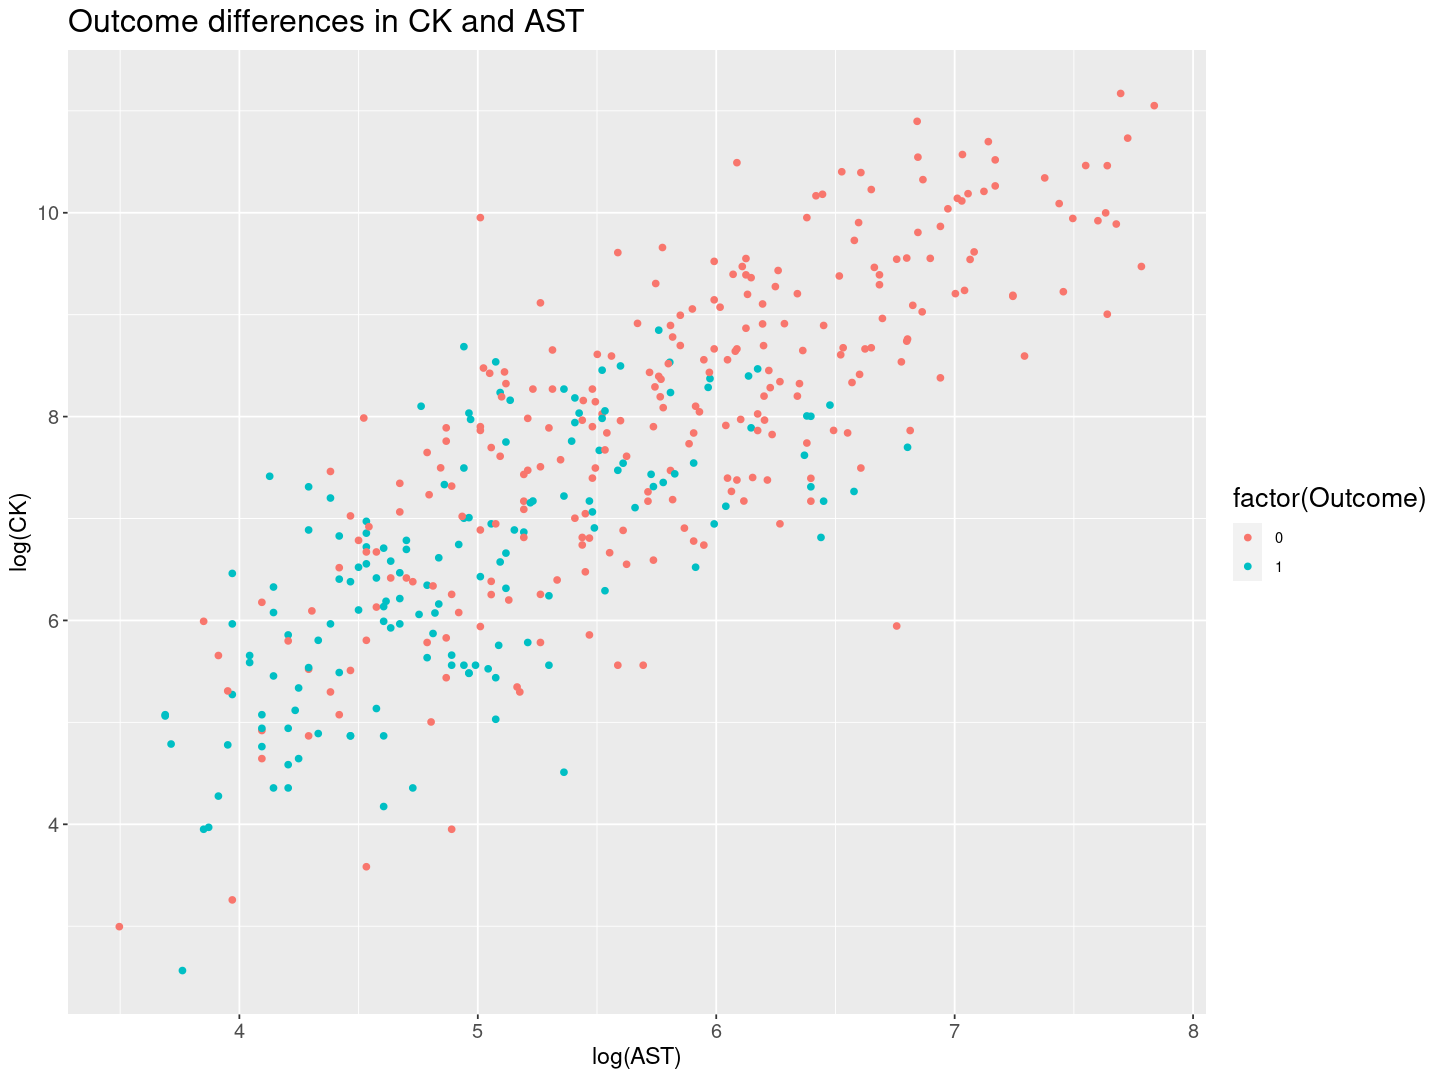

In [14]:
# Plot data to see the degree of separation between
# records with Outcome = 1 and those with Outcome = 0
# (again, leaving out the Daysrec dimension).

options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(AST, CK, color= factor(Outcome))) +

  geom_point(alpha= 1.0) +
  xlab("log(AST)") + ylab("log(CK)") +
  ggtitle("Outcome differences in CK and AST") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [ ]:
### COMMENT:

# We see in the above plot that there is a degree of 
# separation in Outcome levels based on the AST and 
# CK blood measurements.  These are the 2 most important
# dimensions we have for predicting Outcome.


In [57]:
### COMMENT:

# Can Daysrec increase the separation between levels of
# Outcome?  As this variable increases, Outcome tends to
# 0.  Also, as Daysrec increases, both CK and AST tend to
# increase.  The next plot suggests that Daysrec can help
# us distinguish between the survivors and the cows that
# did not survive.


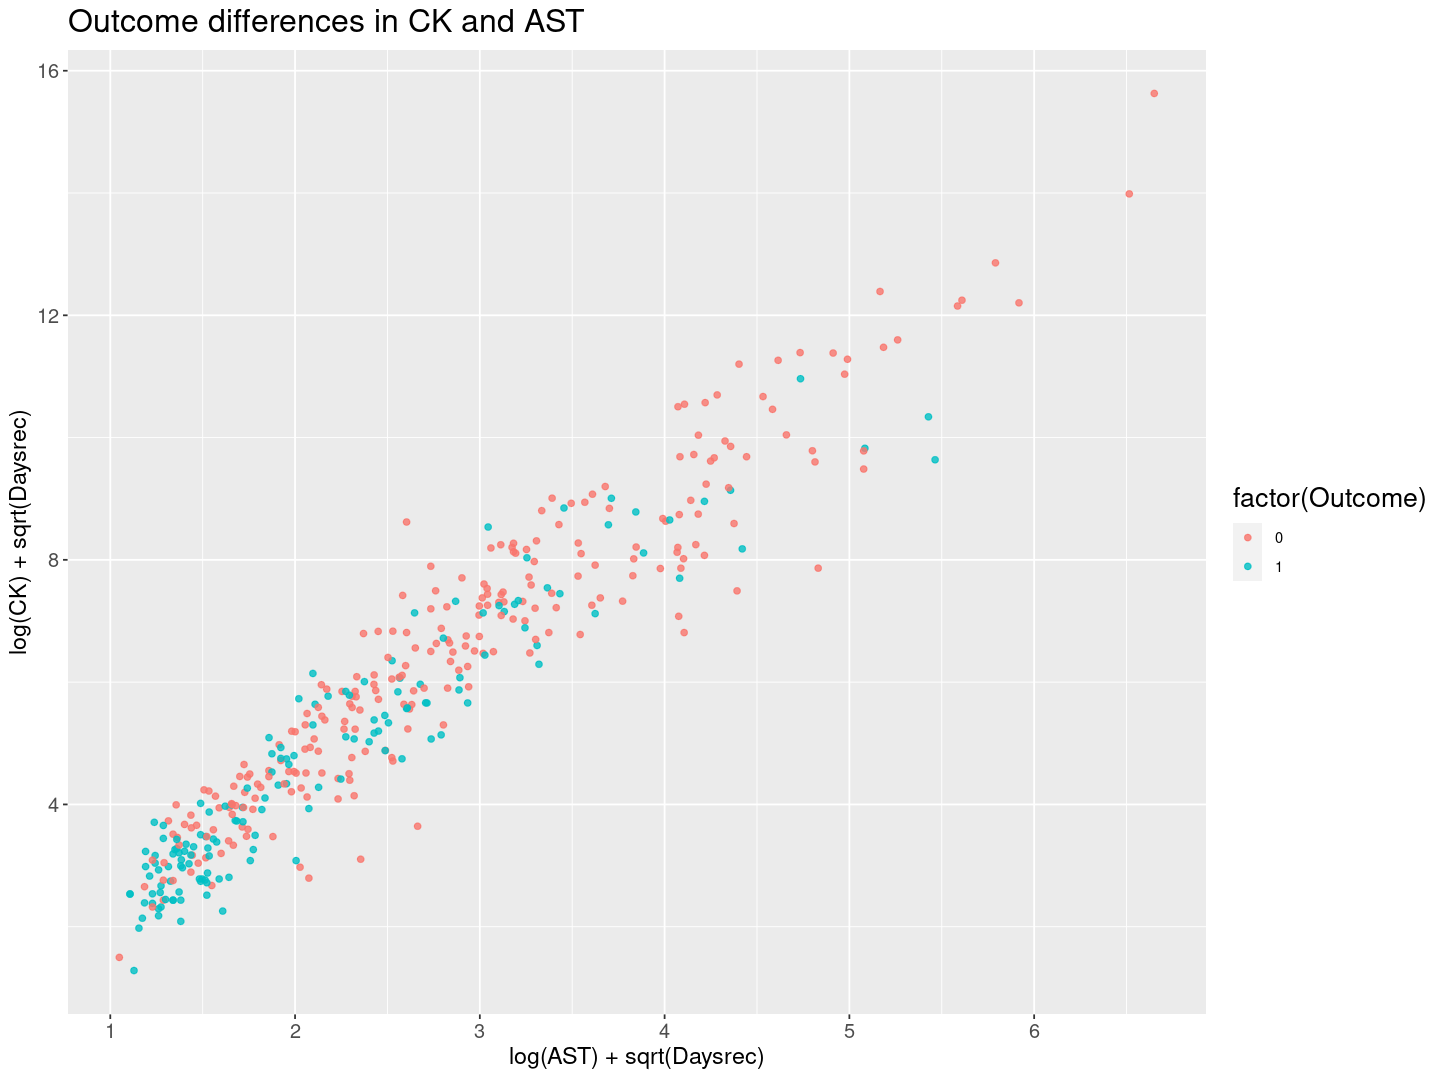

In [58]:
# Transform data for plotting.

dat_plot <- dat
dat_plot$AST <- log(dat_plot$AST) * 0.3 * sqrt(1 + dat_plot$Daysrec)
dat_plot$CK <- log(dat_plot$CK) * 0.5 * sqrt(1 + dat_plot$Daysrec)


options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(AST, CK, color= factor(Outcome))) +

  geom_point(alpha= 0.8) +
  xlab("log(AST) + sqrt(Daysrec)") + ylab("log(CK) + sqrt(Daysrec)") +
  ggtitle("Outcome differences in CK and AST") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [59]:
# Try a different transformation.

dat_plot <- dat
dat_plot$AST <- log(dat_plot$AST * 10 * sqrt(1 + dat_plot$Daysrec))  
dat_plot$CK <- (dat_plot$CK * (0.8 * sqrt(1 + dat_plot$Daysrec)))^-0.01 


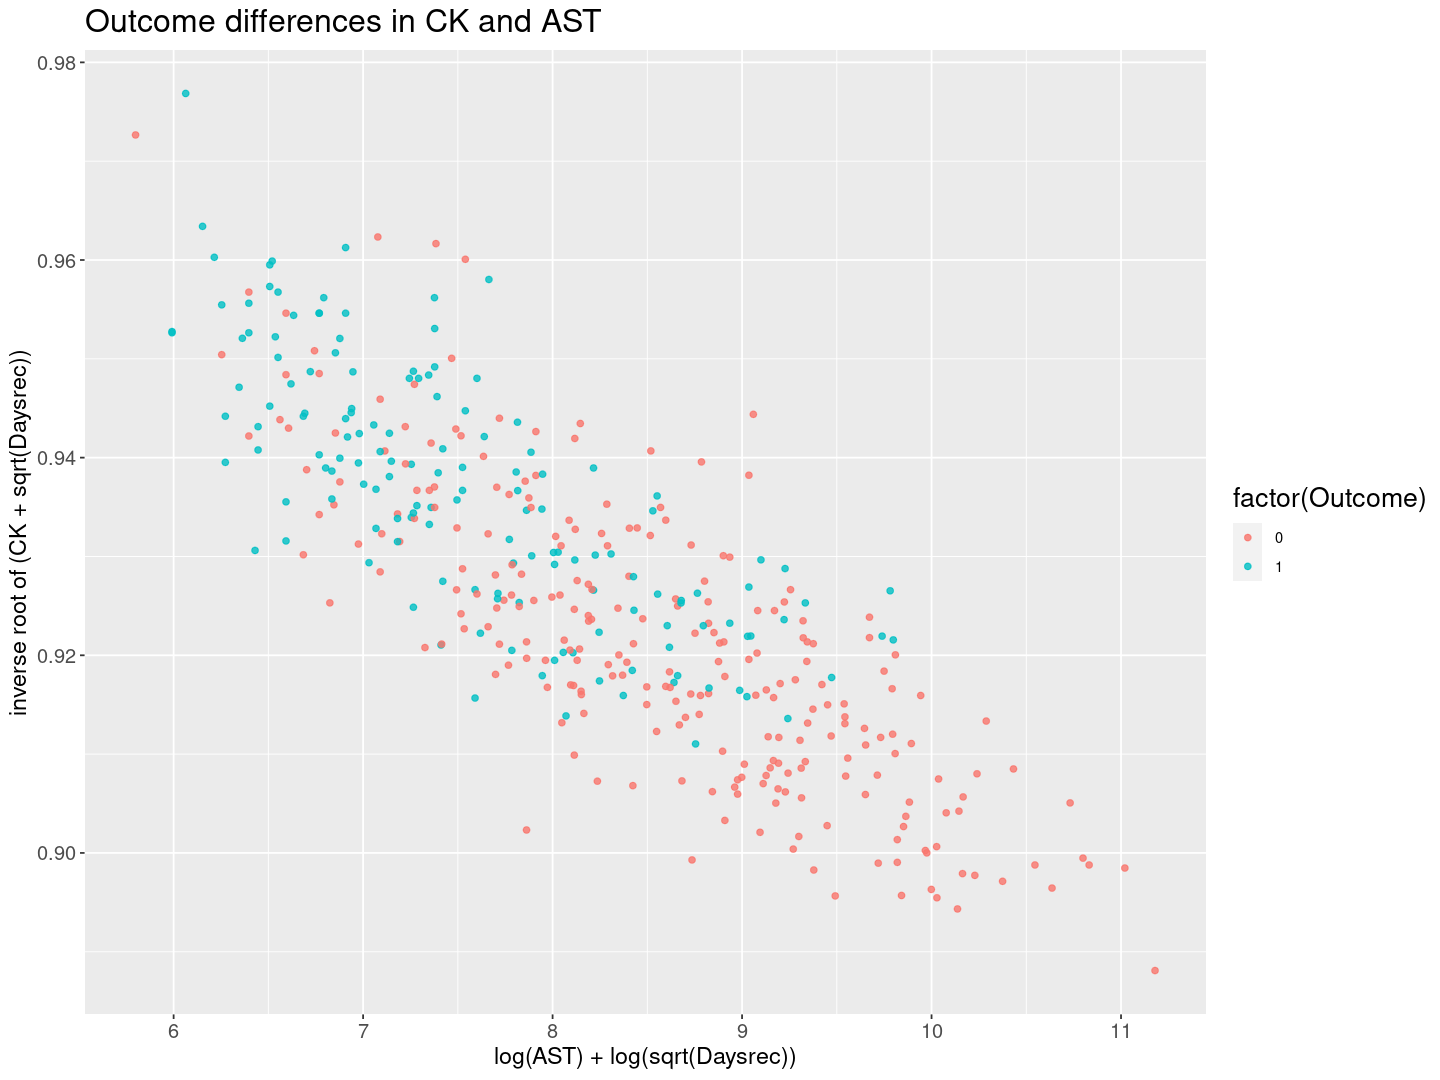

In [60]:
options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(AST, CK, color= factor(Outcome))) +

  geom_point(alpha= 0.8) +
  xlab("log(AST) + log(sqrt(Daysrec))") + ylab("inverse root of (CK + sqrt(Daysrec))") +
  ggtitle("Outcome differences in CK and AST") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


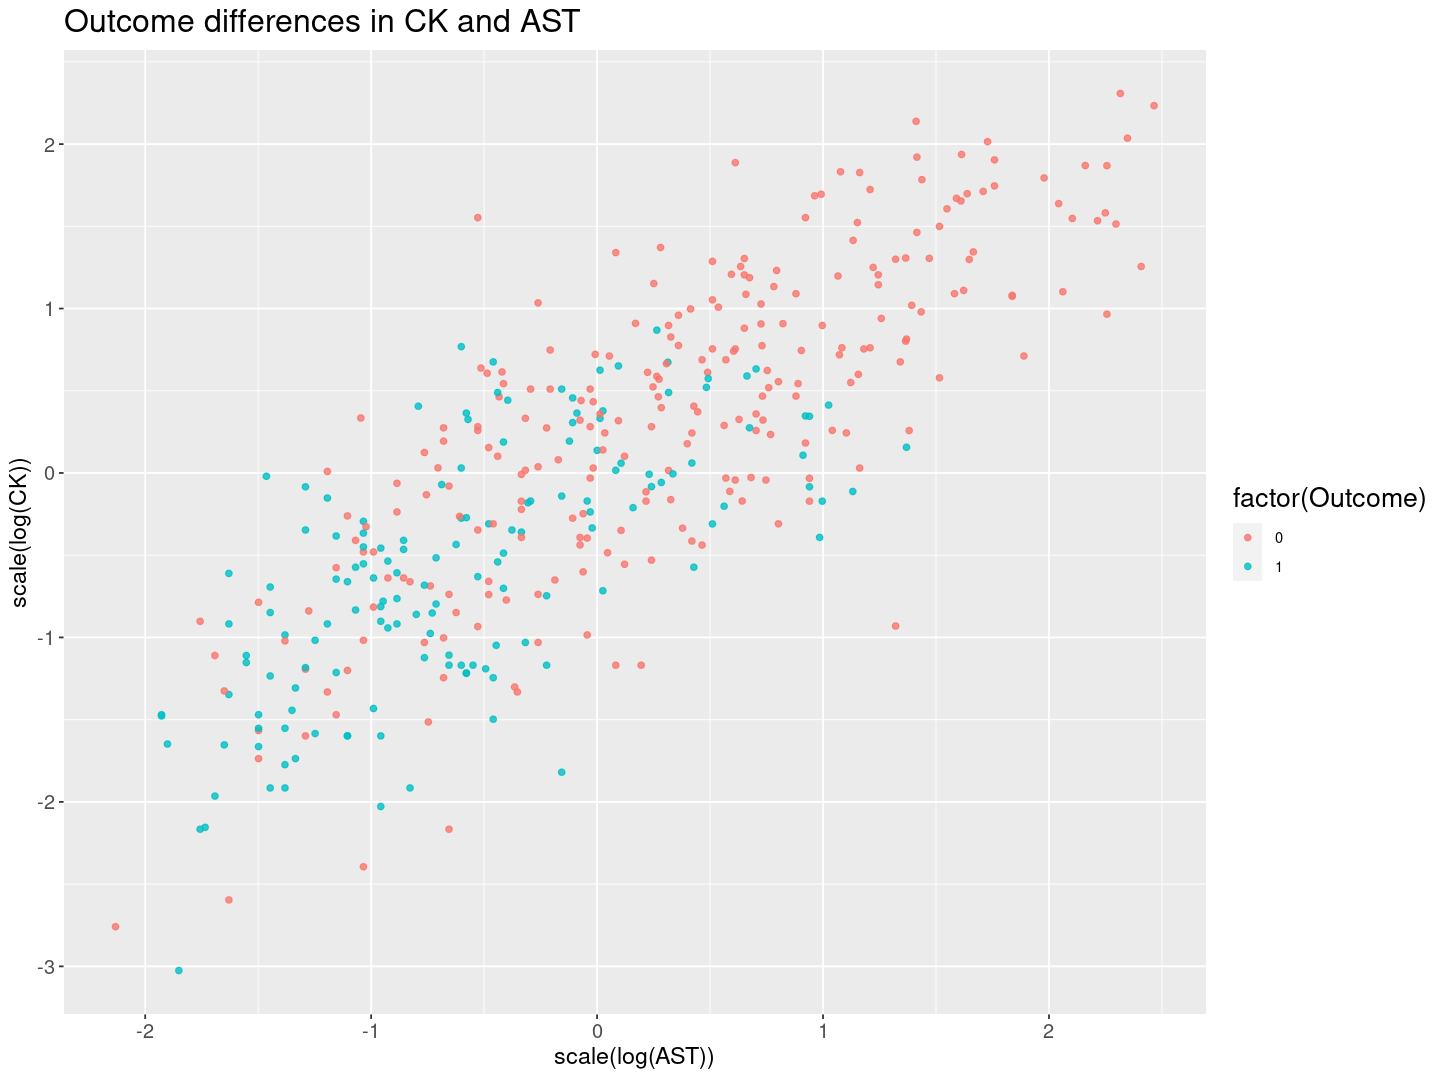

In [20]:
# Transform the data as it will be transformed
# for k-means.  HTF in The Elements of Statistical Learning
# point out that there are times when scaling makes it MORE
# difficult for clustering algorithms to separate the data
# as we would like, or expect.  See Figure 14.5 on p.506.

dat_plot <- dat
dat_plot$AST <- log(dat_plot$AST)
dat_plot$CK <- log(dat_plot$CK)

dat_plot$AST <- scale(dat_plot$AST)
dat_plot$CK <- scale(dat_plot$CK)


options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(AST, CK, color= factor(Outcome))) +

  geom_point(alpha= 0.8) +
  xlab("scale(log(AST))") + ylab("scale(log(CK))") +
  ggtitle("Outcome differences in CK and AST") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


In [15]:
rm(dat)


### Get scores for base k-means model: trainset and testset

In [16]:
# Scale the data before running k-means clustering.  I have
# transformations on each of the 3 variables prior to 
# scaling so that the resultant ranges given in the 
# summaries below are much more alike.

# train = df

train <- traindat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]
train$AST <- log(train$AST)
train$CK <- log(train$CK)
train$Daysrec <- sqrt(train$Daysrec)

train_scaled <- scale(train[, -1])
centers <- attr(train_scaled, "scaled:center")
scales <- attr(train_scaled, "scaled:scale")

train_scaled <- as.data.frame(cbind(traindat$Outcome, train_scaled),
                              row.names=rownames(traindat))
colnames(train_scaled) <- colnames(train)
summary(train_scaled)


    Outcome           AST                CK             Daysrec       
 Min.   :0.000   Min.   :-2.1490   Min.   :-2.9832   Min.   :-1.2944  
 1st Qu.:0.000   1st Qu.:-0.7651   1st Qu.:-0.6691   1st Qu.:-1.2944  
 Median :0.000   Median :-0.0542   Median : 0.0142   Median :-0.0372  
 Mean   :0.372   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.:1.000   3rd Qu.: 0.6769   3rd Qu.: 0.6654   3rd Qu.: 0.8832  
 Max.   :1.000   Max.   : 2.3959   Max.   : 2.2483   Max.   : 2.0320  

In [17]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
fit_km <- kmeans(train_scaled, 2, iter.max = 50, nstart = 30)
print(fit_km$size)
# [1] 175   145


[1] 175 145


In [18]:
print(head(fit_km$cluster))


331 201 161 283 404 121 
  1   2   1   2   2   2 


In [19]:
datout <- as.data.frame(cbind(train_scaled$Outcome, fit_km$cluster))
colnames(datout) <- c("Outcome", "cluster")
rownames(datout) <- rownames(train_scaled)
head(datout)


,Outcome,cluster
,<dbl>,<dbl>
331,1,1
201,1,2
161,0,1
283,0,2
404,0,2
121,0,2


In [26]:
# max_vals identifies the Outcome level we would expect 
# each cluster to map to.

(mat <- as.matrix(table(datout$Outcome, as.factor(datout$cluster))))
(max_vals <- apply(mat, MARGIN=2, which.max))


   
      1   2
  0 142  59
  1  33  86

1 2 
1 2

In [ ]:
### COMMENTS:

# From the above table we see that the first cluster
# is associated with Outcome level 0, the cows that did not
# survive.

# If we say that all cows in the first cluster are non-survivors
# and all cows in the second cluster are survivors, we can get
# an f-score.


In [ ]:
#&* Bookmark

In [33]:
# Function returning mapping between clusters and
# Outcome levels.  We choose the mapping that yields
# the best accuracy score.  (Keep in mind that the
# mapping is based on the trainset data; it is then
# applied to the validation and/or test set data.)

c1_toLevel_1 <- function(dat) {
    
    # Returns TRUE if cluster 1 maps to Outcome= 1 (survivors)
    
    # dat is a dataframe with 2 columns, c("Outcome","cluster");
    # nrow(dat) = number of predictions from the model;
    # dat$Outcome = traindat$Outcome (from the calling function)
    
    # We find the "correct" mapping between cluster number and 
    # Outcome level by computing accuracy scores for the different
    # valid mappings.   We choose the mapping with the best
    # accuracy score.
    
    tbl <- as.matrix(table(dat$Outcome, as.factor(dat$cluster)))
    # The colnames of tbl refer to the names of the clusters.
    
    # With only 2 levels for Outcome, we need only 2 scores.
    scores <- rep(NA, 2)    
    
    # First possibility: cluster 1 maps to non-survivors
    tmpdat <- dat
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 0
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 1
        
    preds <- as.factor(tmpdat$Outcome)
    names(preds) <- rownames(tmpdat)
    ans <- get_confusion(preds, dat[, "Outcome", drop=FALSE])
    scores[1] <- ans[[2]]
    
    # Alternative mapping: cluster 1 maps to survivors
    tmpdat <- dat
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 0
        
    preds <- as.factor(tmpdat$Outcome)
    names(preds) <- rownames(tmpdat)
    ans <- get_confusion(preds, dat[, "Outcome", drop=FALSE])
    scores[2] <- ans[[2]]
    
    return(scores[1] <= scores[2])
}


In [34]:
c1_to_Outcome1 <- c1_toLevel_1(datout)

paste("Map cluster 1 to Outcome level 1? :  ", c1_to_Outcome1, sep="")


[1] "Map cluster 1 to Outcome level 1? :  FALSE"

In [35]:
tmpdat <- datout
tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 0
tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 1
dim(tmpdat)


[1] 320   2

In [36]:
sum(rownames(tmpdat) == rownames(train_scaled)) == nrow(train_scaled)


[1] TRUE

In [37]:
table(as.factor(tmpdat$Outcome))



  0   1 
175 145 

In [38]:
# Generate confusion matrix for the k-means clusters.
# Output f-score for this confusion matrix.

preds <- as.factor(tmpdat$Outcome)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, train_scaled[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for k-means, trainset (320 rcds): ", as.character(ans[[2]]), sep=""))
# 0.6515

# Accuracy is 0.7125

# Type2 is 0.6759


    0  1 class.error
0 142 59      0.2935
1  33 86      0.2773


[1] ""

[1] "f-score for k-means, trainset (320 rcds): 0.6515"


In [89]:
# Get confusion matrix for k-means on the test data.  
# This allows us to compare the clustering with our
# models above.  We have to first scale the testset
# data using the centers and scales from the training
# set data.

# Prepare the test data.

test <- testdat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]
test$AST <- log(test$AST)
test$CK <- log(test$CK)
test$Daysrec <- sqrt(test$Daysrec)

test_scaled <- scale(test[, -1], center=centers, scale=scales)
test_scaled <- as.data.frame(cbind(test$Outcome,test_scaled), 
                                   row.names=rownames(test))
colnames(test_scaled) <- colnames(test)


In [67]:
# Function for identifying which cluster each record 
# belongs to.  This function later gets replaced by
# getCluster.

get_cluster <- function(df, centers) {
    
    # Create a $cluster column for the result
    df$cluster <- NA
    for(i in 1:nrow(df)) {
        rcd <- df[i, colnames(centers)]
        dists <- rep(NA, dim(centers)[1])
        names(dists) <- rownames(centers)
        
        for(class in rownames(centers)) {
            dists[class] <- as.numeric(dist(rbind(rcd, centers[class,]),
                                            method= "euclidean",
                                            upper= FALSE))
        }
        nearest_center <- dists[dists== min(dists)][1]
        df[i, c("cluster")] <- as.numeric(names(nearest_center))
    }
    return(df)
}


In [68]:
# Find the cluster which is "predicted" for each 
# record in the testset.

dat_result <- get_cluster(test_scaled, fit_km$centers)
table(as.factor(dat_result$cluster))



 1  2 
38 42 

In [69]:
# Use the mapping that we used for the trainset data.

dat_result$pred_Outcome <- NA
dat_result[which(dat_result$cluster==2),]$pred_Outcome <- 1
dat_result[which(dat_result$cluster==1),]$pred_Outcome <- 0


In [70]:
# Generate confusion matrix for the k-means clusters and
# the corresponding f-score.

preds <- as.factor(dat_result$pred_Outcome)
names(preds) <- rownames(dat_result)
ans <- get_confusion(preds, dat_result[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for k-means on testset (80 rcds): ", 
            as.character(ans[[2]]), sep=""))
# 0.6667

# Accuracy is 0.70

# Type2 score is 0.6800


   0  1 class.error
0 32 18        0.36
1  6 24        0.20


[1] ""

[1] "f-score for k-means on testset (80 rcds): 0.6667"


In [ ]:
### COMMENTS:

# The k-means algorithm, without any enhancements such as
# weights or an added probability column, does a better
# job classifying the records in the testset than any of
# our previous models (logistic regression, random forest,
# gradient boosting, and svm).  The accuracy score for the
# k-means model is the same as that for the logistic and 
# svm models (0.70), but k-means has a better f-score. 
# This, in turn, gives it the highest Type2 score on the 
# test set.

# It is interesting that the parameters for the best random
# forest, gradient boosting, and svm models were established 
# through cross-validation---meaning they were optimized for
# generalizability to unseen data.  The k-means model did not
# have this advantage.

# We have to be cautious regarding the above comparison.  It
# is only one data point.  It remains to be seen how k-means
# compares with the SL classifiers in terms of a cross-validation
# score.  This is done below.


# Section 4: k-means hybrid model

Add a predicted Outcome column (called "prob01") to the dataframe that k-means is applied to.  See if this additional column improves the clustering solution.  This approach is one where we leverage supervised learning to improve upon, or boost, the unsupervised k-means algorithm.  It remains to be seen whether we can improve upon the current k-means model (what I will refer to as the *base model*) with information from one or more models which appear to be no better than the base k-means model when applied to new data.  It would seem that in order for the prob01 column to boost the performance of the k-means model, it will need to not only (a) bring in new information; but also (b) add to, rather than subtract from the information already found in the other variables.  In other words, the new information will need to complement, rather than conflict with, that found in the other variables. 

The model used to generate \\$prob01 is constructed from training set data and chosen for its generalizability to unseen data.  In this next section I use the svm02 model from above because its parameters were chosen through cross-validation and, of the three models arrived at in this way, it is the best.  Choosing the model with the best performance would seem to increase the chances that the performance of the hybrid model will be better than the base k-means model.  Ideally, we would like the performance of the hybrid model to exceed that of all previous models surveyed.

Another reason for choosing svm02 to generate the prob01 columne: on the testset data, the base k-means model has 3X as many false positives as false negatives, whereas svm02 has 2X as many false negatives as false positives.  I want to see whether the probabilities from svm02 help to correct this imbalance in the k-means output.

Since the base k-means model already performs quite well, it might be difficult to boost its performance with this added probability column.  Let's see what happens.


In [ ]:
#&* Bookmark

In [39]:
# Function for identifying which cluster each record
# belongs to.

getCluster <- function(x, centers) {
    
    # x is a row of a dataframe; its columns need
    # to be in the same order as centers (a matrix
    # constructed from kmeans)
    
    cl_dist <- apply(centers, 1, function(y) sqrt(sum((x-y)^2)))
    return(which.min(cl_dist)[1])
}
                     

In [45]:
# Prepare the training set data.

# For SVM modeling, we need to scale the data.

svmtrain <- traindat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]
svm_scaled <- scale(svmtrain[, -1])
svm_centers <- attr(svm_scaled, "scaled:center")
svm_scales <- attr(svm_scaled, "scaled:scale")
svm_scaled <- as.data.frame(cbind(svmtrain$Outcome, svm_scaled),
                            row.names=rownames(svmtrain))
colnames(svm_scaled) <- colnames(svmtrain)


train <- traindat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]
# Transformations used in the k-means modeling.
train$AST <- log(train$AST)
train$CK <- log(train$CK)
train$Daysrec <- sqrt(train$Daysrec)

preds01 <- predict(svm02, newdata=svm_scaled, scale=FALSE, probability=TRUE)
train$prob01 <- as.numeric(attr(preds01, "probabilities")[, 2])

# Previous testing shows that we want to also scale the 
# prob01 column.
train_scaled <- scale(train[, -1])
centers <- attr(train_scaled, "scaled:center")
scales <- attr(train_scaled, "scaled:scale")

train_scaled <- as.data.frame(cbind(traindat$Outcome, train_scaled),
                              row.names=rownames(traindat))
colnames(train_scaled) <- colnames(train)
summary(train_scaled[, -1])


      AST                CK             Daysrec            prob01       
 Min.   :-2.1490   Min.   :-2.9832   Min.   :-1.2944   Min.   :-1.5153  
 1st Qu.:-0.7651   1st Qu.:-0.6691   1st Qu.:-1.2944   1st Qu.:-0.9596  
 Median :-0.0542   Median : 0.0142   Median :-0.0372   Median :-0.0893  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.6769   3rd Qu.: 0.6654   3rd Qu.: 0.8832   3rd Qu.: 0.8324  
 Max.   : 2.3959   Max.   : 2.2483   Max.   : 2.0320   Max.   : 1.6274  

In [46]:
print(head(train$prob01))
""
summary(train$prob01)


[1] 0.75595 0.53371 0.99876 0.32724 0.33377 0.47183


[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.304   0.427   0.619   0.639   0.823   1.000 

In [48]:
# Construct model with the new prob01 column.

set.seed(1233)
kmod <- kmeans(train_scaled[, -1], 2, iter.max = 50, nstart = 25)


In [49]:
# See how the clusters are associated with Outcome.

dfout <- as.data.frame(cbind(as.numeric(train_scaled$Outcome),
                             kmod$cluster), row.names=rownames(train_scaled))
colnames(dfout) <- c("Outcome", "cluster")

c1_to_Outcome1 <- c1_toLevel_1(dfout)

tmpdat <- dfout
if(c1_to_Outcome1) {
    
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 0
    
} else {
    
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 0
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 1 
}

        
# Generate confusion matrix for the k-means clusters and
# the corresponding f-score.
preds <- as.factor(tmpdat$Outcome)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, train_scaled[, "Outcome", drop=FALSE])

print(ans$matrix)
''
print(paste("f-score for kmeans (w/ p1), trainset (320 rcds): ", as.character(ans[[2]]), sep=""))
# [1] "f-score for kmeans (w/ p1), trainset (320 rcds): 0.6255"


mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

''
print(paste("Type2 score for kmeans (w/ p1), trainset (320 rcds): ", as.character(result), sep=""))
# [1] "Type2 score for kmeans (w/ p1), trainset (320 rcds): 0.6466"

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))
# [1] "Accuracy: 0.6781"


    0  1 class.error
0 131 70      0.3483
1  33 86      0.2773


[1] ""

[1] "f-score for kmeans (w/ p1), trainset (320 rcds): 0.6255"


[1] ""

[1] "Type2 score for kmeans (w/ p1), trainset (320 rcds): 0.6466"


[1] ""

[1] "Accuracy: 0.6781"


### Testset scores for k-means with p1

In [50]:
# Prepare testset data.  

svmtest <- testdat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]
svmtest_scaled <- scale(svmtest[, -1], center=svm_centers, scale=svm_scales)
svmtest_scaled <- as.data.frame(cbind(svmtest$Outcome, svmtest_scaled),
                            row.names=rownames(svmtest))
colnames(svmtest_scaled) <- colnames(svmtest)


test <- testdat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]
# Transformations used in the k-means modeling.
test$AST <- log(test$AST)
test$CK <- log(test$CK)
test$Daysrec <- sqrt(test$Daysrec)

preds01 <- predict(svm02, newdata=svmtest_scaled, scale= FALSE, probability=TRUE)
test$prob01 <- as.numeric(attr(preds01, "probabilities")[, 2])

test_scaled <- scale(test[, -1], center=centers, scale=scales)
test_scaled <- as.data.frame(cbind(testdat$Outcome, test_scaled),
                              row.names=rownames(testdat))
colnames(test_scaled) <- colnames(test)
summary(test_scaled[, -1])


      AST               CK             Daysrec            prob01      
 Min.   :-1.948   Min.   :-2.1405   Min.   :-1.2944   Min.   :-1.477  
 1st Qu.:-0.951   1st Qu.:-0.7674   1st Qu.:-1.2944   1st Qu.:-1.091  
 Median :-0.382   Median :-0.0647   Median :-0.0372   Median :-0.332  
 Mean   :-0.208   Mean   :-0.0774   Mean   :-0.0945   Mean   :-0.170  
 3rd Qu.: 0.563   3rd Qu.: 0.6136   3rd Qu.: 0.4836   3rd Qu.: 0.766  
 Max.   : 2.190   Max.   : 1.9609   Max.   : 2.0320   Max.   : 1.626  

In [51]:
# Get k-means predictions on the testset data.

# Each element of the following list is a row of testdat.
testScaled_asList <- split(test_scaled[, colnames(kmod$centers)],
                           seq(nrow(test_scaled)))
    
# Create a second list of the same length, each
# element being the centers from the k-means model.
apply.n.times <- function(n, x) {
    if (n == 1) list(x) else c(list(x), Recall(n - 1, x))
}
ctr_list <- apply.n.times(nrow(test_scaled), kmod$centers)
    
# Get the predictions for the validation set.
preds <- mapply(getCluster, testScaled_asList, ctr_list,
                    SIMPLIFY=TRUE)
test_scaled$cluster <- as.numeric(preds)


In [52]:
table(as.factor(test_scaled$cluster))
c1_to_Outcome1



 1  2 
34 46 

[1] FALSE

In [53]:
# Create a predicted Outcome column for dat_result.

dat_result <- test_scaled
dat_result$pred_Outcome <- NA
dat_result[which(dat_result$cluster==2),]$pred_Outcome <- 1
dat_result[which(dat_result$cluster==1),]$pred_Outcome <- 0


In [54]:
# Test set scores: k-means with prob01

preds <- as.factor(dat_result$pred_Outcome)
names(preds) <- rownames(dat_result)
ans <- get_confusion(preds, dat_result[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for k-means (w/ p1) on testset (80 rcds): ", 
            as.character(ans[[2]]), sep=""))
# [1] "f-score for k-means (w/ p1) on testset (80 rcds): 0.6579"


   0  1 class.error
0 29 21      0.4200
1  5 25      0.1667


[1] ""

[1] "f-score for k-means (w/ p1) on testset (80 rcds): 0.6579"


In [55]:
# Type2 score for k-means (w/ p1) when applied to the test set.

mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

print(paste("Type2 score for k-means (w/ p1) on testset (80 rcds): ",
            as.character(result), sep=""))
# [1] "Type2 score for k-means (w/ p1) on testset (80 rcds): 0.6647"

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))
# [1] "Accuracy: 0.675"


[1] "Type2 score for k-means (w/ p1) on testset (80 rcds): 0.6647"


[1] ""

[1] "Accuracy: 0.675"


In [ ]:
### COMMENTS:

# On the testset data, the hybrid model does not perform
# quite as well as the base k-means model.  The  FPs 
# increased by 3, while the FNs decreased by only 1.
# On the testset data, the hybrid model does not perform
# quite as well as svm02.

# Further downstream, the models are compared in terms of
# their cross-validation scores.  That will be the more 
# informative test.


## Add weights to the hybrid k-means model

We should be able to improve the hybrid model by adding weights to it.

In [ ]:
#&* Bookmark

In [71]:
# Function to generate combination of parameters for gridSearch;
# each combination must add to a number ~1.  Returns a dataframe, 
# each row of which is a valid combination.

# I re-factored this ftn using R's expand.grid ftn.  expand.grid
# actually takes more time to run.  This is probably due to  
# type-checking.  It appears that we also run out of memory more
# quickly when using expand.grid.  So at the moment I am 
# reverting to the deprecated section.

generate_combs <- function(arglist, tol=0.0001) {
    # arglist is a named list; each name is a column
    # name of the dataframe which goes to k-means
    
    #################################################
    # this next section is an alternative to expand.grid
    #################################################
    # if(FALSE) {
    n_args <- length(arglist)
  
    param_vlens <- rep(NA, n_args)
    for(i in 1:n_args) {
        param_vlens[i] <- length(arglist[[i]])
    }
    n_rows <- prod(param_vlens)
  
    datout <- rep(NA, n_args*n_rows)
    dim(datout) <- c(n_rows, n_args)
    datout <- as.data.frame(datout)
    colnames(datout) <- names(arglist)
  
    cprod <- 1
    for(j in 1:n_args) {
        vect <- arglist[[j]]
        val <- rep(vect, rep(cprod, length(vect)))
        datout[, j] <- rep(val, n_rows/length(val))
        cprod <- cprod*length(vect)
    }
        
    # } ## end of 'if(FALSE)'
    #################################################
    
    # datout <- expand.grid(arglist, KEEP.OUT.ATTRS= FALSE)
    # colnames(datout) <- names(arglist)
    
    row_sums <- round(rowSums(datout), 4)
    names(row_sums) <- rownames(datout)
    tol <- tol
    row_sums <- row_sums[which((as.numeric(row_sums) <= (1 + tol)) & (as.numeric(row_sums) >= (1 - tol)))]
    datout <- datout[names(row_sums),]
    return(datout)
}


In [85]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from gridSearch06.

get_cvScore_kmp1 <- function(traindat, valdat, seed, wghts) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, Daysrec, and prob01.)
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Outcome, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.01, cost= 20, scale=FALSE, probability=TRUE)
    
    preds01 <- predict(svmod, newdata=svm_scaled, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds01, "probabilities")[, 2])
    
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled,
                                   row.names=rownames(valdat))
    
    # Compute the prob01 column.
    preds01_b <- predict(svmod, newdata=svmval_scaled, probability=TRUE)
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.  (We want valdat to look exactly like
    # traindat.  The weights act as a transformation of the data.)
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    set.seed(seed)
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                          row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat_wghts)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                      SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 6)
    return(result)
}


In [86]:
# This grid search searches for the best set of weights to use
# in our k-means clustering model.  The best weights are those
# which generalize best to the validation set.  So we look for
# the best cross-validation score.
# Because our training set is so small---only 320 records---we
# need to run the gridSearch over several seeds.  Otherwise, we 
# will not get very stable results.  (Of course, the more seeds
# we use, the more time the grid search takes.)

gridSearch06 <- function(seed_vector, dat, df_params, folds=5) {
    
    datout <- rep(NA, 2*nrow(df_params))
    dim(datout) <- c(nrow(df_params), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("row", "Type2")
    datout$row <- rownames(df_params)
    
    # We want the sqrt of the weights.
    df_params <- df_params^0.5
    params_rows <- rownames(df_params)
    
    #############################
    # Partition the data into folds, making sure
    # the ratio of survivors to non-survivors is
    # about the same for each traindat/valdat pair.
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # Create a dataframe, each row for a distinct seed.
    # Each column of the dataframe is for a distinct set
    # of weights.  The entries in the cells are Type2 
    # scores.
    seedv_len <- length(seed_vector)
    df_scores <- rep(NA, seedv_len*nrow(df_params))
    dim(df_scores) <- c(seedv_len, nrow(df_params))
    df_scores <- as.data.frame(df_scores, row.names=as.character(seed_vector))
    colnames(df_scores) <- rownames(df_params)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seed_vector[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
        
        # Get ratio of surviving to non-surviving cows.
        dat_surv <- dat[which(dat$Outcome==1),]
        dat_nonSurv <- dat[which(dat$Outcome==0),]
        surv_ratio <- round(nrow(dat_surv)/nrow(dat), 4)
    
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        used_surv <- used_nonSurv <- c()
    
        for(k in 1:folds) {
            surv_count <- round(surv_ratio * segmentsv[k])
            nonSurv_count <- segmentsv[k] - surv_count
            avail_survRows <- rownames(dat_surv)[which(!(rownames(dat_surv) %in% used_surv))]
            avail_nonSurvRows <- rownames(dat_nonSurv)[which(!(rownames(dat_nonSurv) %in% used_nonSurv))]
        
            if(k < folds) {
                smp01 <- sample(avail_survRows, surv_count, replace=FALSE)
                smp02 <- sample(avail_nonSurvRows, nonSurv_count, replace=FALSE)
            } else {
                smp01 <- avail_survRows
                smp02 <- avail_nonSurvRows
                stopifnot(length(c(smp01, smp02))== segmentsv[k])
            }
            used_surv <- c(used_surv, smp01)
            used_nonSurv <- c(used_nonSurv, smp02)
            row_list[[k]] <- c(smp01, smp02)
        } # end of for-loop, index k
    
        #############################
    
        for(i in 1:nrow(df_params)) {
            
            cur_row <- params_rows[i]
            wghts <- as.numeric(df_params[i,])
            names(wghts) <- colnames(df_params)
            train_list <- test_list <- vector("list", length= folds)
        
            for(j in 1:folds) {
                testdat <- dat[row_list[[j]],]
                traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
                test_list[[j]] <- testdat
                train_list[[j]] <- traindat
            }
            # When there are only 5 folds, only 5 cores get used.
            scores <- mcmapply(get_cvScore_kmp1, train_list, test_list,
                               MoreArgs= list(seed=cur_seed, wghts=wghts),
                               SIMPLIFY= TRUE, mc.cores=5)
            
            # For the current seed, store the average of the Type2
            # scores, the average taken over the folds.
            df_scores[as.character(cur_seed), cur_row] <- round(mean(scores), 5)
        
        } # end of for-loop, index i
    } ## end of for-loop, index h
    
    # Compute the average over the seeds of the Type2 scores
    # obtained for each set of parameters in df_params.
    datout$Type2 <- round(apply(df_scores, MARGIN=2, mean), 5)
    return(datout)
}


### Search for the best set of weights for the hybrid model

In [103]:
# There are 4 parameter lists to work with.  The best
# approach, perhaps, is to start by exploring the 
# region around the space where all parameters have an 
# equal weight---in this case, a weight of 0.25.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- seq(0.13, 0.37, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  1469     4


[1] 1469    4

In [104]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
11425,0.33,0.27,0.17,0.23
7201,0.35,0.27,0.19,0.19
22165,0.37,0.15,0.15,0.33
20509,0.27,0.21,0.21,0.31
23329,0.25,0.13,0.29,0.33
22057,0.29,0.25,0.13,0.33


In [ ]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 10, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, traindat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 20 secs (for 10 rows)


In [ ]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


In [ ]:
dfc01[best_params,]

best_Type2


In [108]:
# Find the best weights of those in dfc01 (1469 rows,
# 21 seeds, 5 folds). 

set.seed(1233)
seed_vector <- sample(1:9999, 21, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.92 hours


[1] "Start time: 2021-04-06 14:08:42"

Time difference of 1.92 hours

In [109]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [110]:
dfc01[best_params,]
#   	 AST 	  CK  	Daysrec 	prob01

# 3985	0.25 	0.27	   0.33 	  0.15


best_Type2
# 0.65817


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
3985,0.25,0.27,0.33,0.15


[1] 0.65817

In [112]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.21, 0.29, by= 0.01)
lst[[2]] <- seq(0.23, 0.31, by= 0.01)
lst[[3]] <- seq(0.31, 0.35, by= 0.01)
lst[[4]] <- seq(0.13, 0.17, by=0.01)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  185     4


[1] 185   4

In [113]:
# Add no weights to the combinations.  This will 
# tell us whether using weights is better than not
# using weights.  (Setting each of the weight 
# coefficients to 1 is essentially equivalent to
# setting each of the 4 weights to 0.25, although
# small differences can appear in the resulting
# score.)  

# NOTE: the result we get from this test is much 
# better than testing against the test set, since
# this test is the equivalent of 100 such tests.

dfc02 <- rbind(dfc02, rep(1,4))


In [114]:
# Find the best weights of those in dfc02 (186 rows,
# 21 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 21, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 14.36 mins


[1] "Start time: 2021-04-06 16:07:54"

Time difference of 14.36 mins

In [115]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [116]:
dfc02[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01

# 1029  	0.23 	0.29	   0.33 	  0.15

best_Type2
# 0.6582


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
1029,0.23,0.29,0.33,0.15


[1] 0.6582

In [ ]:
### COMMENTS:

# Notice that the best cross-validation score does 
# not occur when all coefficients, or weights, are
# set to 1.  Thus, the weights are an improvement over
# no weights.

# In order to compare the k-means model that includes
# prob01 with the base k-means model, we need to get
# a similar cross-validation score for the base k-means
# model.  We can do this when we also add weights to it.
# (This is done further downstream.)


### With best weights, get scores for hybrid model on trainset and testset

In [56]:
dim(train_scaled)
summary(train_scaled[, -1])


[1] 320   5

      AST                CK             Daysrec            prob01       
 Min.   :-2.1490   Min.   :-2.9832   Min.   :-1.2944   Min.   :-1.5153  
 1st Qu.:-0.7651   1st Qu.:-0.6691   1st Qu.:-1.2944   1st Qu.:-0.9596  
 Median :-0.0542   Median : 0.0142   Median :-0.0372   Median :-0.0893  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.6769   3rd Qu.: 0.6654   3rd Qu.: 0.8832   3rd Qu.: 0.8324  
 Max.   : 2.3959   Max.   : 2.2483   Max.   : 2.0320   Max.   : 1.6274  

In [57]:
# Apply weights to train_scaled.  We need to take 
# the sqrt of the weights.

wghts <- c(0.23, 0.29, 0.33, 0.15)^0.5
cols <- colnames(train_scaled)[-1]
names(wghts) <- cols
df2 <- t(t(train_scaled[, cols]) * as.numeric(wghts[cols]))
train_wghts <- cbind(as.numeric(train_scaled$Outcome), df2)
train_wghts <- as.data.frame(train_wghts)
colnames(train_wghts) <- c("Outcome", cols)
rownames(train_wghts) <- rownames(train_scaled)


In [58]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
fit02_km <- kmeans(train_wghts[, -1], 2, iter.max = 50, nstart = 25)

print(fit02_km$size)


[1] 172 148


In [59]:
# See how the clusters are associated with Outcome.

dfout <- as.data.frame(cbind(as.numeric(train_wghts$Outcome),
                             fit02_km$cluster))
colnames(dfout) <- c("Outcome", "cluster")
rownames(dfout) <- rownames(train_wghts)

c1_to_Outcome1 <- c1_toLevel_1(dfout)
        
if(c1_to_Outcome1) {
    # cluster 1 is associated with the survivors
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 0
} else {
    # cluster 2 is associated with the survivors
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 1
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 0
}
        
# Generate confusion matrix for the k-means clusters and
# the corresponding f-score.
preds <- as.factor(tmpdat$Outcome)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, train_wghts[, "Outcome", drop=FALSE])

print(ans$matrix)
''
print(paste("f-score for kmeans (w/ p1, wghts) on trainset (320 rcds): ",
            as.character(ans[[2]]), sep=""))

mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

''
print(paste("Type2 score for kmeans (w/ p1, wghts) on trainset (320 rcds): ", as.character(result), sep=""))

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))


    0  1 class.error
0 131 70      0.3483
1  33 86      0.2773


[1] ""

[1] "f-score for kmeans (w/ p1, wghts) on trainset (320 rcds): 0.6255"


[1] ""

[1] "Type2 score for kmeans (w/ p1, wghts) on trainset (300 rcds): 0.6466"


[1] ""

[1] "Accuracy: 0.6781"


### Test set scores: k-means with p1 & weights (hybrid model)

In [60]:
test_scaled <- test_scaled[, 1:5]


In [61]:
dim(test_scaled)
summary(test_scaled[, -1])


[1] 80  5

      AST               CK             Daysrec            prob01      
 Min.   :-1.948   Min.   :-2.1405   Min.   :-1.2944   Min.   :-1.477  
 1st Qu.:-0.951   1st Qu.:-0.7674   1st Qu.:-1.2944   1st Qu.:-1.091  
 Median :-0.382   Median :-0.0647   Median :-0.0372   Median :-0.332  
 Mean   :-0.208   Mean   :-0.0774   Mean   :-0.0945   Mean   :-0.170  
 3rd Qu.: 0.563   3rd Qu.: 0.6136   3rd Qu.: 0.4836   3rd Qu.: 0.766  
 Max.   : 2.190   Max.   : 1.9609   Max.   : 2.0320   Max.   : 1.626  

In [62]:
# Apply weights to test_scaled. 

df2 <- t(t(test_scaled[, cols]) * as.numeric(wghts[cols]))
test_wghts <- cbind(as.numeric(test_scaled$Outcome), df2)
test_wghts <- as.data.frame(test_wghts)
colnames(test_wghts) <- c("Outcome", cols)
rownames(test_wghts) <- rownames(test_scaled)


In [63]:
# Get k-means predictions on the testset data.

# Each element of the following list is a row of newtestdat.
testwghts_asList <- split(test_wghts[, colnames(fit02_km$centers)],
                          seq(nrow(test_wghts)))
    
# Create a second list of the same length, each
# element being the centers from the k-means model.
apply.n.times <- function(n, x) {
    if (n == 1) list(x) else c(list(x), Recall(n - 1, x))
}
ctr_list <- apply.n.times(nrow(test_wghts), fit02_km$centers)
    
# Get the predictions for the validation set.
preds <- mapply(getCluster, testwghts_asList, ctr_list,
                    SIMPLIFY=TRUE)
dat_result <- test_wghts
dat_result$cluster <- as.numeric(preds)
table(as.factor(dat_result$cluster))



 1  2 
40 40 

In [64]:
c1_to_Outcome1


[1] FALSE

In [65]:
# Create a predicted Outcome column for dat_result.

dat_result$pred_Outcome <- NA
dat_result[which(dat_result$cluster==2),]$pred_Outcome <- 1
dat_result[which(dat_result$cluster==1),]$pred_Outcome <- 0


In [66]:
# Test set scores: k-means with prob01 & wghts

preds <- as.factor(dat_result$pred_Outcome)
names(preds) <- rownames(dat_result)
ans <- get_confusion(preds, dat_result[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for k-means (w/ p1, wghts) on testset (80 rcds): ", 
            as.character(ans[[2]]), sep=""))
# 0.6286


   0  1 class.error
0 32 18      0.3600
1  8 22      0.2667


[1] ""

[1] "f-score for k-means (w/ p1, wghts) on testset (80 rcds): 0.6286"


In [67]:
# Type2 score for k-means when applied to the test set.

mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

print(paste("Type2 score for k-means (w/ p1, wghts) on testset (80 rcds): ",
            as.character(result), sep=""))
# [1] "Type2 score for k-means (w/ p1, wghts) on testset (80 rcds): 0.6472"

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))
# [1] "Accuracy: 0.675"


[1] "Type2 score for k-means (w/ p1, wghts) on testset (80 rcds): 0.6472"


[1] ""

[1] "Accuracy: 0.675"


In [ ]:
### COMMENTS:

# The scores for the hybrid model with weights, on the test
# set, are slightly less good than without the weights; on
# the test set the hybrid model with weights fares even worse
# compared to the base k-means model (i.e., without
# weights and without the prob01 column). 

# We saw above that we get a better average cross-validation 
# score (using the prob01 column) with weights than without
# weights.  This tells us something about the importance of
# using weights and using more than one test set.  The model
# we are interested in is the one that does the best job 
# generalizing to new data; in other words, we are interested
# in the model with the best cross-validation score (and not
# the model that simply has the best score on the test set).

# Next I apply the same test to the base k-means model.
# But when running the test, we can also test the base model
# using weights.  For it is highly likely that the base model
# will also have better cross-validation scores when we use 
# weights.


### Get cross-val scores for k-means base model; add in weights.

I will need to make slight changes to our functions used in this test.  gridSearch06, above, has been changed to call get_cvScore_kmBase (below).

In [80]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from gridSearch06.

get_cvScore_kmBase <- function(traindat, valdat, seed, wghts) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, and Daysrec.)
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names(traindat))
    colnames(traindat_wghts) <- cols
       
    #############################
    # Prepare valdat for svm modeling.
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.  (We want valdat to look exactly like
    # traindat.  The weights act as a transformation of the data.)
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    set.seed(seed)
    # Outcome is the first column of traindat; we need to
    # remove this column prior to clustering.
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat_wghts)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                      SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 6)
    return(result)
}


In [65]:
# There are 3 parameter lists to work with.

lst <- vector("list", length= 3)
names(lst) <- c("AST","CK","Daysrec")

lst[[1]] <- lst[[2]] <- lst[[3]] <- seq(0.15, 0.55, by=0.01)

start <- Sys.time()
dfc04 <- generate_combs(lst, tol=0.0001)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc04)


[1] 1236    3

In [66]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc04), 10, replace=FALSE)
tst_params <- dfc04[smp,]


In [ ]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 10, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, traindat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 15 secs (for 10 rows)


In [ ]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


In [ ]:
dfc04[best_params,]

best_Type2


In [70]:
# Find the best weights of those in dfc01 (1236 rows,
# 10 seeds, 5 folds).

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc04) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 32.57 mins


[1] "Start time: 2021-04-06 12:30:21"

Time difference of 32.57 mins

In [71]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [72]:
dfc04[best_params,]
#   	 AST 	  CK  	Daysrec 

# 5616	0.54 	0.28	   0.18


best_Type2
# 0.66497


,AST,CK,Daysrec
,<dbl>,<dbl>,<dbl>
5616,0.54,0.28,0.18


[1] 0.66497

In [72]:
# See whether the above weights are better 
# than no weights.

lst <- vector("list", length= 3)
names(lst) <- c("AST","CK","Daysrec")

lst[[1]] <- c(0.54)
lst[[2]] <- c(0.28)
lst[[3]] <- c(0.18)

start <- Sys.time()
dfc05 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

(dfc05 <- rbind(dfc05, rep(1, 3)))


AST,CK,Daysrec
<dbl>,<dbl>,<dbl>
0.54,0.28,0.18
1.00,1.00,1.00


In [82]:
# Find the best weights of those in dfc05 ( rows,
# 10 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 10, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc05) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.74 secs


[1] "Start time: 2021-05-23 16:03:04"

Time difference of 2.74 secs

In [83]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [84]:
dfc05[best_params,]
#       	 AST 	  CK  	Daysrec

# 1     	0.54 	0.28	   0.18

best_Type2
# 0.66497


,AST,CK,Daysrec
,<dbl>,<dbl>,<dbl>
1,0.54,0.28,0.18


[1] 0.66497

In [ ]:
### COMMENTS:

# The base k-means model works best with weights.
# With weights, we have a cross-validation Type2 score,
# averaged over 50 folds, of 0.6650.

# If we add a probability column to the base k-means
# model, using svm02 for the probabilities, the 
# cross-val Type2 score decreases by half a percentage 
# point, to 0.6599.


### Cross-val score for base k-means with weights, 1000 seeds

For model comparison, it is best if we obtain scores using far more seeds.  For each of the models of interest, I generate scores using 1000 seeds.  The scores are summarized in tables below.  (Search on '#&* Bookmark'.)

In [77]:
lst <- vector("list", length= 3)
names(lst) <- c("AST","CK","Daysrec")

lst[[1]] <- c(0.54)
lst[[2]] <- c(0.28)
lst[[3]] <- c(0.18)

dfc05 <- generate_combs(lst)


In [78]:
set.seed(42)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc05) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.58 mins


[1] "Start time: 2021-04-06 13:38:47"

Time difference of 2.58 mins

In [79]:
dat_result
# Type2 score of 0.6620


row,Type2
<chr>,<dbl>
1,0.66199


### Cross-val score for hybrid model with weights, 1000 seeds

In [87]:
lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

# The first set of weights below is from when I 
# used just 10 seeds.  The second set is from 
# when I used 21 seeds.
# wghts <- c(0.17, 0.34, 0.34, 0.15)
# wghts <- c(0.23, 0.29, 0.33, 0.15)

lst[[1]] <- c(0.23)
lst[[2]] <- c(0.29)
lst[[3]] <- c(0.33)
lst[[4]] <- c(0.15)

dfc06 <- generate_combs(lst)


In [88]:
# gridSearch06 needs to call the other get_cvScore ftn.

set.seed(42)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc06) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.89 mins


[1] "Start time: 2021-05-23 16:08:01"

Time difference of 2.89 mins

In [89]:
dat_result
# Type2 score of 0.6559


row,Type2
<chr>,<dbl>
1,0.65587


In [ ]:
### COMMENTS: 

# Averaging over 1000 seeds (or 5000 folds of traindat),
# our k-means model has a slightly worse Type2 score
# when we include the probabilities from svm02.  The
# drop in average cross-val score is by 0.6 percentage
# point.

# Including the prob01 column, k-means has an average 
# Type2 cross-validation score of 0.6559.  Without the
# prob01 column, the score is 0.6620.  In this comparison,
# weights are used for both models.  This means that we
# need to have the Outcome variable in our dataset in
# order to construct both of these models.


### Get scores for base k-means model with weights on trainset and testset

Although the following scores are not that important overall, I include them for completeness, since this is what I have been doing thus far for each of the models.  Similar scores will not be found in Part 2.

In [84]:
# Apply weights to traindat.  We need to take 
# the sqrt of the weights.

wghts <- c(0.54, 0.28, 0.18)^0.5
cols <- colnames(traindat)[-1]
names(wghts) <- cols
df2 <- t(t(train_scaled[, cols]) * as.numeric(wghts[cols]))
train_wghts <- cbind(as.numeric(train_scaled$Outcome), df2)
train_wghts <- as.data.frame(train_wghts)
colnames(train_wghts) <- c("Outcome", cols)
rownames(train_wghts) <- rownames(traindat)


In [85]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
start <- Sys.time()
fit02_km <- kmeans(train_wghts[, -1], 2, iter.max = 50, nstart = 25)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 0.15 secs

print(fit02_km$size)


Time difference of 0 secs

[1] 151 169


In [86]:
# See how the clusters are associated with Outcome.

dfout <- as.data.frame(cbind(as.numeric(train_wghts$Outcome),
                             fit02_km$cluster))
colnames(dfout) <- c("Outcome", "cluster")
rownames(dfout) <- rownames(train_wghts)

tmpdat <- dfout

c1_to_Outcome1 <- c1_toLevel_1(dfout)
        
if(c1_to_Outcome1) {
    # cluster 1 is associated with the survivors
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 0
} else {
    # cluster 2 is associated with the survivors
    tmpdat[which(tmpdat$cluster== 2),]$Outcome <- 1
    tmpdat[which(tmpdat$cluster== 1),]$Outcome <- 0
}
        
# Generate confusion matrix for the k-means clusters and
# the corresponding f-score.
preds <- as.factor(tmpdat$Outcome)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, train_wghts[, "Outcome", drop=FALSE])

print(ans$matrix)
''
print(paste("f-score for kmeans (w/ wghts) on trainset (320 rcds): ", as.character(ans[[2]]), sep=""))

mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

''
print(paste("Type2 score for kmeans (w/ wghts) on trainset (320 rcds): ", as.character(result), sep=""))

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))


    0  1 class.error
0 126 75      0.3731
1  25 94      0.2101


[1] ""

[1] "f-score for kmeans (w/ wghts) on trainset (320 rcds): 0.6528"


[1] ""

[1] "Type2 score for kmeans (w/ wghts) on trainset (320 rcds): 0.6667"


[1] ""

[1] "Accuracy: 0.6875"


### Test set scores; base k-means model with weights

On the test set, k-means with weights does not score as well as k-means without weights.  But we know from the above work that the better model is when we use weights.

In [90]:
# Scale the testset data.  Then apply the
# weights.

test <- testdat[, c("Outcome","AST","CK","Daysrec"), drop=FALSE]
test$AST <- log(test$AST)
test$CK <- log(test$CK)
test$Daysrec <- sqrt(test$Daysrec)

test_scaled <- scale(test[, -1], center=centers, scale=scales)

test_scaled <- as.data.frame(cbind(testdat$Outcome, test_scaled),
                             row.names=rownames(testdat))
colnames(test_scaled) <- colnames(test)
summary(test_scaled)


    Outcome           AST               CK             Daysrec       
 Min.   :0.000   Min.   :-1.948   Min.   :-2.1405   Min.   :-1.2944  
 1st Qu.:0.000   1st Qu.:-0.951   1st Qu.:-0.7674   1st Qu.:-1.2944  
 Median :0.000   Median :-0.382   Median :-0.0647   Median :-0.0372  
 Mean   :0.375   Mean   :-0.208   Mean   :-0.0774   Mean   :-0.0945  
 3rd Qu.:1.000   3rd Qu.: 0.563   3rd Qu.: 0.6136   3rd Qu.: 0.4836  
 Max.   :1.000   Max.   : 2.190   Max.   : 1.9609   Max.   : 2.0320  

In [91]:
# Apply the weights to the testset data.

df2 <- t(t(test_scaled[, cols]) * as.numeric(wghts[cols]))
test_wghts <- cbind(as.numeric(test_scaled$Outcome), df2)
test_wghts <- as.data.frame(test_wghts)
colnames(test_wghts) <- c("Outcome", cols)
rownames(test_wghts) <- rownames(testdat)


In [92]:
# Get k-means predictions on the testset data.

# Each element of the following list is a row of newtestdat.
testwghts_asList <- split(test_wghts[, colnames(fit02_km$centers)],
                           seq(nrow(test_wghts)))
    
# Create a second list of the same length, each
# element being the centers from the k-means model.
apply.n.times <- function(n, x) {
    if (n == 1) list(x) else c(list(x), Recall(n - 1, x))
}
ctr_list <- apply.n.times(nrow(test_wghts), fit02_km$centers)
    
# Get the predictions for the validation set.
preds <- mapply(getCluster, testwghts_asList, ctr_list,
                    SIMPLIFY=TRUE)
test_wghts$cluster <- as.numeric(preds)


In [93]:
c1_to_Outcome1



 1  2 
32 48 

[1] FALSE

In [94]:
# Create a predicted Outcome column for dat_result.

dat_result <- test_wghts
dat_result$pred_Outcome <- NA
dat_result[which(dat_result$cluster==2),]$pred_Outcome <- 1
dat_result[which(dat_result$cluster==1),]$pred_Outcome <- 0


In [95]:
# Test set scores: base k-means with best weights.

preds <- as.factor(dat_result$pred_Outcome)
names(preds) <- rownames(dat_result)
ans <- get_confusion(preds, dat_result[, "Outcome", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for k-means (w/ wghts) on testset (80 rcds): ", 
            as.character(ans[[2]]), sep=""))
# 0.6667


   0  1 class.error
0 28 22      0.4400
1  4 26      0.1333


[1] ""

[1] "f-score for k-means (w/ wghts) on testset (80 rcds): 0.6667"


In [96]:
# Type2 score for k-means when applied to the test set.

mat <- as.matrix(ans[[1]])
percent_correct <- sum(diag(mat))/floor(sum(mat))
result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)

print(paste("Type2 score for k-means (w/ wghts) on testset (80 rcds): ",
            as.character(result), sep=""))
# [1] "Type2 score for k-means (w/ wghts) on testset: 0.67"

""
print(paste("Accuracy: ", as.character(round(percent_correct,4)), sep=""))
# [1] "Accuracy: 0.675"


[1] "Type2 score for k-means (w/ wghts) on testset (80 rcds): 0.67"


[1] ""

[1] "Accuracy: 0.675"


### Cross-val score for svm02 over 1000 seeds (5000 folds)

In [100]:
# Function to compute a Type2 score with svm02 on a 
# cross-validation fold.

get_Type2_svm02 <- function(traindat, valdat) {
    
    # traindat and valdat need to be scaled
    train_scaled <- scale(traindat[, -1])
    train_centers <- attr(train_scaled, "scaled:center")
    train_scales <- attr(train_scaled, "scaled:scale")
    train_scaled <- as.data.frame(cbind(traindat$Outcome, train_scaled),
                                  row.names=rownames(traindat))
    colnames(train_scaled) <- colnames(traindat)
    
    svmmod <- svm(I(as.factor(Outcome)) ~ ., data=train_scaled, kernel="radial",
                  gamma= 0.01, cost= 20, scale=FALSE, probability=TRUE)
    
    # Scale valdat.
    test_scaled <- scale(valdat[, -1], center=train_centers,
                         scale=train_scales)
    test_scaled <- as.data.frame(cbind(valdat$Outcome,test_scaled), 
                                 row.names=rownames(valdat))
    colnames(test_scaled) <- colnames(valdat)
    
    preds <- predict(svmmod, newdata= test_scaled)
    ans <- table(preds, as.factor(valdat$Outcome))

    mat <- as.matrix(ans)
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * get_fscore(mat)), 4)
    return(result)
}


In [98]:

get_cvScore_svm02 <- function(seed_vector, dat, folds=5) {
    
    seedv_len <- length(seed_vector)
    datout <- rep(NA, 2*seedv_len)
    dim(datout) <- c(seedv_len, 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("seed", "Type2")
    datout$seed <- seed_vector
    
    #############################
    # Partition the data into folds, making sure
    # the ratio of survivors to non-survivors is
    # about the same for each traindat/valdat pair.
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seed_vector[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
        
        # Get ratio of surviving to non-surviving cows.
        dat_surv <- dat[which(dat$Outcome==1),]
        dat_nonSurv <- dat[which(dat$Outcome==0),]
        surv_ratio <- round(nrow(dat_surv)/nrow(dat), 4)
    
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        used_surv <- used_nonSurv <- c()
    
        for(k in 1:folds) {
            surv_count <- round(surv_ratio * segmentsv[k])
            nonSurv_count <- segmentsv[k] - surv_count
            avail_survRows <- rownames(dat_surv)[which(!(rownames(dat_surv) %in% used_surv))]
            avail_nonSurvRows <- rownames(dat_nonSurv)[which(!(rownames(dat_nonSurv) %in% used_nonSurv))]
        
            if(k < folds) {
                smp01 <- sample(avail_survRows, surv_count, replace=FALSE)
                smp02 <- sample(avail_nonSurvRows, nonSurv_count, replace=FALSE)
            } else {
                smp01 <- avail_survRows
                smp02 <- avail_nonSurvRows
                stopifnot(length(c(smp01, smp02))== segmentsv[k])
            }
            used_surv <- c(used_surv, smp01)
            used_nonSurv <- c(used_nonSurv, smp02)
            row_list[[k]] <- c(smp01, smp02)
        } # end of for-loop, index k
    
        #############################
    
        train_list <- test_list <- vector("list", length= folds)
        for(j in 1:folds) {
            testdat <- dat[row_list[[j]],]
            traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
            stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
            test_list[[j]] <- testdat
            train_list[[j]] <- traindat
        }
        
        scores <- mcmapply(get_Type2_svm02, train_list, test_list,
                           SIMPLIFY= TRUE, mc.cores=5)
            
        datout[h, c("Type2")] <- round(mean(scores), 5)
        
    } ## end of for-loop, index h
    
    return(datout)
}


In [146]:
# Get Type2 scores for svm02 on 1000 seeds.

set.seed(42)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- get_cvScore_svm02(seed_vector, traindat) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 33 secs

# The average we see here is over 5000 folds.  Each seed
# value is an average of 5 folds.
summary(dat_result$Type2)
#    Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
#   0.615   0.659   0.666   0.665   0.672   0.687 


[1] "Start time: 2021-04-06 19:00:26"

Time difference of 33.57 secs

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.615   0.659   0.666   0.665   0.672   0.687 

In [147]:
round(mean(dat_result$Type2), 4)
# 0.6652


[1] 0.6652

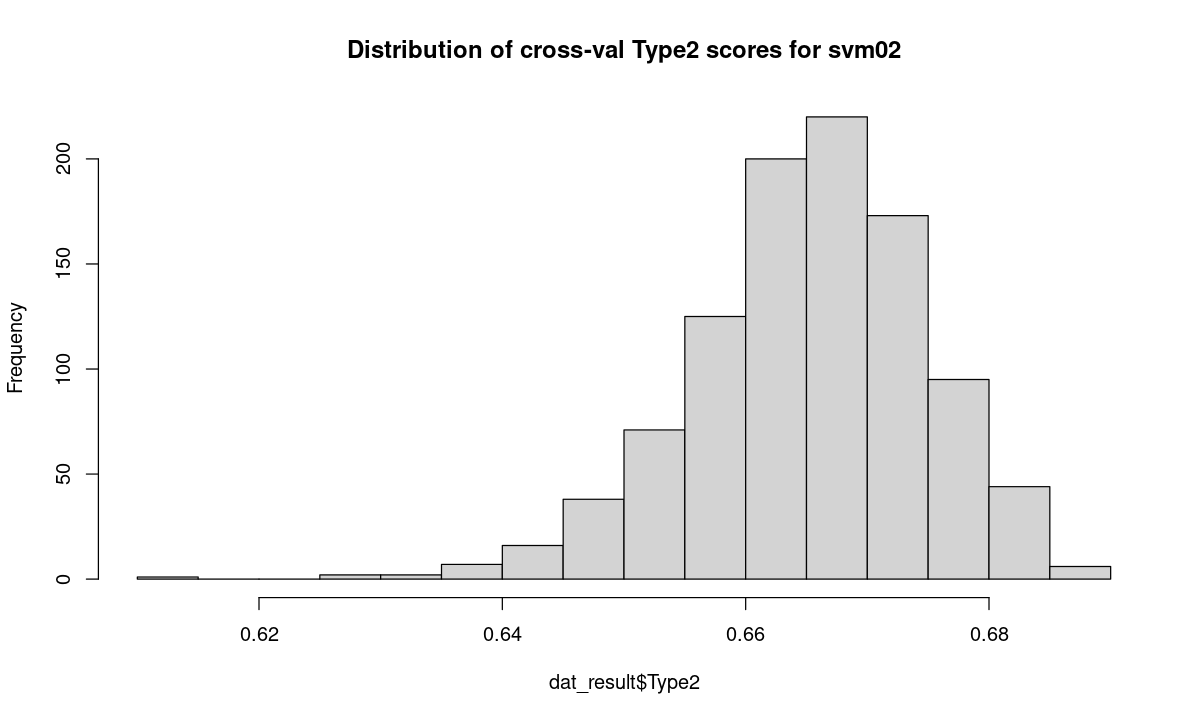

In [148]:
options(repr.plot.width= 10, repr.plot.height= 6)

hist(dat_result$Type2, breaks=12, main="Distribution of cross-val Type2 scores for svm02")


### Section Comments 

If we use cross-validation Type2 scores to identify the current best model, then our current best model is svm02 with an average cross-validation Type2 score over 5000 folds of 0.6652.  The next best model is the base k-means model, with weights; its average cross-val Type2 score over 5K folds is 0.6620.  The hybrid model's corresponding score is 0.6559.

The Type2 score is a weighted average of accuracy (40%) and f-score (60%).  The f-score is the harmonic mean between recall and precision.  The Type2 scores in this comparison are close enough that the three models might all have the same average accuracy over the 5K folds.

Applied to the test set, the svm02 model has 2X as many false negatives (FNs) as false positives (FPs), whereas the base k-means model, with weights, has 5.5X as many FPs as FNs.  Perhaps with the hybrid model the probabilities from svm02 make it slightly more difficult for the k-means model to separate the survivors from the non-survivors due to the different directions in this lack of balance.  In any case, it is worth seeing what the effect is of adding another set of probabilities, this time from our current best gradient boost model.  The added dimension might help the k-means algorithm perform better.


                                  * * * * * 

# Section 5: Hybrid model with 2 probability columns

Our next best model after svm02, constructed using cross-validation, is the gradient boosting model (gbclf_best).  So I will use this model to generate the probabilities for the prob02 column.

In [12]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from gridSearch06.

get_cvScore_kmp1p2 <- function(traindat, valdat, seed, wghts) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, Daysrec, and prob01.)
    
    set.seed(123)
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 130,
                  distribution= "bernoulli", shrinkage= 0.02)
    preds02 <- suppressMessages(predict(gbmod, newdata= traindat, type="response"))
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Outcome, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.01, cost= 20, scale=FALSE, probability=TRUE)
    
    preds01 <- predict(svmod, newdata=svm_scaled, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds01, "probabilities")[, 2])
    traindat$prob02 <- as.numeric(preds02)
    
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(svmval_scaled,
                                   row.names=rownames(valdat))
    
    # Compute prob01 and prob02.
    preds01_b <- predict(svmod, newdata=svmval_scaled, probability=TRUE)
    preds02_b <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    valdat$prob02 <- as.numeric(preds02_b)
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.  (We want valdat to look exactly like
    # traindat.  The weights act as a transformation of the data.)
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    set.seed(seed)
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat_wghts$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")

    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                      SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 6)
    return(result)
}


### Find best set of weights: hybrid model with prob01, prob02

In [19]:
# There are 5 parameter lists to work with.  Again, the
# best approach, perhaps, is to start by exploring the 
# region around the space where all parameters have an 
# equal weight---in this case, a weight of 0.20.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- lst[[5]] <- seq(0.14, 0.26, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  1451     5


[1] 1451    5

In [ ]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


In [ ]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 10, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, traindat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 25.14 secs (for 10 rows)


In [ ]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


In [ ]:
dfc01[best_params,]

best_Type2


In [30]:
# Find the best weights of those in dfc01 (1451 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 1.14 hours


[1] "Start time: 2021-04-08 13:46:55"

Time difference of 1.1 hours

In [31]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [32]:
dfc01[best_params,]
#   	     AST 	  CK  	Daysrec 	prob01  	prob02

# 14476 	0.26 	0.18	   0.16 	  0.14  	  0.26


best_Type2
# 0.64705


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14476,0.26,0.18,0.16,0.14,0.26


[1] 0.64705

In [33]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.24, 0.32, by= 0.02)
lst[[2]] <- seq(0.14, 0.22, by= 0.02)
lst[[3]] <- seq(0.12, 0.18, by= 0.02)
lst[[4]] <- seq(0.10, 0.16, by=0.02)
lst[[5]] <- seq(0.24, 0.32, by=0.02)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  251     5


[1] 251   5

In [34]:
# Add no weights to the combinations.  This will 
# tell us whether using weights is better than not
# using weights.  

dfc02 <- rbind(dfc02, rep(1,5))


In [35]:
# Find the best weights of those in dfc02 (252 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 12.26 mins


[1] "Start time: 2021-04-08 14:59:14"

Time difference of 11.69 mins

In [36]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [37]:
dfc02[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

#  484  	0.30 	0.16	   0.18 	  0.10  	  0.26

best_Type2
# 0.65093


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
484,0.3,0.16,0.18,0.1,0.26


[1] 0.65093

In [38]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.28, 0.33, by= 0.01)
lst[[2]] <- seq(0.13, 0.18, by= 0.01)
lst[[3]] <- seq(0.15, 0.21, by= 0.01)
lst[[4]] <- seq(0.05, 0.11, by=0.01)
lst[[5]] <- seq(0.23, 0.30, by=0.01)

start <- Sys.time()
dfc03 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc03)
#  1183     5


[1] 1183    5

In [39]:
# Find the best weights of those in dfc02 (1183 rows,
# 11 seeds, 5 folds).

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 55 mins


[1] "Start time: 2021-04-08 15:18:18"

Time difference of 54.93 mins

In [40]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [41]:
dfc03[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

# 4461  	0.30 	0.18	   0.19 	  0.08  	  0.25

best_Type2
# 0.6518


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4461,0.3,0.18,0.19,0.08,0.25


[1] 0.65184

In [43]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.27, 0.31, by= 0.01)
lst[[2]] <- seq(0.15, 0.19, by= 0.01)
lst[[3]] <- seq(0.17, 0.21, by= 0.01)
lst[[4]] <- seq(0.05, 0.10, by=0.01)
lst[[5]] <- seq(0.23, 0.27, by=0.01)

start <- Sys.time()
dfc04 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc04)
#  340     5


[1] 340   5

In [44]:
# Find the best weights of those in dfc02 (340 rows,
# 11 seeds, 5 folds).

set.seed(42)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc04) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 16.28 mins


[1] "Start time: 2021-04-08 16:45:42"

Time difference of 16.28 mins

In [45]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [46]:
dfc04[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

# 3234  	0.30 	0.16	   0.21 	  0.06  	  0.27

best_Type2
# 0.6467


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3234,0.3,0.16,0.21,0.06,0.27


[1] 0.6467

In [47]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.28, 0.31, by= 0.01)
lst[[2]] <- seq(0.14, 0.17, by= 0.01)
lst[[3]] <- seq(0.20, 0.24, by= 0.01)
lst[[4]] <- seq(0.04, 0.07, by=0.01)
lst[[5]] <- seq(0.25, 0.28, by=0.01)

start <- Sys.time()
dfc05 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc05)
#  175     5


[1] 175   5

In [48]:
# Find the best weights of those in dfc02 (175 rows,
# 11 seeds, 5 folds).

set.seed(1237)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc05) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 8.33 mins


[1] "Start time: 2021-04-08 17:07:27"

Time difference of 8.33 mins

In [49]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [50]:
dfc05[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

# 228    	0.31 	0.14	   0.24 	  0.06  	  0.25

best_Type2
# 0.6489


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
228,0.31,0.14,0.24,0.06,0.25


[1] 0.64891

In [51]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.29, 0.33, by= 0.01)
lst[[2]] <- seq(0.12, 0.16, by= 0.01)
lst[[3]] <- seq(0.22, 0.26, by= 0.01)
lst[[4]] <- seq(0.04, 0.07, by=0.01)
lst[[5]] <- seq(0.23, 0.27, by=0.01)

start <- Sys.time()
dfc06 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc06)
#  313     5


[1] 313   5

In [52]:
# Find the best weights of those in dfc02 (313 rows,
# 11 seeds, 5 folds).

set.seed(1237)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc06) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 15 mins


[1] "Start time: 2021-04-08 17:21:31"

Time difference of 14.96 mins

In [53]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [54]:
dfc06[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

# 1117    	0.30 	0.15	   0.26 	  0.04  	  0.25

best_Type2
# 0.6511


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1117,0.3,0.15,0.26,0.04,0.25


[1] 0.65112

In [55]:
# Refine the search.

lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- seq(0.29, 0.31, by= 0.01)
lst[[2]] <- seq(0.14, 0.16, by= 0.01)
lst[[3]] <- seq(0.25, 0.28, by= 0.01)
lst[[4]] <- seq(0.02, 0.05, by=0.01)
lst[[5]] <- seq(0.23, 0.27, by=0.01)

start <- Sys.time()
dfc06 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc06)
#  114     5


[1] 114   5

In [56]:
# Find the best weights of those in dfc02 (313 rows,
# 11 seeds, 5 folds).

set.seed(1237)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc06) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.36 mins


[1] "Start time: 2021-04-08 17:42:26"

Time difference of 5.36 mins

In [57]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [58]:
dfc06[best_params,]
#       	 AST 	  CK  	Daysrec 	prob01  	prob02

# 247    	0.29 	0.15	   0.28 	  0.04  	  0.24

best_Type2
# 0.6529


,AST,CK,Daysrec,prob01,prob02
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
247,0.29,0.15,0.28,0.04,0.24


[1] 0.65287

In [ ]:
### COMMENT:

# It is interesting that the weight on prob02 is 6X the
# weight on prob01.  This looks to be more evidence that
# the probabilities from the svm02 model are not 
# helping the k-means hybrid model.


### Cross-val score for hybrid model (p1 + p2), 1000 seeds

In [59]:
lst <- vector("list", length= 5)
names(lst) <- c("AST","CK","Daysrec","prob01","prob02")

lst[[1]] <- c(0.29)
lst[[2]] <- c(0.15)
lst[[3]] <- c(0.28)
lst[[4]] <- c(0.04)
lst[[5]] <- c(0.24)

dfc06 <- generate_combs(lst)


In [60]:
# Make sure gridSearch06 calls get_cvScore_kmp1p2.

set.seed(42)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc06) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.08 mins


[1] "Start time: 2021-04-08 17:51:20"

Time difference of 4.08 mins

In [61]:
dat_result
# Type2 score of 0.6517


row,Type2
<chr>,<dbl>
1,0.65172


## Section Comments

For the purpose of comparing model performance, the best scores we have thus far are those gotten when running against 1000 seeds; this equates to testing a model on 5000 folds, since for each seed we are computing an average cross-validation score over 5 folds (each fold having 64 records).

When we maintain the ratio between surviving cows and non-survivors across the folds, we are seeing that the best model is svm02, which has an average Type2 score over the 1000 seeds, or 5000 folds, of 0.6652.

The same score for the base k-means model with weights is 0.6620.

For the hybrid model with only prob01 (from svm02) and weights, this score is 0.6559.

And for the hybrid model with prob01 and prob02 and weights, this score is 0.6517.

In Part 2 of this project, we will make a similar comparison, but the folds will be ones in which the ratio between surviving cows and non-survivors is not maintained.  In the real world, when applying our models to new data, we would not expect this ratio to be the same as what we see in our training set. 

In Section 6 below, I collect even more accurate scores over the 1000 seeds.  From this information we can then determine if the differences we are seeing are statistically significant.

# Section 6: Measures for comparing the different models

A table at the end of this section summarizes all of the data collected in this section.

## Get more information over a 1000 seeds for each model

In [11]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the hybrid k-means model with both probability columns.

get_cvScores_kmp1p2 <- function(traindat, valdat) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, Daysrec, and prob01.)
    
    set.seed(123)
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 130,
                  distribution= "bernoulli", shrinkage= 0.02)
    preds02 <- suppressMessages(predict(gbmod, newdata= traindat, type="response"))
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Outcome, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.01, cost= 20, scale=FALSE, probability=TRUE)
    
    preds01 <- predict(svmod, newdata=svm_scaled, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds01, "probabilities")[, 2])
    traindat$prob02 <- as.numeric(preds02)
    
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  (Take square root.)
    
    wghts <- c(0.29, 0.15, 0.28, 0.04, 0.24)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec","prob01","prob02")
    
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(cbind(valdat$Outcome, svmval_scaled),
                                   row.names=rownames(valdat))
    colnames(svmval_scaled) <- colnames(valdat)
    
    # Compute prob01 and prob02.
    preds01_b <- predict(svmod, newdata=svmval_scaled, probability=TRUE)
    preds02_b <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    valdat$prob02 <- as.numeric(preds02_b)
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.  (We want valdat to look exactly like
    # traindat.  The weights act as a transformation of the data.)
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- cbind(as.numeric(valdat_scaled$Outcome), df2)
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat_scaled))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    set.seed(123)
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(as.numeric(ans[[2]]), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [18]:
# This function returns 5 cross-validation metrics for each
# seed in the seed vector, seedv.

get_cvInfo <- function(seedv, dat, folds=5) {
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * folds * seedv_len)
    dim(datout) <- c((seedv_len*folds), 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    # For each seed we record 5 sets of cross-val scores
    prefixes <- rep(as.character(seedv), rep(folds, seedv_len))
    suffixes <- rep(paste(1:folds), seedv_len)
    seed_names <- paste(prefixes, suffixes, sep="--")
    rownames(datout) <- seed_names
    
    # Get ratio of surviving to non-surviving cows.
    dat_surv <- dat[which(dat$Outcome==1),]
    dat_nonSurv <- dat[which(dat$Outcome==0),]
    surv_ratio <- round(nrow(dat_surv)/nrow(dat), 4)
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
        dat <- dat[smp,]
    
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        used_surv <- used_nonSurv <- c()
        
        # We want the ratio of survivors to non-survivors to be 
        # about the same in each fold.
        for(k in 1:folds) {
            surv_count <- round(surv_ratio * segmentsv[k])
            nonSurv_count <- segmentsv[k] - surv_count
            avail_survRows <- rownames(dat_surv)[which(!(rownames(dat_surv) %in% used_surv))]
            avail_nonSurvRows <- rownames(dat_nonSurv)[which(!(rownames(dat_nonSurv) %in% used_nonSurv))]
        
            if(k < folds) {
                smp01 <- sample(avail_survRows, surv_count, replace=FALSE)
                smp02 <- sample(avail_nonSurvRows, nonSurv_count, replace=FALSE)
            } else {
                smp01 <- avail_survRows
                smp02 <- avail_nonSurvRows
                stopifnot(length(c(smp01, smp02))== segmentsv[k])
            }
            used_surv <- c(used_surv, smp01)
            used_nonSurv <- c(used_nonSurv, smp02)
            row_list[[k]] <- c(smp01, smp02)
        } # end of for-loop, index k
        
        train_list <- test_list <- vector("list", length= folds)
        for(j in 1:folds) {
            testdat <- dat[row_list[[j]],]
            traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
            stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
            test_list[[j]] <- testdat
            train_list[[j]] <- traindat
        }
        # When there are only 5 folds, only 5 cores get used.
        scores <- mcmapply(get_cvScores_g03, train_list, test_list,
                           SIMPLIFY= "array", mc.cores=5)
        
        for(k in 1:folds) {
            row_name <- paste(as.character(cur_seed), k, sep="--")
            datout[row_name, 1:5] <- scores[, k]
        }

    } ## end of for-loop, index h
    
    return(datout)
}


In [27]:
# Get scores for the hybrid model with prob01 and prob02.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, traindat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4.01 mins


Time difference of 4.01 mins

In [28]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.6415,0.7031,0.6661,7,12
4782--2,0.6522,0.7500,0.6913,9,7
4782--3,0.6984,0.7031,0.7003,2,17
4782--4,0.5714,0.6719,0.6116,10,11
4782--5,0.5556,0.6250,0.5834,8,16
9275--1,0.5517,0.5938,0.5685,8,18


### Summary info for hybrid model with prob01, prob02

In [29]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6264
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0603
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6264"

[1] "fscore StdDev: 0.0603"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.392   0.588   0.627   0.626   0.667   0.889 

In [30]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.6887
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0521
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.6887"

[1] "accuracy StdDev: 0.0521"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.508   0.656   0.688   0.689   0.719   0.906 

In [31]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6513
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0556
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6513"

[1] "Type2 StdDev: 0.0556"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.438   0.614   0.653   0.651   0.688   0.896 

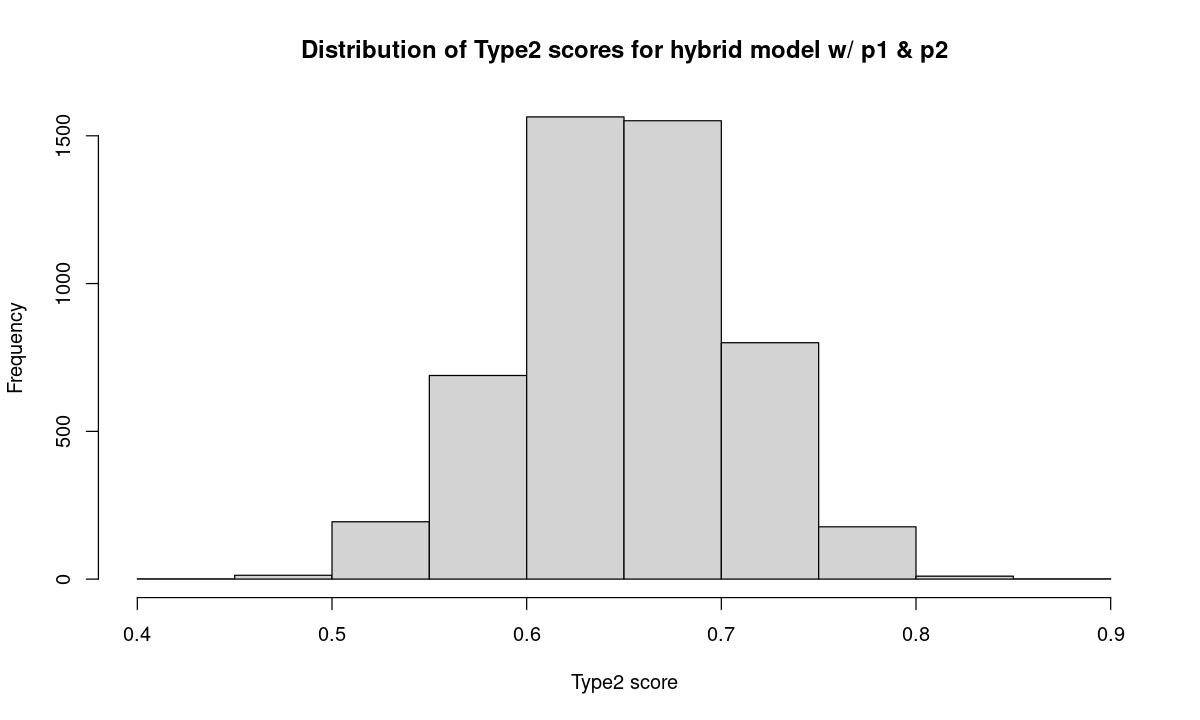

In [36]:
# Histogram of the Type2 scores for the hybrid model

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for hybrid model w/ p1 & p2")


In [32]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 7.06
paste0("FN StdDev: ", as.character(FN_sd))
# 2.13
""
summary(dat_result$FN)


[1] "FN mean: 7.057"

[1] "FN StdDev: 2.1338"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    6.00    7.00    7.06    8.00   15.00 

In [33]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 12.86
paste0("FP StdDev: ", as.character(FP_sd))
# 2.96
""
summary(dat_result$FP)


[1] "FP mean: 12.8646"

[1] "FP StdDev: 2.9614"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    4.0    11.0    13.0    12.9    15.0    24.0 

### Summary info for base k-means model with weights

In [38]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the base k-means model.

get_cvScores_kmBase <- function(traindat, valdat) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, and Daysrec.)
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.
    
    wghts <- c(0.54, 0.28, 0.18)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec")
    
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
       
    #############################
    # Prepare valdat for svm modeling.
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.  (We want valdat to look exactly like
    # traindat.  The weights act as a transformation of the data.)
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")

    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(as.numeric(ans[[2]]), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [40]:
# Get scores for the base k-means model.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, traindat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 2.91 mins


Time difference of 2.91 mins

In [41]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.6557,0.6719,0.6622,4,17
4782--2,0.6667,0.7344,0.6938,7,10
4782--3,0.7097,0.7188,0.7133,2,16
4782--4,0.6071,0.6562,0.6267,7,15
4782--5,0.6182,0.6719,0.6397,6,15
9275--1,0.6032,0.6094,0.6057,5,20


In [42]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6454
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0565
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6454"

[1] "fscore StdDev: 0.0565"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.436   0.607   0.644   0.645   0.679   0.836 

In [43]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.6861
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0533
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.6861"

[1] "accuracy StdDev: 0.0533"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.500   0.656   0.688   0.686   0.719   0.859 

In [44]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6617
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0542
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6617"

[1] "Type2 StdDev: 0.0542"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.468   0.627   0.661   0.662   0.700   0.846 

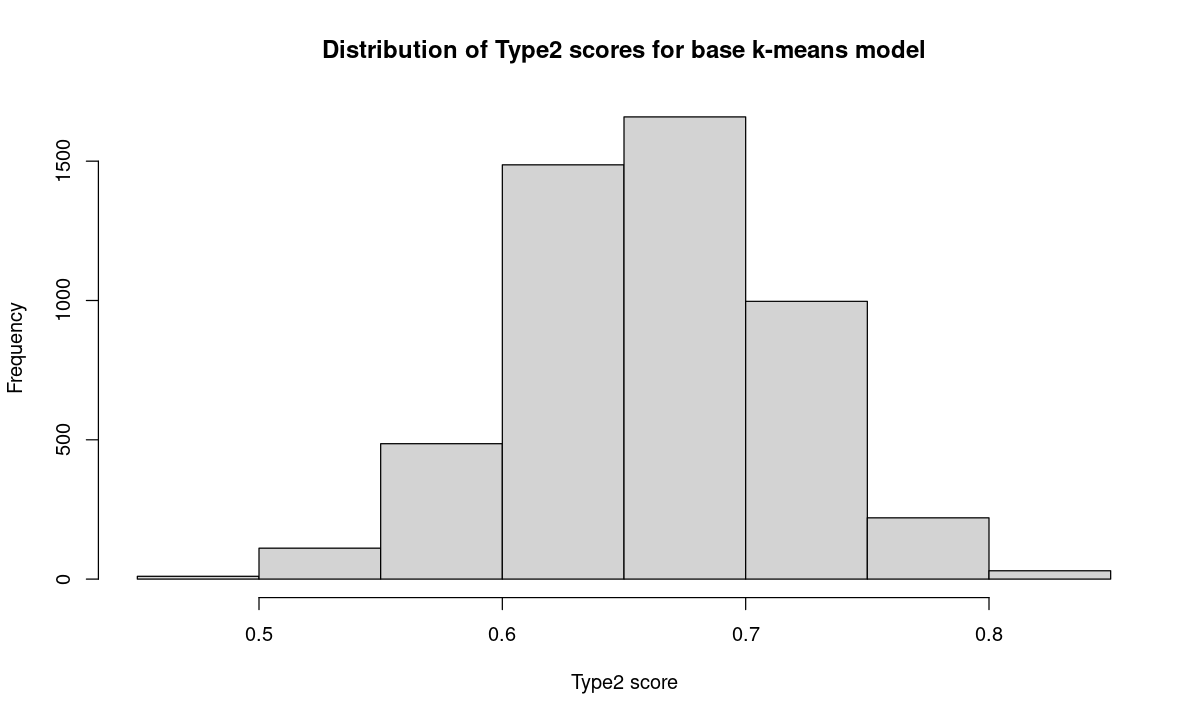

In [45]:
# Histogram of the Type2 scores for the base k-means model.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for base k-means model")


In [46]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 5.51
paste0("FN StdDev: ", as.character(FN_sd))
# 1.96
""
summary(dat_result$FN)


[1] "FN mean: 5.5096"

[1] "FN StdDev: 1.9622"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    4.00    5.00    5.51    7.00   13.00 

In [47]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 14.58
paste0("FP StdDev: ", as.character(FP_sd))
# 2.91
""
summary(dat_result$FP)


[1] "FP mean: 14.5824"

[1] "FP StdDev: 2.9105"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    5.0    13.0    15.0    14.6    17.0    26.0 

### Summary info for hybrid model with prob01 generated from svm02

In [48]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the hybrid k-means model with the prob01 column.

get_cvScores_kmp1 <- function(traindat, valdat) {
    
    # Scale traindat for purpose of an svm model.
    svm_scaled <- scale(traindat[, -1])
    svm_centers <- attr(svm_scaled, "scaled:center")
    svm_scales <- attr(svm_scaled, "scaled:scale")
    svm_scaled <- as.data.frame(cbind(traindat$Outcome, svm_scaled),
                                row.names=rownames(traindat))
    colnames(svm_scaled) <- colnames(traindat)
    
    # This is our current best svm model for the trainset data
    svmod <- svm(I(as.factor(Outcome)) ~ ., data=svm_scaled, kernel="radial",
                 gamma= 0.01, cost= 20, scale=FALSE, probability=TRUE)
    
    preds01 <- predict(svmod, newdata=svm_scaled, probability=TRUE)
    traindat$prob01 <- as.numeric(attr(preds01, "probabilities")[, 2])
    
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    
    #############################
    # Apply weights to traindat.
    
    wghts <- c(0.23, 0.29, 0.33, 0.15)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec","prob01")
    
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
       
    #############################
    # Prepare valdat for svm modeling.
    
    svmval_scaled <- scale(valdat[, -1], center=svm_centers, scale=svm_scales)
    svmval_scaled <- as.data.frame(cbind(valdat$Outcome, svmval_scaled),
                                   row.names=rownames(valdat))
    colnames(svmval_scaled) <- colnames(valdat)
    
    # Compute the prob01 column.
    preds01_b <- predict(svmod, newdata=svmval_scaled, probability=TRUE)
    valdat$prob01 <- as.numeric(attr(preds01_b, "probabilities")[, 2])
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.  (We want valdat to look exactly like
    # traindat.  The weights act as a transformation of the data.)
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.
    
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                          row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")
    
    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(as.numeric(ans[[2]]), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [50]:
# Get scores for the hybrid model with prob01.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, traindat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.56 mins


Time difference of 3.56 mins

In [51]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.6538,0.7188,0.6798,7,11
4782--2,0.6250,0.7188,0.6625,9,9
4782--3,0.7333,0.7500,0.7400,2,14
4782--4,0.5556,0.6250,0.5834,9,15
4782--5,0.5556,0.6250,0.5834,8,16
9275--1,0.5667,0.5938,0.5775,7,19


In [52]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.632
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0598
""
summary(dat_result$fscore)


[1] "fscore mean: 0.632"

[1] "fscore StdDev: 0.0598"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.377   0.593   0.632   0.632   0.667   0.873 

In [53]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.6918
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0521
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.6918"

[1] "accuracy StdDev: 0.0521"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.477   0.656   0.688   0.692   0.734   0.891 

In [54]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6559
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0557
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6559"

[1] "Type2 StdDev: 0.0557"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.417   0.618   0.656   0.656   0.694   0.880 

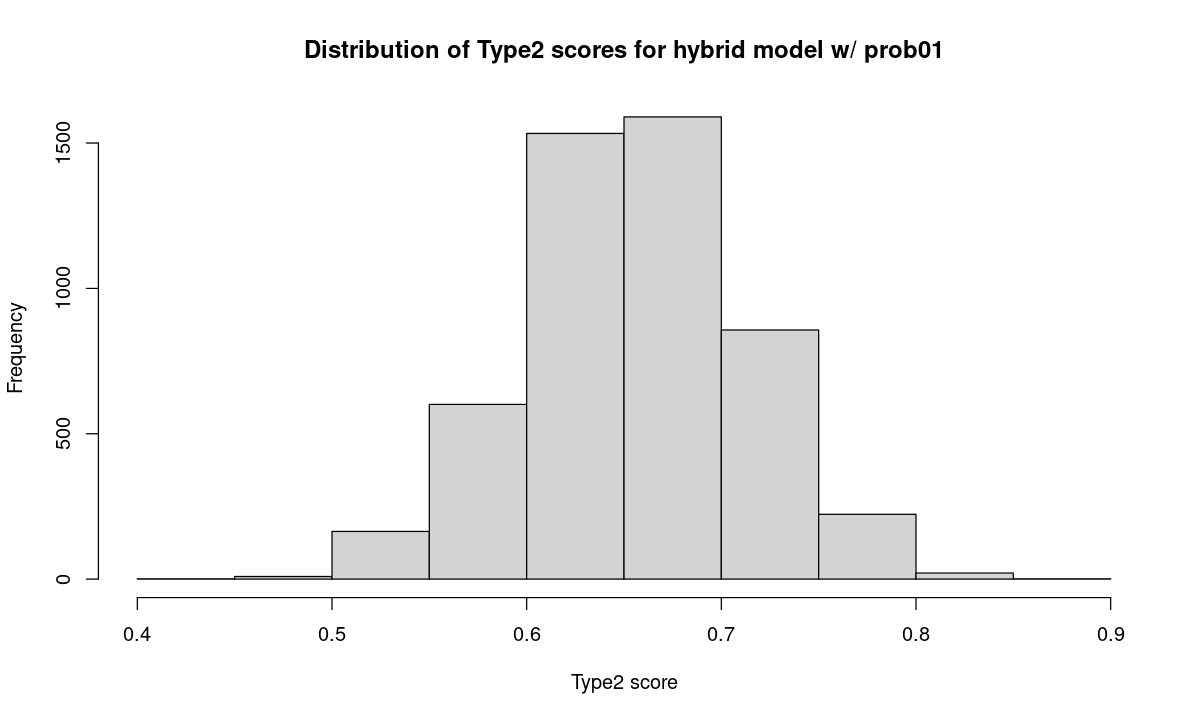

In [55]:
# Histogram of the Type2 scores for the hybrid model with prob01.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for hybrid model w/ prob01")


In [56]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 6.83
paste0("FN StdDev: ", as.character(FN_sd))
# 1.99
""
summary(dat_result$FN)


[1] "FN mean: 6.8334"

[1] "FN StdDev: 1.9892"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    5.00    7.00    6.83    8.00   14.00 

In [57]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 12.89
paste0("FP StdDev: ", as.character(FP_sd))
# 2.73
""
summary(dat_result$FP)


[1] "FP mean: 12.8926"

[1] "FP StdDev: 2.728"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    4.0    11.0    13.0    12.9    15.0    24.0 

### Summary info for the svm02 model

In [58]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the svm02 model.

get_cvScores_svm02 <- function(traindat, valdat) {
    
    # traindat and valdat need to be scaled
    train_scaled <- scale(traindat[, -1])
    train_centers <- attr(train_scaled, "scaled:center")
    train_scales <- attr(train_scaled, "scaled:scale")
    train_scaled <- as.data.frame(cbind(traindat$Outcome, train_scaled),
                                  row.names=rownames(traindat))
    colnames(train_scaled) <- colnames(traindat)
    
    svmmod <- svm(I(as.factor(Outcome)) ~ ., data=train_scaled, kernel="radial",
                  gamma= 0.01, cost= 20, scale=FALSE, probability=TRUE)
    
    # Scale valdat.
    test_scaled <- scale(valdat[, -1], center=train_centers,
                         scale=train_scales)
    test_scaled <- as.data.frame(cbind(valdat$Outcome,test_scaled), 
                                 row.names=rownames(valdat))
    colnames(test_scaled) <- colnames(valdat)
    
    preds <- predict(svmmod, newdata= test_scaled)
    ans <- table(preds, as.factor(valdat$Outcome))

    mat <- as.matrix(ans)
    fscore <- round(get_fscore(mat), 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * fscore), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [60]:
# Get scores for the svm02 model.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, traindat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 40.18 secs


Time difference of 40.18 secs

In [61]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.6538,0.7188,0.6798,11,7
4782--2,0.6512,0.7656,0.6970,5,10
4782--3,0.7586,0.7812,0.7676,12,2
4782--4,0.5714,0.6719,0.6116,11,10
4782--5,0.5098,0.6094,0.5496,15,10
9275--1,0.5818,0.6406,0.6053,15,8


In [62]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6337
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0653
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6337"

[1] "fscore StdDev: 0.0653"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.378   0.590   0.636   0.634   0.679   0.863 

In [63]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7104
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0526
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7104"

[1] "accuracy StdDev: 0.0526"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.516   0.672   0.719   0.710   0.750   0.891 

In [64]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6644
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.059
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6644"

[1] "Type2 StdDev: 0.059"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.442   0.625   0.666   0.664   0.701   0.874 

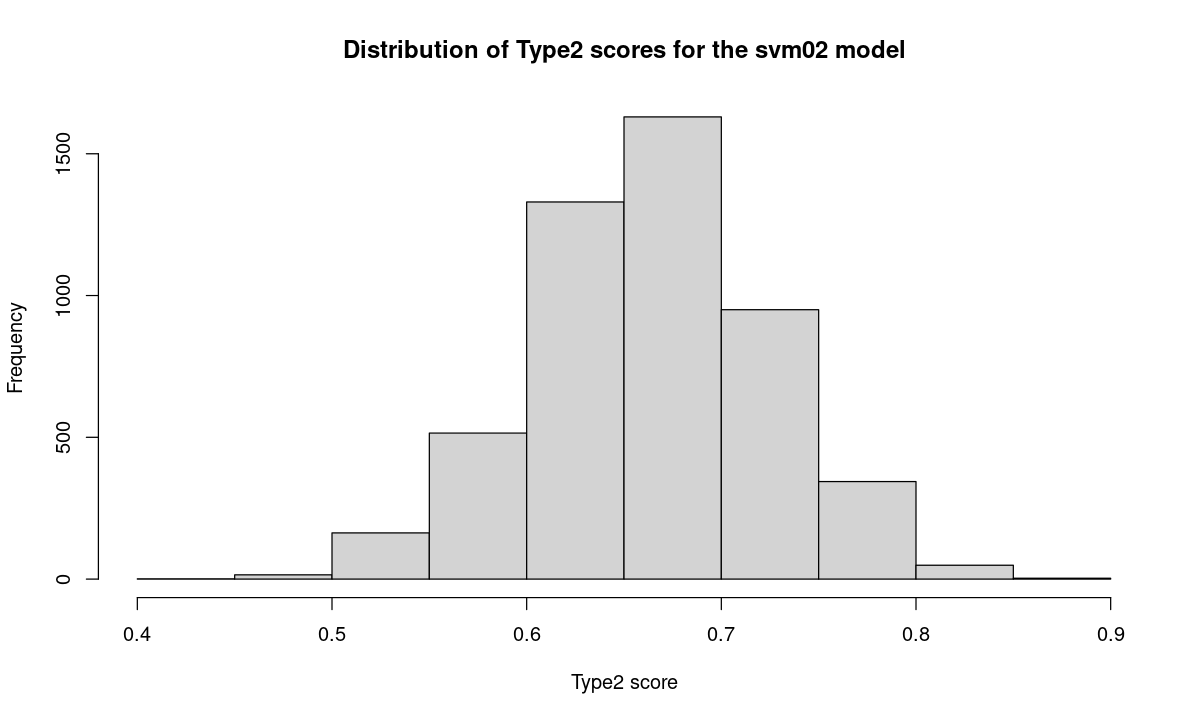

In [65]:
# Histogram of the Type2 scores for the svm02 model.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for the svm02 model")


In [66]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 10.82
paste0("FN StdDev: ", as.character(FN_sd))
# 2.82
""
summary(dat_result$FN)


[1] "FN mean: 10.817"

[1] "FN StdDev: 2.819"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0     9.0    11.0    10.8    13.0    24.0 

In [67]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 7.72
paste0("FP StdDev: ", as.character(FP_sd))
# 2.16
""
summary(dat_result$FP)


[1] "FP mean: 7.718"

[1] "FP StdDev: 2.155"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    6.00    8.00    7.72    9.00   17.00 

In [1]:
results <- read.csv("/home/greg/Documents/stat/github_repos/cows/model_results.csv", 
                    header=TRUE, row.names=1)
dim(results)


[1]  4 10

In [ ]:
#&* Bookmark

In [2]:
# The following table is a summary of all the 
# Section 6 results from above.  The Type2 score
# is a weighted average of accuracy (40%) and
# f-score (60%).

results


,fscore,fscore_sd,Type2,Type2_sd,accuracy,acc_sd,FN,FN_sd,FP,FP_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
svm02,0.6337,0.0653,0.6644,0.0590,0.7104,0.0526,10.82,2.82,7.72,2.16
k-means,0.6454,0.0565,0.6617,0.0542,0.6861,0.0533,5.51,1.96,14.58,2.91
km_p1,0.6320,0.0598,0.6559,0.0557,0.6918,0.0521,6.83,1.99,12.89,2.73
km_p1p2,0.6264,0.0603,0.6513,0.0556,0.6887,0.0521,7.06,2.13,12.86,2.96


## Section Comments

The above table shows that the svm02 model outperforms the other models in terms of accuracy, with an average accuracy rate of 71%.  The next best model in terms of accuracy is the k-means model with the prob01 column; it has an accuracy of 69.2%.  The difference between these two mean scores is statistically significant: the Z-statistic (difference in means divided by pooled variance) is 17.765, giving us a two-tailed p-value of 1.32e-70.  This means that there is also a statistically significant difference between the accuracy scores of svm02 and the base k-means model.

The Type2 score is a broader, or less-specialized, metric.  Comparing the Type2 of the base k-means model with svm02, the Z-statistic is 2.38, giving us a two-tailed p-value of 0.017.  So we have a statistically significant difference at the 0.05 level but not at the 0.01 level.  Given how large n is (the measures are averages over 5000 folds, each fold having 64 records), I would want the significance level to be at 0.01 or smaller.  Arguably, then, there is reason to think that there is not a true difference in Type2 scores between the two models.

The base k-means model has a better f-score than the svm02 model.  This difference is statistically significant: the Z-statistic is 9.581, giving us a two-tailed p-value of 9.61e-22.

Overall, then, it appears that the svm02 and base k-means model are about equivalent in terms of performance.  But if we want a low false-positive rate, the svm02 model will be preferable.  If we want a low false negative rate, the base k-means model is preferable.

The above table shows us that the prob01 and prob02 columns do not help the k-means modeling by much.  Some qualification is needed here because, although the Type2 score decreases with each added probability column, the accuracy increases a bit.  In Part 2 I will generate the very same table but for the scenario in which the ratio of the Outcome levels is not maintained between training and validation sets.  It may be that a prob01 and/or prob02 column will make a more positive difference under such conditions.


# Section 7: Hybrid model using gbclf_best for prob01

See whether we get a better hybrid model using the gradient boosting model to generate prob01 probabilities. 

Before constructing the hybrid model, I get summary scores for the gbclf_best model.  We need these for the type of table we see immediately above.

## Summary info for gbclf_best

In [10]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the gbclf_best model.

get_cvScores_gbclf <- function(traindat, valdat) {
    
    set.seed(123)
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 130,
                  distribution= "bernoulli", shrinkage= 0.02)
    
    preds <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    preds[which(preds >= 0.5)] <- 1
    preds[which(preds < 0.5)] <- 0
    names(preds) <- rownames(valdat)
    preds <- as.factor(preds)
    
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(ans[[2]], 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * fscore), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [12]:
# Get summary scores for gbclf_best, 1000 seeds.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, traindat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 35.47 secs


Time difference of 35.47 secs

In [13]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.5652,0.6875,0.6141,11,9
4782--2,0.6341,0.7656,0.6867,11,4
4782--3,0.7925,0.8281,0.8067,3,8
4782--4,0.5652,0.6875,0.6141,11,9
4782--5,0.5217,0.6562,0.5755,11,11
9275--1,0.5556,0.6250,0.5834,9,15


In [14]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.613
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0745
""
summary(dat_result$fscore)


[1] "fscore mean: 0.613"

[1] "fscore StdDev: 0.0745"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.303   0.565   0.619   0.613   0.667   0.851 

In [15]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7264
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0494
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7264"

[1] "accuracy StdDev: 0.0494"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.562   0.688   0.734   0.726   0.766   0.891 

In [16]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6583
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0631
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6583"

[1] "Type2 StdDev: 0.0631"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.436   0.616   0.660   0.658   0.700   0.867 

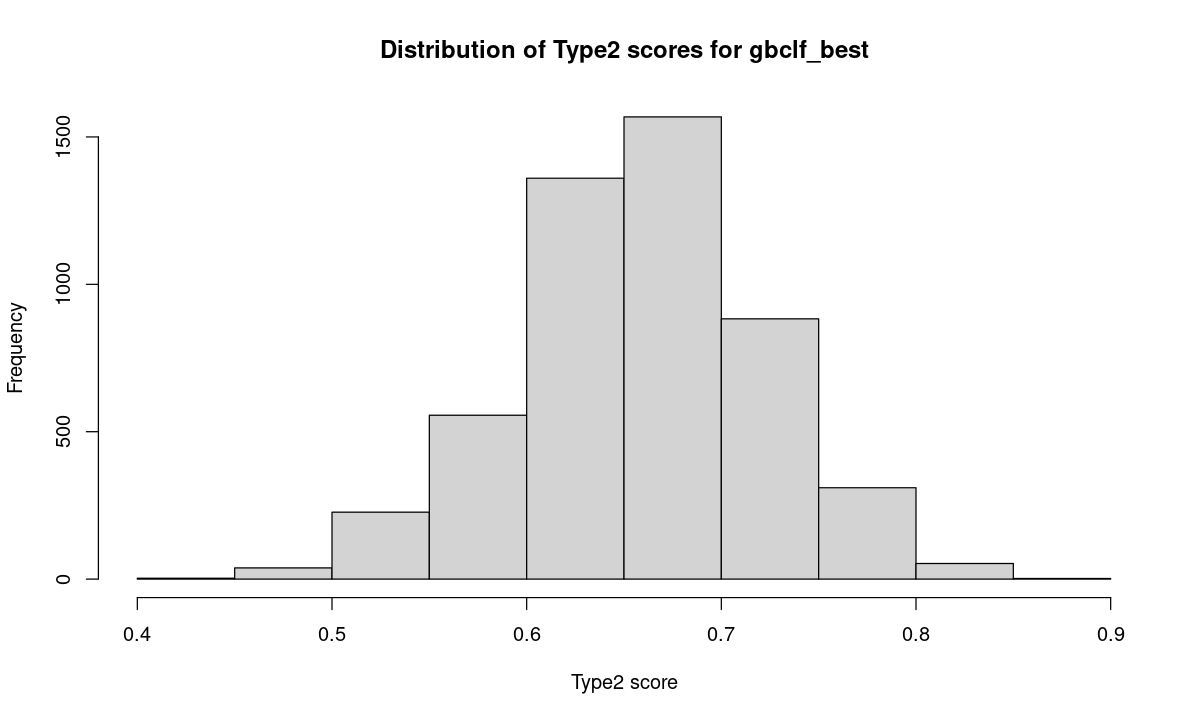

In [17]:
# Histogram of the Type2 scores for the svm02 model.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for gbclf_best")


In [18]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 9.81
paste0("FN StdDev: ", as.character(FN_sd))
# 2.31
""
summary(dat_result$FN)


[1] "FN mean: 9.811"

[1] "FN StdDev: 2.3125"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    8.00   10.00    9.81   11.00   19.00 

In [19]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 7.70
paste0("FP StdDev: ", as.character(FP_sd))
# 2.52
""
summary(dat_result$FP)


[1] "FP mean: 7.6994"

[1] "FP StdDev: 2.5233"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     6.0     8.0     7.7     9.0    18.0 

## Find best set of weights for the new hybrid model

In [9]:
# Function for obtaining average of confusion matrix 
# f-score and percent correctly answered. This function
# is called from gridSearch06.  It uses a gradient boosting
# model instead of an svm to generate prob01

get_cvScore_kmp1_v02 <- function(traindat, valdat, seed, wghts) {
    
    # wghts is a named vector of weights to apply.  The names, and
    # order of the weights, correspond to the colnames of traindat
    # below.  (Here the names are: AST, CK, Daysrec, and prob01.)
    
    # This is our current best gb model for the trainset data
    set.seed(123)
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 130,
                  distribution= "bernoulli", shrinkage= 0.02)
    
    preds01 <- suppressMessages(predict(gbmod, newdata= traindat, type="response"))
    preds01[which(preds01 >= 0.5)] <- 1
    preds01[which(preds01 < 0.5)] <- 0
    traindat$prob01 <- preds01
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.  The sqrt should have
    # been taken in the calling function.
    
    cols <- names(wghts)
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
       
    #############################
    # Prepare valdat.
    
    # Compute the prob01 column.
    preds01_b <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    preds01_b[which(preds01_b >= 0.5)] <- 1
    preds01_b[which(preds01_b < 0.5)] <- 0
    valdat$prob01 <- preds01_b
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.  (We want valdat to look exactly like
    # traindat.  The weights act as a transformation of the data.)
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    #############################
    # Construct k-means model.
    
    set.seed(seed)
    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")

    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    # The result returned is a Type2 score (which is a mixture
    # of accuracy and f-score).
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 6)
    return(result)
}


In [11]:
# There are 4 parameter lists to work with. 

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- lst[[2]] <- lst[[3]] <- lst[[4]] <- seq(0.13, 0.37, by=0.02)

start <- Sys.time()
dfc01 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc01)
#  1469     4


[1] 1469    4

In [ ]:
# Test on a sample of 10.

set.seed(42)
smp <- sample(rownames(dfc01), 10, replace=FALSE)
tst_params <- dfc01[smp,]
head(tst_params)


In [ ]:
# Find the best weights of those in tst_params.

set.seed(1233)
seed_vector <- sample(1:9999, 10, replace=FALSE)

start <- Sys.time()
dat_result <- gridSearch06(seed_vector, traindat, tst_params) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 16 secs (for 10 rows)


In [ ]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


In [ ]:
dfc01[best_params,]

best_Type2


In [16]:
# Find the best weights of those in dfc01 (1469 rows,
# 11 seeds, 5 folds). 

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc01) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 53.12 mins


[1] "Start time: 2021-04-15 07:31:13"

Time difference of 53.12 mins

In [17]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [18]:
dfc01[best_params,]
#   	 AST 	  CK  	Daysrec 	prob01

# 5941	0.37 	0.15	   0.31 	  0.17


best_Type2
# 0.67459


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
5941,0.37,0.15,0.31,0.17


[1] 0.67459

In [19]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.34, 0.40, by= 0.01)
lst[[2]] <- seq(0.12, 0.17, by= 0.01)
lst[[3]] <- seq(0.28, 0.35, by= 0.01)
lst[[4]] <- seq(0.12, 0.18, by=0.01)

start <- Sys.time()
dfc02 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc02)
#  201     4


[1] 201   4

In [20]:
# Find the best weights of those in dfc01 (201 rows,
# 11 seeds, 5 folds). 

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc02) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 7.23 mins


[1] "Start time: 2021-04-15 08:29:59"

Time difference of 7.23 mins

In [21]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [22]:
dfc02[best_params,]
#   	 AST 	  CK  	Daysrec 	prob01

# 1778	0.40 	0.13	   0.30 	  0.17


best_Type2
# 0.67495


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
1778,0.4,0.13,0.3,0.17


[1] 0.67495

In [23]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.39, 0.45, by= 0.01)
lst[[2]] <- seq(0.10, 0.16, by= 0.01)
lst[[3]] <- seq(0.28, 0.34, by= 0.01)
lst[[4]] <- seq(0.15, 0.19, by=0.01)

start <- Sys.time()
dfc03 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc03)
#  133     4


[1] 133   4

In [24]:
# Find the best weights of those in dfc01 (133 rows,
# 11 seeds, 5 folds). 

set.seed(1233)
seed_vector <- sample(1:9999, 11, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc03) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5.32 mins


[1] "Start time: 2021-04-15 08:44:39"

Time difference of 5.32 mins

In [25]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [26]:
dfc03[best_params,]
#   	 AST 	  CK  	Daysrec 	prob01

# 21 	0.45 	0.12	   0.28 	  0.15


best_Type2
# 0.67731


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
21,0.45,0.12,0.28,0.15


[1] 0.67731

In [27]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.43, 0.48, by= 0.01)
lst[[2]] <- seq(0.09, 0.14, by= 0.01)
lst[[3]] <- seq(0.25, 0.29, by= 0.01)
lst[[4]] <- seq(0.12, 0.17, by=0.01)

start <- Sys.time()
dfc04 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc04)
#  115     4


[1] 115   4

In [28]:
# Find the best weights of those in dfc01 (115 rows,
# 33 seeds, 5 folds).  I have increased the seeds so
# that we get a more stable result.

set.seed(1233)
seed_vector <- sample(1:9999, 33, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc04) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 14.22 mins


[1] "Start time: 2021-04-15 08:53:43"

Time difference of 14.22 mins

In [29]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [30]:
dfc04[best_params,]
#   	 AST 	  CK  	Daysrec 	prob01

# 21 	0.48 	0.12	   0.25 	  0.15


best_Type2
# 0.67726


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
564,0.48,0.12,0.25,0.15


[1] 0.67726

In [31]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.47, 0.54, by= 0.01)
lst[[2]] <- seq(0.09, 0.14, by= 0.01)
lst[[3]] <- seq(0.20, 0.26, by= 0.01)
lst[[4]] <- seq(0.14, 0.16, by=0.01)

start <- Sys.time()
dfc05 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc05)
# 106   4


[1] 106   4

In [32]:
# Find the best weights of those in dfc01 (106 rows,
# 33 seeds, 5 folds). 

set.seed(1233)
seed_vector <- sample(1:9999, 33, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc05) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 13.2 mins


[1] "Start time: 2021-04-15 09:12:10"

Time difference of 13.2 mins

In [33]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [34]:
dfc05[best_params,]
#   	 AST 	  CK  	Daysrec 	prob01

# 21 	0.54 	0.12	   0.20 	  0.14


best_Type2
# 0.67876


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
32,0.54,0.12,0.2,0.14


[1] 0.67876

In [35]:
# Refine the search.

lst <- vector("list", length= 4)
names(lst) <- c("AST","CK","Daysrec","prob01")

lst[[1]] <- seq(0.53, 0.60, by= 0.01)
lst[[2]] <- seq(0.09, 0.14, by= 0.01)
lst[[3]] <- seq(0.15, 0.20, by= 0.01)
lst[[4]] <- seq(0.11, 0.15, by=0.01)

start <- Sys.time()
dfc06 <- generate_combs(lst)
stop <- Sys.time()
# round(stop - start, 2)

dim(dfc06)
# 141   4


[1] 141   4

In [36]:
# Find the best weights of those in dfc01 (141 rows,
# 33 seeds, 5 folds).

# Using a new seed.
set.seed(7731)
seed_vector <- sample(1:9999, 33, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- gridSearch06(seed_vector, traindat, dfc06) 
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 17.7 mins


[1] "Start time: 2021-04-15 09:28:41"

Time difference of 17.7 mins

In [37]:
# Find the best parameters among those searched over.

best_params <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$row
length(best_params)

best_Type2 <- dat_result[which(dat_result$Type2 == 
                                max(dat_result$Type2, na.rm=TRUE)),]$Type2


[1] 1

In [38]:
dfc06[best_params,]
#   	 AST 	  CK  	Daysrec 	prob01

# 789 	0.57 	0.11	   0.19 	  0.13


best_Type2
# 0.68179


,AST,CK,Daysrec,prob01
,<dbl>,<dbl>,<dbl>,<dbl>
789,0.57,0.11,0.19,0.13


[1] 0.68179

## Summary info for the new hybrid model using gbclf_best

In [49]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order.  The scores are for
# the hybrid k-means model with the prob01 column generated
# by the gbclf_best model.

get_cvScores_kmp1_v02 <- function(traindat, valdat) {
    
    # This is our current best gb model for the trainset data
    set.seed(123)
    gbmod <- gbm(Outcome ~ ., data= traindat, n.trees= 130,
                  distribution= "bernoulli", shrinkage= 0.02)
    
    preds01 <- suppressMessages(predict(gbmod, newdata= traindat, type="response"))
    preds01[which(preds01 >= 0.5)] <- 1
    preds01[which(preds01 < 0.5)] <- 0
    traindat$prob01 <- preds01
    
    #############################
    # Transform and scale training set data for the
    # k-means model.
    traindat$AST <- log(traindat$AST)
    traindat$CK <- log(traindat$CK)
    traindat$Daysrec <- sqrt(traindat$Daysrec)

    traindat_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
    centers <- attr(traindat_scaled, "scaled:center")
    scales <- attr(traindat_scaled, "scaled:scale")
    
    #############################
    # Apply weights to traindat.
    
    wghts <- c(0.57, 0.11, 0.19, 0.13)^0.5
    names(wghts) <- cols <- c("AST","CK","Daysrec","prob01")
    
    df2 <- t(t(traindat_scaled[, cols]) * as.numeric(wghts[cols]))
    traindat_wghts <- as.data.frame(df2, row.names=rownames(traindat))
    colnames(traindat_wghts) <- cols
    
    #############################
    # Prepare valdat.
    
    # Compute the prob01 column.
    preds01_b <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    preds01_b[which(preds01_b >= 0.5)] <- 1
    preds01_b[which(preds01_b < 0.5)] <- 0
    valdat$prob01 <- preds01_b
    
    # Transform and scale valdat.
    valdat$AST <- log(valdat$AST)
    valdat$CK <- log(valdat$CK)
    valdat$Daysrec <- sqrt(valdat$Daysrec)

    valdat_scaled <- scale(valdat[, -1], center=centers, scale=scales)
    valdat_scaled <- as.data.frame(valdat_scaled, row.names=rownames(valdat))
    
    # Apply weights to valdat.  (We want valdat to look exactly like
    # traindat.  The weights act as a transformation of the data.)
    df2 <- t(t(valdat_scaled[, cols]) * as.numeric(wghts[cols]))
    valdat_wghts <- as.data.frame(df2, row.names=rownames(valdat))
    colnames(valdat_wghts) <- cols
    
    
    #############################
    # Construct k-means model.

    kmod <- suppressWarnings(kmeans(traindat_wghts, 2, iter.max = 50, nstart=15))
    
    # See how the clusters are associated with Outcome.
    dfout <- as.data.frame(cbind(traindat$Outcome, kmod$cluster),
                           row.names=rownames(traindat))
    colnames(dfout) <- c("Outcome", "cluster")

    c1_to_Outcome1 <- c1_toLevel_1(dfout)
    
    #############################
    # Apply the k-means model to valdat_wghts.
    
    # Each element of the following list is a row of valdat_wghts.
    valdat_asList <- split(valdat_wghts[, colnames(kmod$centers)],
                           seq(nrow(valdat_wghts)))
    
    ctr_list <- vector("list", length= nrow(valdat))
    for(i in 1:nrow(valdat)) {
        
        ctr_list[[i]] <- kmod$centers
    }
    names(ctr_list) <- rownames(valdat)
    
    
    # Get the predictions for the validation set.
    cluster_assgns <- mcmapply(getCluster, valdat_asList, ctr_list,
                               SIMPLIFY=TRUE, mc.cores=6)
    valdat_wghts$cluster <- as.numeric(cluster_assgns)
    
    valdat_wghts$pred_Outcome <- NA
    if(c1_to_Outcome1) {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 1
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 0
    } else {
        valdat_wghts[which(valdat_wghts$cluster==1),]$pred_Outcome <- 0
        valdat_wghts[which(valdat_wghts$cluster==2),]$pred_Outcome <- 1
    }
    
    # Generate confusion matrix for the k-means clusters and
    # the corresponding f-score.
    preds <- as.factor(valdat_wghts$pred_Outcome)
    names(preds) <- rownames(valdat)
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(ans[[2]], 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * fscore), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [50]:
# Get scores for hybrid model with prob01 generated
# from gbclf_best.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, traindat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.25 mins


Time difference of 3.25 mins

In [51]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.5833,0.6875,0.6250,10,10
4782--2,0.6977,0.7969,0.7374,9,4
4782--3,0.7778,0.8125,0.7917,3,9
4782--4,0.5652,0.6875,0.6141,11,9
4782--5,0.5532,0.6719,0.6007,10,11
9275--1,0.5556,0.6250,0.5834,9,15


In [52]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6424
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0689
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6424"

[1] "fscore StdDev: 0.0689"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.381   0.596   0.640   0.642   0.694   0.857 

In [53]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7373
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0506
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7373"

[1] "accuracy StdDev: 0.0506"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.562   0.703   0.734   0.737   0.766   0.891 

In [54]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6644
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.059
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6804"

[1] "Type2 StdDev: 0.0605"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.466   0.639   0.682   0.680   0.722   0.871 

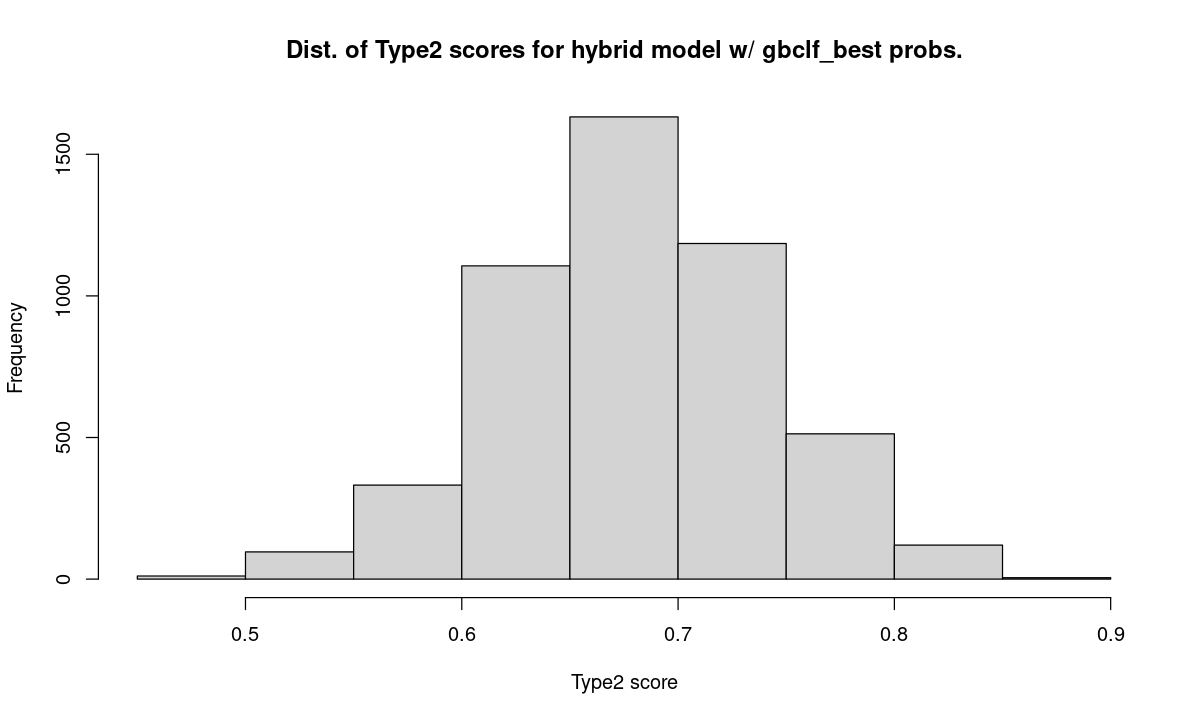

In [55]:
# Histogram of the Type2 scores for the svm02 model.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Dist. of Type2 scores for hybrid model w/ gbclf_best probs.")


In [56]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 8.63
paste0("FN StdDev: ", as.character(FN_sd))
# 2.11
""
summary(dat_result$FN)


[1] "FN mean: 8.6318"

[1] "FN StdDev: 2.1093"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    7.00    9.00    8.63   10.00   16.00 

In [57]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 8.18
paste0("FP StdDev: ", as.character(FP_sd))
# 2.56
""
summary(dat_result$FP)


[1] "FP mean: 8.1806"

[1] "FP StdDev: 2.5607"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    6.00    8.00    8.18   10.00   18.00 

In [20]:
results <- read.csv("/home/greg/Documents/stat/github_repos/cows/model_results_Part1.csv", 
                    header=TRUE, row.names=1)
dim(results)


[1]  6 10

In [ ]:
#&* Bookmark

In [21]:
# The following table is an updated summary of all of
# the 1000-seed results from above.  

results


,fscore,fscore_sd,Type2,Type2_sd,accuracy,acc_sd,FN,FN_sd,FP,FP_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gbclf,0.6130,0.0745,0.6583,0.0631,0.7264,0.0494,9.81,2.31,7.70,2.52
svm02,0.6337,0.0653,0.6644,0.0590,0.7104,0.0526,10.82,2.82,7.72,2.16
k-means,0.6454,0.0565,0.6617,0.0542,0.6861,0.0533,5.51,1.96,14.58,2.91
km_p1,0.6320,0.0598,0.6559,0.0557,0.6918,0.0521,6.83,1.99,12.89,2.73
km_p1p2,0.6264,0.0603,0.6513,0.0556,0.6887,0.0521,7.06,2.13,12.86,2.96
km_gbclf,0.6424,0.0689,0.6804,0.0605,0.7373,0.0506,8.63,2.11,8.18,2.56


## Final Comments for Part 1

Of the entries in the above table, the new hybrid model, km_gbclf, has the best Type2 score (0.6804) and the best accuracy score (0.7373).  It has the second-best f-score.  Comparing Type2 scores, the Z-statistic for the difference in means between km_gbclf and svm02 (which has the next best Type2 score) is 13.39.  Comparing accuracy scores between these two models, the Z-statistic is 26.06.  We can say with some confidence, then, that km_gbclf is a better model for the downer cow dataset than svm02.  On average, we see an increase in accuracy of 2.69 percentage points.  

km_gbclf has a much better Type2 score and much better accuracy score than the base k-means model.

km_gbclf has a much better Type2 score than the gbclf model itself.  Comparing accuracy scores between these two models, the Z-statistic is 10.90 (two-tailed p-value < 2e-16).  On average, the accuracy score for km_gbclf is about 1.1 percentage points better than gbclf_best.


The prob02 column for km_p1p2 is the outcome from gbclf_best.  But the accuracy score for km_gbclf is almost 5 percentage points better than that for km_p1p2, and km_gbclf's f-score is 1.6 percentage points better.  This adds to our evidence for thinking that the information from svm02 injected into the k-means model via prob01 conflicts with what is already there.  Furthermore, since the average number of false negatives and average number of false positives for gbclf are not much different from the same averages for svm02, the stark difference of these numbers from those for the base k-means model might not be the source of the conflict. 

When choosing svm02 for the prob01 column, I did so because it had a higher Type2 score than either the gradient boosting model or the best random forest model.  But of these three models, gbclf has the highest accuracy score.  Perhaps when adding a probability column to k-means, the choice needs to be made based on the accuracy score.


The work in this notebook shows that k-means can be used to boost the performance of models and even yield the best-performing model among those surveyed.  But we have also seen that the choices made in the construction of the hybrid model matter a lot: we need to choose the "right" model for constructing the prob01 column in order to get a model better than the competing models.  The work of Part 2 of this project also illustrates this fact, or truth.  And in Parts 3 and 4 we see that there is no guarantee that using k-means in this way will provide us with the best performing model.  But this is true about any modeling approach; there is no single algorithm or approach that will always provide us with the best predictive model.



                                        * * * * *





# Addendum

## Item 1: Get summary info for the g03 logistic model over 5000 folds

In [15]:
# This function is called by get_cvInfo.  It returns a vector
# of scores: f-score, accuracy, Type2, false negatives, and
# false positives, in the stated order. 
# (First alter get_cvInfo to call this function.)

get_cvScores_g03 <- function(traindat, valdat) {
    
    g03mod <- suppressWarnings(glm(Outcome ~ Daysrec + CK + I(log(AST)),
                  data= traindat, family= binomial, singular.ok=TRUE,
                  epsilon= 1e-7, maxit=50))
    
    preds <- suppressWarnings(predict(g03mod, newdata= valdat, type="response"))
    preds[which(preds >= 0.5)] <- 1
    preds[which(preds < 0.5)] <- 0
    names(preds) <- rownames(valdat)
    preds <- as.factor(preds)
    
    ans <- get_confusion(preds, valdat[, "Outcome", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    fscore <- round(ans[[2]], 4)
    acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
    type2 <- round((0.4 * acc + 0.6 * fscore), 4)
    FN <- as.numeric(mat[2,1])
    FP <- as.numeric(mat[1,2])
    return(c(fscore,acc,type2,FN,FP))
}


In [19]:
# Get summary scores for the g03 logistic model, 1000 seeds.

set.seed(1913)
seed_vector <- sample(1:9999, 1000, replace=FALSE)

start <- Sys.time()
dat_result <- get_cvInfo(seed_vector, traindat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 24.43 secs


Time difference of 24.43 secs

In [20]:
dim(dat_result)
head(dat_result)


[1] 5000    5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4782--1,0.6250,0.7188,0.6625,9,9
4782--2,0.6667,0.7812,0.7125,10,4
4782--3,0.7547,0.7969,0.7716,4,9
4782--4,0.5417,0.6562,0.5875,11,11
4782--5,0.5106,0.6406,0.5626,11,12
9275--1,0.5714,0.6250,0.5928,8,16


In [21]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.623
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0681
""
summary(dat_result$fscore)


[1] "fscore mean: 0.623"

[1] "fscore StdDev: 0.0681"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.333   0.578   0.625   0.623   0.667   0.875 

In [22]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.7182
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0506
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.7182"

[1] "accuracy StdDev: 0.0506"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.531   0.688   0.719   0.718   0.750   0.906 

In [23]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.6611
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0597
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.6611"

[1] "Type2 StdDev: 0.0597"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.425   0.622   0.662   0.661   0.700   0.887 

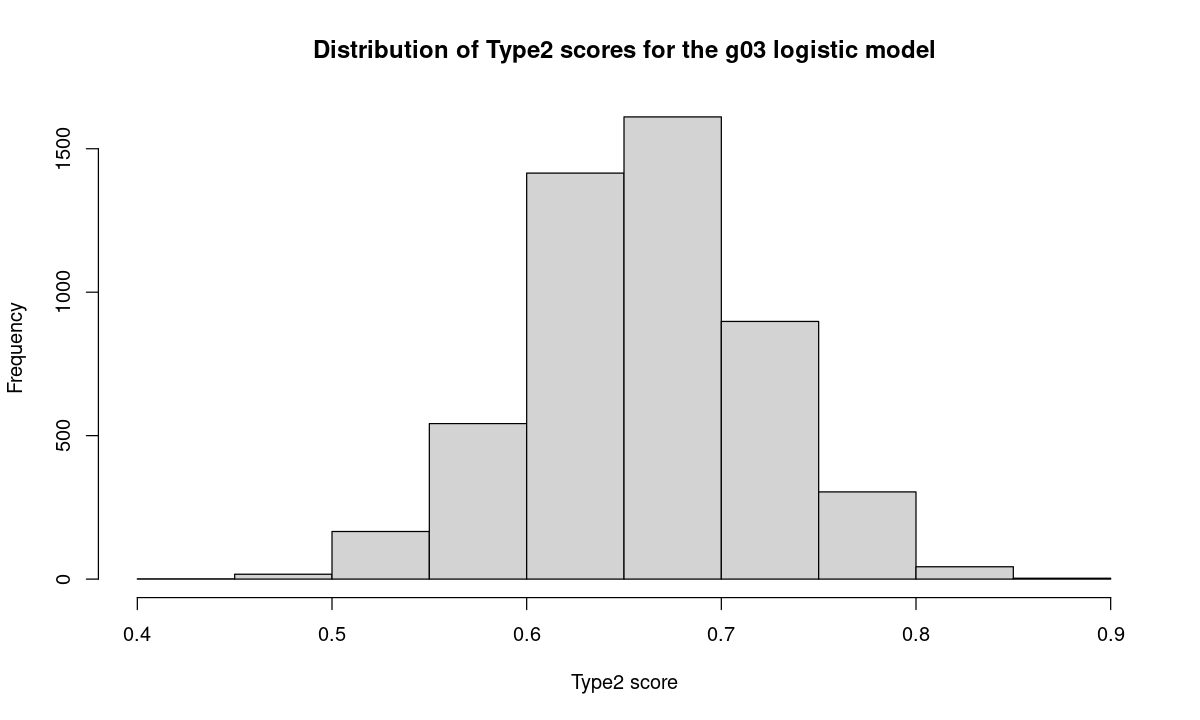

In [24]:
# Histogram of the Type2 scores for the svm02 model.

options(repr.plot.width= 10, repr.plot.height= 6)
hist(dat_result$Type2, breaks=10, xlab="Type2 score",
     main="Distribution of Type2 scores for the g03 logistic model")


In [25]:
FN_mean <- round(mean(dat_result$FN), 4)
FN_sd <- round(sd(dat_result$FN), 4)
paste0("FN mean: ", as.character(FN_mean))
# 8.82
paste0("FN StdDev: ", as.character(FN_sd))
# 2.21
""
summary(dat_result$FN)


[1] "FN mean: 8.8212"

[1] "FN StdDev: 2.2106"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    7.00    9.00    8.82   10.00   17.00 

In [26]:
FP_mean <- round(mean(dat_result$FP), 4)
FP_sd <- round(sd(dat_result$FP), 4)
paste0("FP mean: ", as.character(FP_mean))
# 9.21
paste0("FP StdDev: ", as.character(FP_sd))
# 2.77
""
summary(dat_result$FP)


[1] "FP mean: 9.211"

[1] "FP StdDev: 2.7696"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    7.00    9.00    9.21   11.00   20.00 

## Item 1 Comments

The g03 logistic regression model is very competitive despite its construction not involving cross-validation.  It has an average accuracy score of nearly 72% and an average Type2 score exceeding 66%.

## Item 2: More plots of separation of points by Outcome level

In [29]:
newtrain <- traindat

set.seed(123)
gbclf_best <- gbm(Outcome ~ ., data= newtrain, n.trees= 130,
                  distribution= "bernoulli", shrinkage= 0.02)
    
preds <- suppressMessages(predict(gbclf_best, newdata= newtrain, type="response"))
newtrain$prob01 <- preds


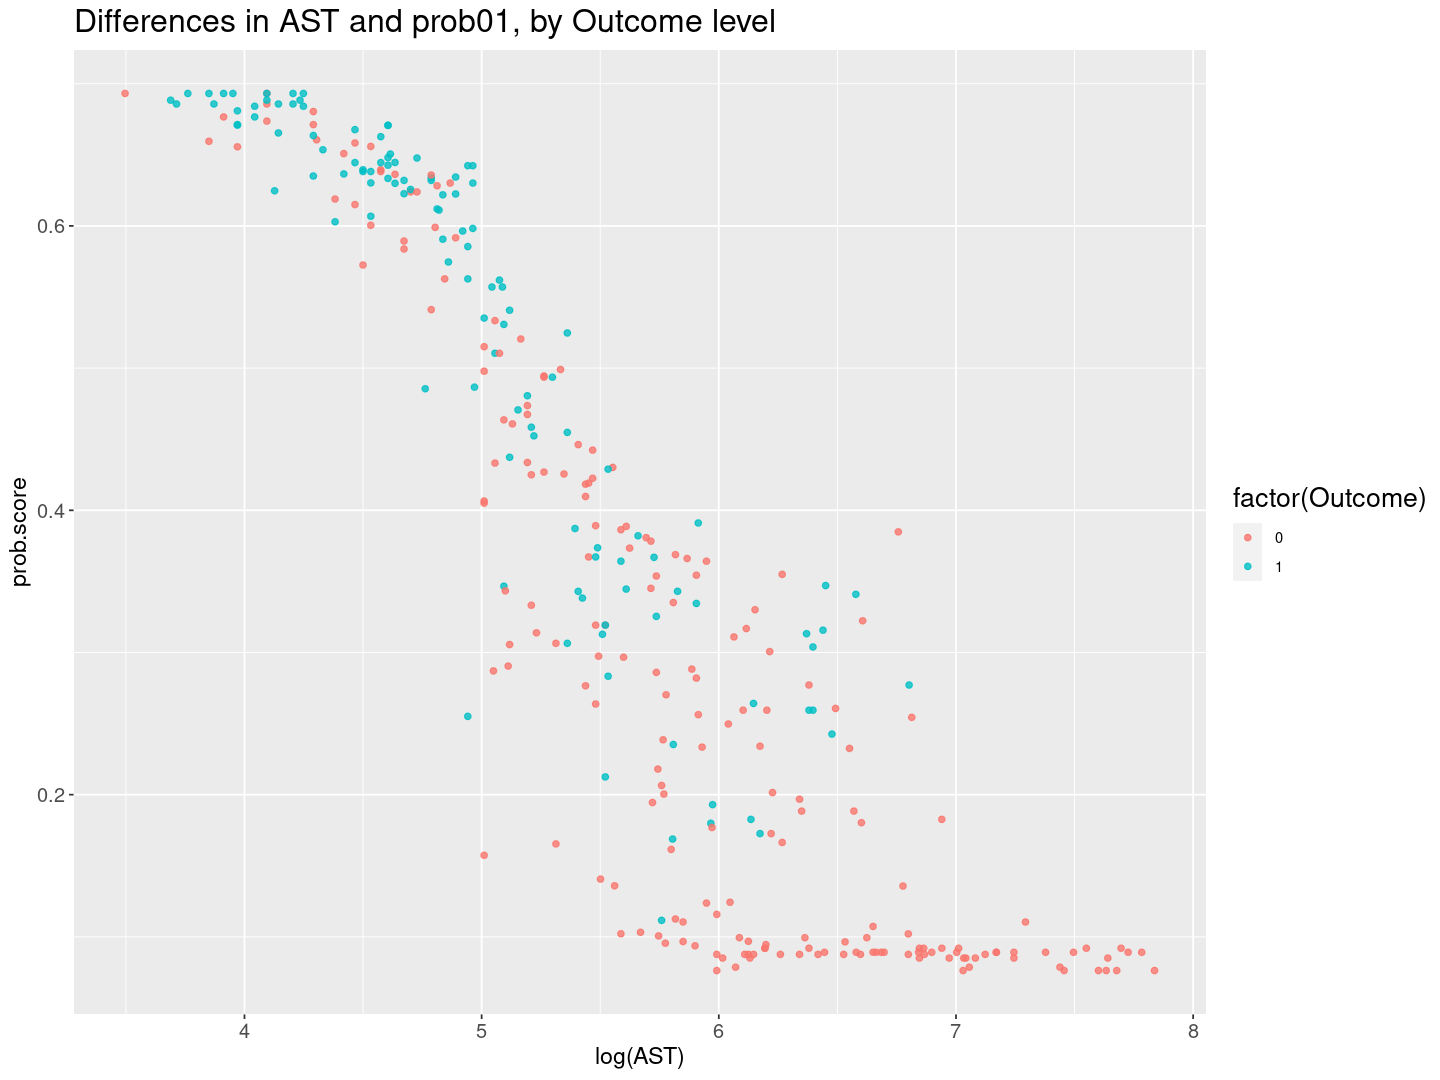

In [31]:
# For the new hybrid model that uses gbclf_best for the prob01 
# probabilities, the weight on AST is 57% and the weight on 
# prob01 is 13%.

dat_plot <- newtrain[, c("Outcome","AST","prob01"), drop=FALSE]
dat_plot$AST <- log(dat_plot$AST)


options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(AST, prob01, color= factor(Outcome))) +

  geom_point(alpha= 0.8) + 
  xlab("log(AST)") + ylab("prob.score") +
  ggtitle("Differences in AST and prob01, by Outcome level") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


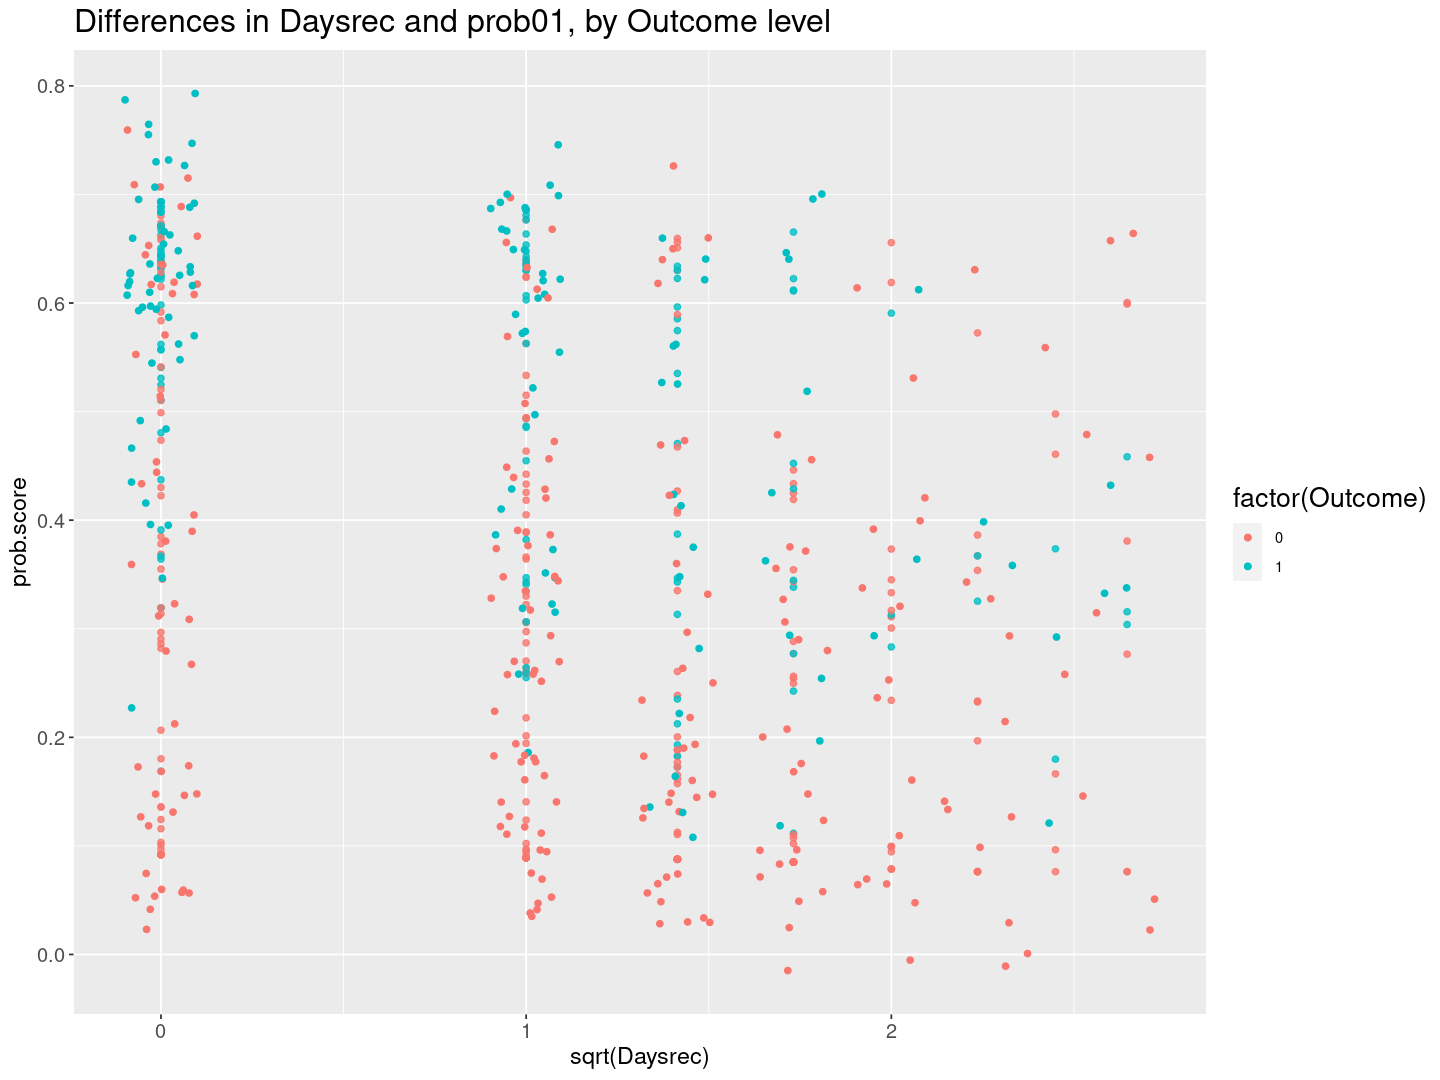

In [33]:
# Plot Daysrec vs. prob01.

dat_plot <- newtrain[, c("Outcome","Daysrec","prob01"), drop=FALSE]
dat_plot$Daysrec <- sqrt(dat_plot$Daysrec)


options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(Daysrec, prob01, color= factor(Outcome))) +

  geom_point(alpha= 0.8) + geom_jitter(width= 0.1, height= 0.1) +
  xlab("sqrt(Daysrec)") + ylab("prob.score") +
  ggtitle("Differences in Daysrec and prob01, by Outcome level") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p


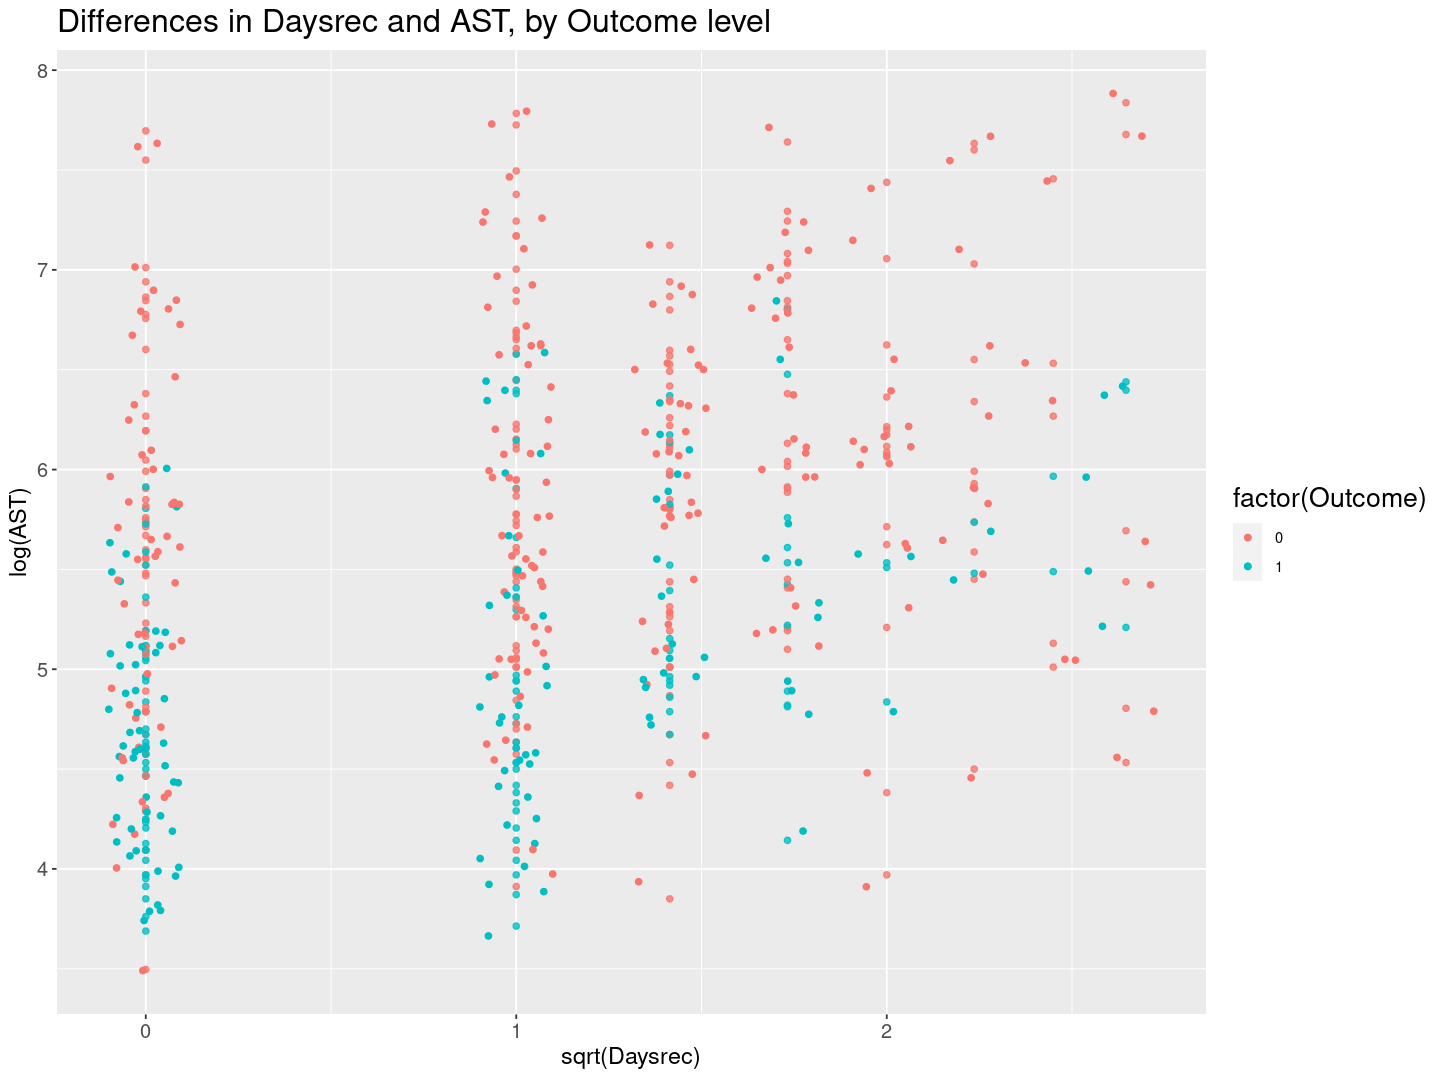

In [36]:
# Plot Daysrec vs. AST.

dat_plot <- newtrain[, c("Outcome","Daysrec","AST"), drop=FALSE]
dat_plot$Daysrec <- sqrt(dat_plot$Daysrec)
dat_plot$AST <- log(dat_plot$AST)

options(repr.plot.width= 12, repr.plot.height= 9)

p <- ggplot(dat_plot, aes(Daysrec, AST, color= factor(Outcome))) +

  geom_point(alpha= 0.8) + geom_jitter(width= 0.1, height= 0.1) +
  xlab("sqrt(Daysrec)") + ylab("log(AST)") +
  ggtitle("Differences in Daysrec and AST, by Outcome level") +
  theme(axis.text= element_text(size = 12)) +
  theme(axis.title= element_text(size= 14)) +
  theme(title= element_text(size= 16))
p